In [5]:
# === Cell 0 (revised/final): imports + parameter loader + utils ===
from __future__ import annotations
from pathlib import Path
import os, re, json, types, time, warnings, math, hashlib
from collections import deque
from typing import List, Dict, Any
from datetime import datetime as _dt

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.utils.exceptions import AstropyUserWarning
from astropy.visualization import ZScaleInterval, ImageNormalize

# photutils 2.x
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

# 3rd
from scipy.spatial import cKDTree as KDTree

# ---- Warnings / BLAS guards ----
warnings.filterwarnings("once", category=AstropyUserWarning,
    message=r"Input data contains invalid values \(NaNs or infs\).*")
warnings.filterwarnings("ignore", message=".*'partition' will ignore the 'mask'.*")
warnings.filterwarnings("ignore", message="The deblending mode.*")

os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

# ---- NaN-safe gray colormap ----
CM_GRAY = mpl.cm.get_cmap('gray').copy()
CM_GRAY.set_bad((0.25,0.25,0.25,1.0))

# ---- Matplotlib ----
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 9
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['font.family'] = ['Malgun Gothic']
FIGSIZE = (6,5); DPI = 120

# ---- Jupyter backend ----
try:
    from IPython import get_ipython
    ip = get_ipython()
except Exception:
    ip = None
HAS_IPYMPL = False
if ip is not None:
    try:
        import ipympl  # noqa
        ip.run_line_magic("matplotlib", "widget")
        HAS_IPYMPL = True
    except Exception:
        try:
            ip.run_line_magic("matplotlib", "inline")
        except Exception:
            pass

# -------------------- Helpers --------------------
def _to_plain(a):
    if isinstance(a, np.ma.MaskedArray): 
        return a.filled(np.nan)
    return a

def _jsonify(o):
    if isinstance(o, (np.floating,)): return float(o)
    if isinstance(o, (np.integer,)):  return int(o)
    if isinstance(o, (np.bool_,)):    return bool(o)
    return o

def _is_up_to_date(target: Path, deps: List[Path]) -> bool:
    target = Path(target)
    if not target.exists(): 
        return False
    try:
        t = target.stat().st_mtime
        return all(Path(d).exists() and t >= Path(d).stat().st_mtime for d in deps)
    except Exception:
        return False

# ---- Tail logger ----
class TailLogger:
    def __init__(self, log_path: Path, tail: int = 5, enable_console: bool = True):
        self.log_path = Path(log_path)
        self.log_path.parent.mkdir(parents=True, exist_ok=True)
        self.fh = open(self.log_path, "a", encoding="utf-8")
        self.buf = deque(maxlen=max(1, tail))
        self.enable_console = enable_console
        try:
            from IPython.display import clear_output
            self._clear = lambda : clear_output(wait=True)
        except Exception:
            self._clear = lambda : None
    def write(self, msg: str):
        ts = time.strftime("%H:%M:%S")
        line = f"[{ts}] {msg}"
        self.fh.write(line + "\n"); self.fh.flush()
        if self.enable_console:
            self.buf.append(line); self._clear(); print("\n".join(self.buf))
    def close(self):
        try: self.fh.close()
        except: pass

# === FITS helpers ===
def get_exptime_from_fits(path: Path, default: float = 1.0) -> float:
    try:
        with fits.open(path) as hdul:
            return float(hdul[0].header.get("EXPTIME", default))
    except Exception:
        return default

def get_filter_from_fits(path: Path) -> str:
    """헤더 FILTER → 실패시 headers.csv/tsv 폴백. 반환은 소문자."""
    try:
        with fits.open(path) as hdul:
            f = hdul[0].header.get("FILTER", None)
            if f: return str(f).strip().lower()
    except Exception:
        pass

    base = Path(path).name
    if base.startswith("rc_"): base = base[3:]
    if base.startswith("r_"):  base = base[2:]

    try:
        if "df_headers" in globals() and df_headers is not None:
            row = df_headers[df_headers["Filename"] == base]
            if not row.empty:
                return str(row["FILTER"].values[0]).strip().lower()
    except Exception:
        pass
    return "unknown"

# ---- parameter loader ----
PARAM_PATH = Path("parametertxt.txt")  # 필요하면 "parameter.txt" 등으로 바꿔도 됨

def _as_bool(v, default=False):
    if v is None: 
        return default
    return str(v).strip().lower() in ("1","true","yes","y","on")

def _as_float_or_none(v):
    try:
        s = str(v).strip()
        return float(s) if s != "" else None
    except:
        return None

def _read_kv_lines(path: Path) -> Dict[str, str]:
    d={}
    if path.exists():
        for line in path.read_text(encoding="utf-8").splitlines():
            s=line.strip()
            if (not s) or s.startswith("#"): 
                continue
            if "#" in s: 
                s=s.split("#",1)[0].strip()
            if "=" in s:
                k,v=[t.strip() for t in s.split("=",1)]
                d[k]=v
    return d

def _getf(raw, key, default):
    s = str(raw.get(key, "")).strip()
    try:
        return default if s=="" else float(s)
    except:
        return default

def _geti(raw, key, default):
    s = str(raw.get(key, "")).strip()
    try:
        if s == "": return default
        return int(float(s))
    except:
        return default

def read_params(path: Path):
    raw = _read_kv_lines(path)

    # --- rdnoise 강제: 허용 키 중 하나는 반드시 있어야 함 ---
    rdnoise_candidate = (
        _as_float_or_none(raw.get("rdnoise_e",""))
        or _as_float_or_none(raw.get("datapar.readnoise",""))
        or _as_float_or_none(raw.get("readnoise_e",""))
    )
    if rdnoise_candidate is None:
        raise RuntimeError(
            "[parameter.txt] read noise 값이 필요합니다.\n"
            "  허용 키: rdnoise_e 또는 datapar.readnoise 또는 readnoise_e\n"
            "  예) rdnoise_e = 1.39   # electrons"
        )

    P = types.SimpleNamespace(
        # I/O
        data_dir          = raw.get("data_dir", "."),
        filename_prefix   = raw.get("filename_prefix", "pp_"),
        # ★ 기존 오타 수정: result_dir 키는 'result_dir'
        result_dir        = raw.get("result_dir", ""),
        cache_dir         = raw.get("cache_dir", "cache"),

        # 병렬
        parallel_mode     = raw.get("parallel_mode", "thread"),
        max_workers       = _geti(raw, "max_workers", 0),   # 0 → auto
        ui_log_tail       = _geti(raw, "ui_log_tail", 300),
        resume_mode       = _as_bool(raw.get("resume_mode","true"), True),
        force_redetect    = _as_bool(raw.get("force_redetect","false"), False),
        force_rephot      = _as_bool(raw.get("force_rephot","false"), False),
        detect_cache_strategy = raw.get("detect_cache_strategy","mtime"),
        detect_progress_bar   = _as_bool(raw.get("detect_progress_bar","true"), True),

        align_ref_index = _geti(raw,"align_ref_index",0),
        global_align = _as_bool(raw.get("global_align","true"), True),
        global_ref_filter = raw.get("global_ref_filter","r"),
        global_ref_index = _geti(raw,"global_ref_index",0),

        # 스케일/PSF/FWHM
        # (pixel scale은 Cell 1에서 instrument 계산값으로만 세팅)
        pixel_scale_arcsec  = np.nan,
        fwhm_pix_guess     = _as_float_or_none(raw.get("fwhm_pix_guess","")),
        fwhm_guess_arcsec  = _as_float_or_none(raw.get("fwhm_guess_arcsec","")),
        fwhm_arcsec_min    = _as_float_or_none(raw.get("fwhm_arcsec_min","")),
        fwhm_arcsec_max    = _as_float_or_none(raw.get("fwhm_arcsec_max","")),
        fwhm_px_min        = _getf(raw,"fwhm_px_min", 3.5),
        fwhm_px_max        = _getf(raw,"fwhm_px_max", 12.0),
        fwhm_qc_max_sources= _geti(raw,"fwhm_qc_max_sources", 40),
        fwhm_elong_max     = _getf(raw,"fwhm_elong_max", 1.3),
        iso_min_sep_pix    = _getf(raw,"iso_min_sep_pix", 18.0),

        # 검출
        detect_engine      = raw.get("detect_engine","segm"),
        detect_sigma       = _getf(raw,"detect_sigma", 3.2),
        detect_sigma_g     = _as_float_or_none(raw.get("detect_sigma_g","")),
        detect_sigma_r     = _as_float_or_none(raw.get("detect_sigma_r","")),
        detect_sigma_i     = _as_float_or_none(raw.get("detect_sigma_i","")),
        minarea_pix        = _geti(raw,"minarea_pix", 3),
        deblend_enable     = _as_bool(raw.get("deblend_enable","true"), True),
        deblend_nthresh    = _geti(raw,"deblend_nthresh", 64),
        deblend_cont       = _getf(raw,"deblend_cont", 0.0025),
        segm_dilate_radius_px = _geti(raw,"segm_dilate_radius_px", 4),

        # 배경/클리핑/데이터범위
        bkg2d_in_detect    = _as_bool(raw.get("bkg2d_in_detect","true"), True),
        bkg2d_box          = _geti(raw,"bkg2d_box", 64),
        bkg2d_filter_size  = _geti(raw,"bkg2d_filter_size", 3),
        bkg2d_edge_method  = raw.get("bkg2d_edge_method", "pad"),
        bkg2d_method       = raw.get("bkg2d_method", "median"),

        # 게이트/QC
        gate_enable        = _as_bool(raw.get("gate_enable","true"), True),

        # 포토/아뉴러스 스케일
        phot_aperture_scale   = _getf(raw,"phot_aperture_scale", 1.0),
        fitsky_annulus_scale  = _getf(raw,"fitsky_annulus_scale", 4.0),
        fitsky_dannulus_scale = _getf(raw,"fitsky_dannulus_scale", 2.0),
        center_cbox_scale     = _getf(raw,"center_cbox_scale", 1.5),
        annulus_min_gap_px    = _getf(raw,"annulus_min_gap_px", 6.0),
        annulus_min_width_px  = _getf(raw,"annulus_min_width_px", 12.0),

        # Zero point / 카메라
        saturation_adu     = _getf(raw,"saturation_adu", 60000.0),
        gain_e_per_adu     = _getf(raw,"gain_e_per_adu", 0.1),
        # ★ 실제 값은 rdnoise_candidate로 확정
        rdnoise_e          = float(rdnoise_candidate),
        zp_initial         = _getf(raw,"zp_initial", 25.0),

        # 5X HUD
        _hud5 = {
            "5x.aperture_scale":       raw.get("5x.aperture_scale",""),
            "5x.center_cbox_scale":    raw.get("5x.center_cbox_scale",""),
            "5x.annulus_in_scale":     raw.get("5x.annulus_in_scale",""),
            "5x.annulus_out_scale":    raw.get("5x.annulus_out_scale",""),
            "5x.min_r_ap_px":          raw.get("5x.min_r_ap_px",""),
            "5x.min_r_in_px":          raw.get("5x.min_r_in_px",""),
            "5x.min_r_out_px":         raw.get("5x.min_r_out_px",""),
            "5x.sigma_clip":           raw.get("5x.sigma_clip",""),
            "5x.neighbor_mask_scale":  raw.get("5x.neighbor_mask_scale",""),
            "5x.mag_flux":             raw.get("5x.mag_flux","rate_e"),
            "5x.use_header_exptime":   raw.get("5x.use_header_exptime","true"),
        },

        # 11번셀 관련 플래그
        aperture_mode              = raw.get("aperture_mode","apcorr"),
        annulus_neighbor_mask_scale= _getf(raw,"annulus_neighbor_mask_scale", 1.3),
        recenter_aperture          = _as_bool(raw.get("recenter_aperture","true"), True),
        bkg_use_segm_mask          = _as_bool(raw.get("bkg_use_segm_mask","true"), True),
        min_snr_for_mag            = _getf(raw,"min_snr_for_mag", 3.0),
    )

    # raw 보존 (호환 접근용)
    P._raw = raw

    # result/cache dirs
    P.data_dir   = Path(P.data_dir)
    P.result_dir = Path(P.result_dir) if P.result_dir else (P.data_dir / "result")
    P.result_dir.mkdir(parents=True, exist_ok=True)
    P.cache_dir  = (P.result_dir / str(P.cache_dir))
    P.cache_dir.mkdir(parents=True, exist_ok=True)

    # FWHM seed(px): 여기서는 legacy(px)만 확정. arcsec 변환은 Cell 1에서 수행.
    pix_legacy = P.fwhm_pix_guess
    P.fwhm_seed_px = float(pix_legacy if pix_legacy is not None else 6.0)
    P._fwhm_seed_from = "pixel-legacy"

    return P

def _param_hash(path=PARAM_PATH):
    try:
        txt = Path(path).read_text(encoding="utf-8", errors="ignore")
        lines=[]
        for ln in txt.splitlines():
            s=ln.strip()
            if (not s) or s.startswith("#"): 
                continue
            if "#" in s: 
                s=s.split("#",1)[0].strip()
            lines.append(s)
        norm = "\n".join(lines).encode("utf-8")
        return hashlib.sha1(norm).hexdigest()
    except Exception:
        return "NO_PARAM"

# ---- bootstrap ----
CODE_VER = "pipeline-2025-10-29-rdnoise-param-required"
P = read_params(PARAM_PATH)
DATA_DIR, RESULT_DIR, CACHE_DIR = P.data_dir, P.result_dir, P.cache_dir
PARAM_HASH = _param_hash()

def print_bootstrap_summary(P):
    print("\n==================== PARAM SUMMARY ====================")
    print(f"DATA_DIR      : {P.data_dir}")
    print(f"RESULT_DIR    : {P.result_dir}")
    print(f"CACHE_DIR     : {P.cache_dir}")
    print(f"resume_mode   : {P.resume_mode} | force_redetect={P.force_redetect} | force_rephot={P.force_rephot}")
    print(f"parallel_mode : {P.parallel_mode} | max_workers={P.max_workers}")
    print(f"FWHM seed     : {P.fwhm_seed_px:.2f} px (from={getattr(P,'_fwhm_seed_from','?')})")
    print(f"FWHM range    : {P.fwhm_px_min:.2f} ~ {P.fwhm_px_max:.2f} px | elong_max={P.fwhm_elong_max} | iso_min_sep={P.iso_min_sep_pix}px")

    print(f"bkg2d detect  : {P.bkg2d_in_detect} | box={P.bkg2d_box}")
    print(f"detect_sigma  : base={P.detect_sigma} | g={P.detect_sigma_g} r={P.detect_sigma_r} i={P.detect_sigma_i}")
    print(f"deblend       : enable={P.deblend_enable} nthresh={P.deblend_nthresh} cont={P.deblend_cont} dilate={P.segm_dilate_radius_px}")

    print(f"clip          : sat_adu={P.saturation_adu}")
    print(f"camera        : gain={P.gain_e_per_adu} e-/ADU | rdnoise={P.rdnoise_e} e- | zp_init={P.zp_initial}")
    print("=======================================================\n")

print_bootstrap_summary(P)

# ---- optional headers.csv/tsv resolver (for FILTER lookup) ----
df_headers = None
for hp in (RESULT_DIR/"headers.csv", DATA_DIR/"headers.csv",
           RESULT_DIR/"headers.tsv", DATA_DIR/"headers.tsv"):
    if hp.exists():
        try:
            sep = "\t" if hp.suffix.lower()==".tsv" else ","
            df_headers = pd.read_csv(hp, sep=sep)
            df_headers.columns = [str(c).strip() for c in df_headers.columns]
            if "Filename" not in df_headers.columns:
                for cand in ("filename","FILE","File","name","Name"):
                    if cand in df_headers.columns:
                        df_headers.rename(columns={cand:"Filename"}, inplace=True)
                        break
            if "FILTER" not in df_headers.columns:
                for cand in ("Filter","filter","FILTER1","FILTER2"):
                    if cand in df_headers.columns:
                        df_headers.rename(columns={cand:"FILTER"}, inplace=True)
                        break
            print(f"Loaded headers: {hp.name} (rows={len(df_headers)})")
            break
        except Exception as e:
            print(f"headers load failed: {hp.name} → {e}")
            df_headers = None

df_header = df_headers  # legacy typo compatibility

# ---- Compatibility accessor for later cells ----
def _pget(name: str, default=None):
    """
    호환용 파라미터 접근자.
    1) P의 속성 → 2) P._raw의 원문 키 → 3) default
    """
    if hasattr(P, name):
        val = getattr(P, name)
        if not (val is None or (isinstance(val, str) and val.strip()=="")):
            return val
    if hasattr(P, "_raw") and name in P._raw:
        rawv = P._raw[name]
        if isinstance(default, bool):
            return _as_bool(rawv, default)
        if isinstance(default, int):
            fv = _as_float_or_none(rawv)
            return int(fv) if fv is not None else default
        if isinstance(default, float):
            fv = _as_float_or_none(rawv)
            return fv if fv is not None else default
        return rawv
    return default



==================== PARAM SUMMARY ====================
DATA_DIR      : C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5
RESULT_DIR    : C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result
CACHE_DIR     : C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\cache
resume_mode   : True | force_redetect=False | force_rephot=False
parallel_mode : thread | max_workers=0
FWHM seed     : 6.00 px (from=pixel-legacy)
FWHM range    : 3.00 ~ 10.00 px | elong_max=1.3 | iso_min_sep=10.0px
bkg2d detect  : True | box=64
detect_sigma  : base=3.2 | g=3.4 r=3.2 i=3.0
deblend       : enable=True nthresh=64 cont=0.004 dilate=4
clip          : sat_adu=65000.0
camera        : gain=0.1 e-/ADU | rdnoise=1.39 e- | zp_init=25.0

Loaded headers: headers.csv (rows=3)


C:\Users\bmffr\AppData\Local\Temp\ipykernel_3020\3991388546.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CM_GRAY = mpl.cm.get_cmap('gray').copy()


In [6]:
# === Cell 0.5 (Telescope/Camera 설정 + FOV/Pixel scale + LimMag helper + SIMBAD) ===
from astropy.coordinates import SkyCoord
import astropy.units as u

_raw = getattr(P, "_raw", {})  # ★ NameError 방지

# astroquery.simbad 는 있으면 사용, 없으면 우회
try:
    from astroquery.simbad import Simbad
    _HAS_SIMBAD = True
except Exception as e:
    print("[SIMBAD] astroquery.simbad import 실패 → SIMBAD 사용 불가:", e)
    _HAS_SIMBAD = False

# -----------------------------------------------------------------------------
# 1. 망원경/카메라 하드웨어 설정 (CDK500 + Moravian C3-61000)
# -----------------------------------------------------------------------------
TELESCOPE_NAME   = "Planewave CDK500"
APERTURE_MM      = 500.0
FOCAL_LENGTH_MM  = 3947.0
FOCAL_RATIO      = FOCAL_LENGTH_MM / APERTURE_MM

CAMERA_NAME      = "Moravian C3-61000"
PIX_SIZE_UM      = 3.76
SENSOR_W_MM      = 36.01
SENSOR_H_MM      = 24.02
SENSOR_NX_1X     = 9576
SENSOR_NY_1X     = 6388

# binning default (파라미터 있으면 그거, 없으면 2)
try:
    BIN_DEFAULT = int(float(getattr(P, "binning_default", 2) or 2))
except Exception:
    BIN_DEFAULT = 2

# -----------------------------------------------------------------------------
# 2. Pixel scale / FOV 계산 (instrument 값만 사용)
# -----------------------------------------------------------------------------
def _pixel_scale_arcsec(pixel_size_um: float, focal_length_mm: float, binning: int = 1) -> float:
    return 206.265 * pixel_size_um * float(binning) / float(focal_length_mm)

def _fov_deg(sensor_mm: float, focal_length_mm: float) -> float:
    return 57.2957795 * sensor_mm / float(focal_length_mm)

PIX_SCALE_1X = _pixel_scale_arcsec(PIX_SIZE_UM, FOCAL_LENGTH_MM, binning=1)
FOV_W_1X_DEG = _fov_deg(SENSOR_W_MM, FOCAL_LENGTH_MM)
FOV_H_1X_DEG = _fov_deg(SENSOR_H_MM, FOCAL_LENGTH_MM)

PIX_SCALE_BIN = _pixel_scale_arcsec(PIX_SIZE_UM, FOCAL_LENGTH_MM, binning=BIN_DEFAULT)

# ★ pixel scale은 parameter가 아니라 여기서 계산한 값만 사용
P.pixel_scale_arcsec = float(PIX_SCALE_BIN)
_PIX_SCALE_SOURCE = "instrument"
print(f"[Camera] pixel scale = {P.pixel_scale_arcsec:.6f}\"/pix (bin={BIN_DEFAULT}x{BIN_DEFAULT})")

# arcsec → px 변환 (pixel scale 확정 이후에만!)
arc = getattr(P, "fwhm_guess_arcsec", None)
if arc is not None and np.isfinite(arc) and arc > 0:
    P.fwhm_seed_px = max(2.0, float(arc) / P.pixel_scale_arcsec)
    P._fwhm_seed_from = "arcsec"

arcmin = getattr(P, "fwhm_arcsec_min", None)
if arcmin is not None and np.isfinite(arcmin):
    P.fwhm_px_min = max(float(P.fwhm_px_min), float(arcmin) / P.pixel_scale_arcsec)

arcmax = getattr(P, "fwhm_arcsec_max", None)
if arcmax is not None and np.isfinite(arcmax):
    P.fwhm_px_max = min(float(P.fwhm_px_max), float(arcmax) / P.pixel_scale_arcsec)

# param에 pixel_scale_arcsec가 있어도 무시한다는 경고(선택)
ps_in_param = str(_raw.get("pixel_scale_arcsec","")).strip()
if ps_in_param:
    print(f"[주의] parameter.txt의 pixel_scale_arcsec={ps_in_param} 은(는) 무시됨 → instrument 계산값 사용")

# -----------------------------------------------------------------------------
# 3. 한계등급 helper
# -----------------------------------------------------------------------------
def estimate_limiting_mag(
    zp: float,
    exptime_s: float,
    fwhm_arcsec: float,
    sky_sigma_e_per_px: float,
    pix_scale_arcsec: float,
    snr_limit: float = 5.0,
    rdnoise_e: float | None = None,
) -> float:
    if rdnoise_e is None:
        rdnoise_e = float(getattr(P, "rdnoise_e", 7.5))

    if pix_scale_arcsec <= 0:
        raise ValueError("pix_scale_arcsec > 0 이어야 합니다.")

    r_fwhm_px = (fwhm_arcsec / pix_scale_arcsec) / 2.0
    A_psf = math.pi * max(r_fwhm_px, 0.5)**2

    sky_e_per_px = sky_sigma_e_per_px**2

    def snr_for_mag(m: float) -> float:
        rate_e = 10.0**(-0.4 * (m - zp))
        N_star = rate_e * exptime_s
        N_sky  = sky_e_per_px * A_psf
        N_RN2  = (rdnoise_e**2) * A_psf
        var    = max(N_star + N_sky + N_RN2, 1e-12)
        return N_star / math.sqrt(var)

    m_min = zp - 5.0
    m_max = zp + 20.0
    s_min = snr_for_mag(m_min)
    s_max = snr_for_mag(m_max)

    if s_min < snr_limit:
        return m_min
    if s_max > snr_limit:
        return m_max

    for _ in range(60):
        m_mid = 0.5 * (m_min + m_max)
        s_mid = snr_for_mag(m_mid)
        if s_mid > snr_limit:
            m_min = m_mid
        else:
            m_max = m_mid
        if abs(m_max - m_min) < 1e-3:
            break
    return 0.5 * (m_min + m_max)

def _get_float_from_raw(key: str, default: float | None = None):
    v = _raw.get(key, "")
    s = str(v).strip()
    if s == "":
        return default
    try:
        return float(s)
    except Exception:
        return default

_lim_exptime_s      = _get_float_from_raw("lim_exptime_s", None)
_lim_fwhm_arcsec    = _get_float_from_raw("lim_fwhm_arcsec", None)
_lim_sky_sigma_e    = _get_float_from_raw("lim_sky_sigma_e", None)
_lim_snr            = _get_float_from_raw("lim_snr_limit", 5.0)
_zp_for_lim         = float(getattr(P, "zp_initial", 25.0))

# -----------------------------------------------------------------------------
# 4. SIMBAD 대상 찾기 + targets.txt 연동
# -----------------------------------------------------------------------------
TARGET_LIST_PATH = DATA_DIR / "targets.txt"

raw_targets: list[str] = []
tn_param = _raw.get("target_name", None)
if tn_param is not None and str(tn_param).strip():
    raw_targets.append(str(tn_param).strip())

if TARGET_LIST_PATH.exists():
    for line in TARGET_LIST_PATH.read_text(encoding="utf-8").splitlines():
        s = line.strip()
        if (not s) or s.startswith("#"):
            continue
        raw_targets.append(s)

if not raw_targets:
    raw_targets = ["M31"]

seen = set()
targets: list[str] = []
for name in raw_targets:
    if name not in seen:
        seen.add(name)
        targets.append(name)

targets_resolved: list[dict] = []
PRIMARY_TARGET = None
PRIMARY_COORD  = None

if _HAS_SIMBAD:
    Simbad.reset_votable_fields()
    Simbad.add_votable_fields("ra(d)", "dec(d)", "flux(V)", "otype")

    print("\n=== SIMBAD 대상 해결 시작 ===")
    for name in targets:
        try:
            res = Simbad.query_object(name)
            if res is None or len(res) == 0:
                print(f"[SIMBAD] Not found: {name}")
                continue

            ra_deg  = float(res["RA_d"][0])
            dec_deg = float(res["DEC_d"][0])
            ra_str  = str(res["RA"][0])
            dec_str = str(res["DEC"][0])
            vmag    = float(res["FLUX_V"][0]) if "FLUX_V" in res.colnames else np.nan
            otype   = str(res["OTYPE"][0]) if "OTYPE" in res.colnames else ""

            rec = dict(name=name, ra_deg=ra_deg, dec_deg=dec_deg,
                       ra_str=ra_str, dec_str=dec_str, vmag=vmag, otype=otype)
            targets_resolved.append(rec)

            print(f"[SIMBAD] {name:20s} → RA={ra_str}  DEC={dec_str}  "
                  f"({ra_deg:9.5f}°, {dec_deg:9.5f}°)  V~{vmag if np.isfinite(vmag) else 'n/a'}  [{otype}]")

        except Exception as e:
            print(f"[SIMBAD] ERROR for '{name}': {e}")

    if targets_resolved:
        PRIMARY_TARGET = targets_resolved[0]["name"]
        PRIMARY_COORD  = SkyCoord(targets_resolved[0]["ra_deg"], targets_resolved[0]["dec_deg"], unit="deg")
        out = RESULT_DIR / "targets_simbad.tsv"
        pd.DataFrame(targets_resolved).to_csv(out, sep="\t", index=False)
        print(f"→ SIMBAD 결과 저장: {out}")
    else:
        print("SIMBAD에서 성공적으로 해결된 타깃이 없습니다.")
else:
    print("\n[SIMBAD] astroquery 미설치/오류로 SIMBAD 해석은 건너뜁니다.")
    PRIMARY_TARGET = targets[0]
    PRIMARY_COORD  = None

# -----------------------------------------------------------------------------
# 5. 요약 출력 + (옵션) 한계등급 계산
# -----------------------------------------------------------------------------
print("\n=== Instrument summary (CDK500 + C3-61000) ===")
print(f"Telescope : {TELESCOPE_NAME}")
print(f"  Aperture D = {APERTURE_MM:.1f} mm")
print(f"  Focal length F = {FOCAL_LENGTH_MM:.1f} mm  (f/{FOCAL_RATIO:.2f})")
print(f"Camera    : {CAMERA_NAME}")
print(f"  Pixel size (1x1) = {PIX_SIZE_UM:.3f} μm")
print(f"  Sensor = {SENSOR_W_MM:.2f} × {SENSOR_H_MM:.2f} mm  "
      f"({SENSOR_NX_1X} × {SENSOR_NY_1X} px @1x1)")
print(f"Default binning = {BIN_DEFAULT}×{BIN_DEFAULT}")
print(f"Pixel scale (1x1)  ≈ {PIX_SCALE_1X:.6f} \" / px")
print(f"Pixel scale ({BIN_DEFAULT}x{BIN_DEFAULT}) ≈ {PIX_SCALE_BIN:.6f} \" / px  "
      f"(pipeline pixel_scale_arcsec={P.pixel_scale_arcsec:.6f} \" / px, source={_PIX_SCALE_SOURCE})")
print(f"Full FOV (sensor, any binning) ≈ {FOV_W_1X_DEG:.3f} × {FOV_H_1X_DEG:.3f} deg")

if PRIMARY_TARGET is not None:
    if PRIMARY_COORD is not None:
        ra_hms = PRIMARY_COORD.ra.to_string(unit=u.hour, sep=":", precision=2)
        dec_dms= PRIMARY_COORD.dec.to_string(unit=u.deg, sep=":", precision=1, alwayssign=True)
        print(f"\nPRIMARY TARGET: {PRIMARY_TARGET}  (RA={ra_hms}, DEC={dec_dms})")
    else:
        print(f"\nPRIMARY TARGET (이름만): {PRIMARY_TARGET}")

if (_lim_exptime_s is not None) and (_lim_fwhm_arcsec is not None) and (_lim_sky_sigma_e is not None):
    try:
        m_lim = estimate_limiting_mag(
            zp=_zp_for_lim,
            exptime_s=_lim_exptime_s,
            fwhm_arcsec=_lim_fwhm_arcsec,
            sky_sigma_e_per_px=_lim_sky_sigma_e,
            pix_scale_arcsec=float(P.pixel_scale_arcsec),
            snr_limit=float(_lim_snr),
            rdnoise_e=float(getattr(P, "rdnoise_e", 7.5)),
        )
        print(f"\n[Limiting mag] exptime={_lim_exptime_s:.1f}s, FWHM={_lim_fwhm_arcsec:.2f}\", "
              f"sky_sigma={_lim_sky_sigma_e:.2f} e-/px, SNR={_lim_snr:.1f} 기준")
        print(f"  → 대략적인 한계등급 m_lim ≈ {m_lim:.2f} mag (ZP={_zp_for_lim:.2f})")
    except Exception as e:
        print("[Limiting mag] 계산 중 오류:", e)
else:
    print("\n[Limiting mag] parameter.txt에 다음 키를 넣으면 자동 계산됩니다:")
    print("  lim_exptime_s      = (예: 300)      # 단일 프레임 노출시간 [s]")
    print("  lim_fwhm_arcsec    = (예: 2.0)      # seeing FWHM [arcsec]")
    print("  lim_sky_sigma_e    = (예: 15.0)     # sky sigma [e-/px] (frame_sky_sigma.csv 값)")
    print("  lim_snr_limit      = (선택, 예: 5.0) # SNR 한계 (기본 5σ)")


[Camera] pixel scale = 0.392985"/pix (bin=2x2)
[주의] parameter.txt의 pixel_scale_arcsec=0.393 은(는) 무시됨 → instrument 계산값 사용

=== SIMBAD 대상 해결 시작 ===
[SIMBAD] M5                   → RA=15 18 33.22  DEC=+02 04 51.7  (229.63842°,   2.08103°)  V~5.949999809265137  [GlobCluster]
→ SIMBAD 결과 저장: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\targets_simbad.tsv

=== Instrument summary (CDK500 + C3-61000) ===
Telescope : Planewave CDK500
  Aperture D = 500.0 mm
  Focal length F = 3947.0 mm  (f/7.89)
Camera    : Moravian C3-61000
  Pixel size (1x1) = 3.760 μm
  Sensor = 36.01 × 24.02 mm  (9576 × 6388 px @1x1)
Default binning = 2×2
Pixel scale (1x1)  ≈ 0.196493 " / px
Pixel scale (2x2) ≈ 0.392985 " / px  (pipeline pixel_scale_arcsec=0.392985 " / px, source=instrument)
Full FOV (sensor, any binning) ≈ 0.523 × 0.349 deg

PRIMARY TARGET: M5  (RA=15:18:33.22, DEC=+2:04:51.7)

[Limiting mag] parameter.txt에 다음 키를 넣으면 자동 계산됩니다:
  lim_exptime_s      = (예: 300)      # 단일 프레임 노출시간 [

In [7]:
# === Cell 1: 파일 리스트 ===
filenames = sorted([
    f for f in os.listdir(DATA_DIR)
    if f.startswith(P.filename_prefix) and f.lower().endswith((".fit", ".fits", ".fit.fz", ".fits.fz"))
])
(RESULT_DIR / "target_list.txt").write_text("\n".join(filenames), encoding="utf-8")
print(f"총 {len(filenames)}개 파일 → {RESULT_DIR/'target_list.txt'}")
if not filenames:
    raise RuntimeError("입력 파일 없음")


총 3개 파일 → C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\target_list.txt


In [8]:
# === Cell 2: 헤더 읽기 (ref 또는 첫 파일만 미리보기) ===
rows = []
for fn in filenames:
    try:
        with fits.open(DATA_DIR / fn) as hdul:
            h = hdul[0].header
        rows.append({
            "Filename": fn,
            "DATE-OBS": h.get("DATE-OBS", "N/A"),
            "FILTER"  : h.get("FILTER", "UNKNOWN"),
            "EXPTIME" : h.get("EXPTIME", "N/A"),
            "AIRMASS" : h.get("AIRMASS", ""),
            "IMAGETYP": h.get("IMAGETYP", h.get("FRAME", "Unknown")),
        })
    except Exception as e:
        print(f"⚠️ {fn}: 헤더 실패 → {e}")

df_headers = pd.DataFrame(rows)
df_headers.to_csv(RESULT_DIR/"headers.csv", index=False, encoding="utf-8")
print("Saved:", RESULT_DIR/"headers.csv", "| rows:", len(df_headers))

# ref 후보 선택: global_ref_filter 우선, 아니면 첫 파일
ref_candidates = df_headers
grf = str(getattr(P, "global_ref_filter", "")).lower()
if grf in ("g","r","i"):
    ref_candidates = df_headers[df_headers["FILTER"].astype(str).str.lower()==grf]
ref_name = ref_candidates.iloc[max(0, min(int(getattr(P,"global_ref_index",0) or 0), len(ref_candidates)-1))]["Filename"] \
           if not ref_candidates.empty else filenames[0]

print(f"미리보기 헤더: {ref_name}")
with fits.open(DATA_DIR / ref_name) as hdul:
    print(repr(hdul[0].header))


Saved: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\headers.csv | rows: 3
미리보기 헤더: M5-r.fit
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4759 / length of data axis 1                          
NAXIS2  =                 3112 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
PROGRAM = 'PixInsight 1.9.2'   / Software that created this HDU       

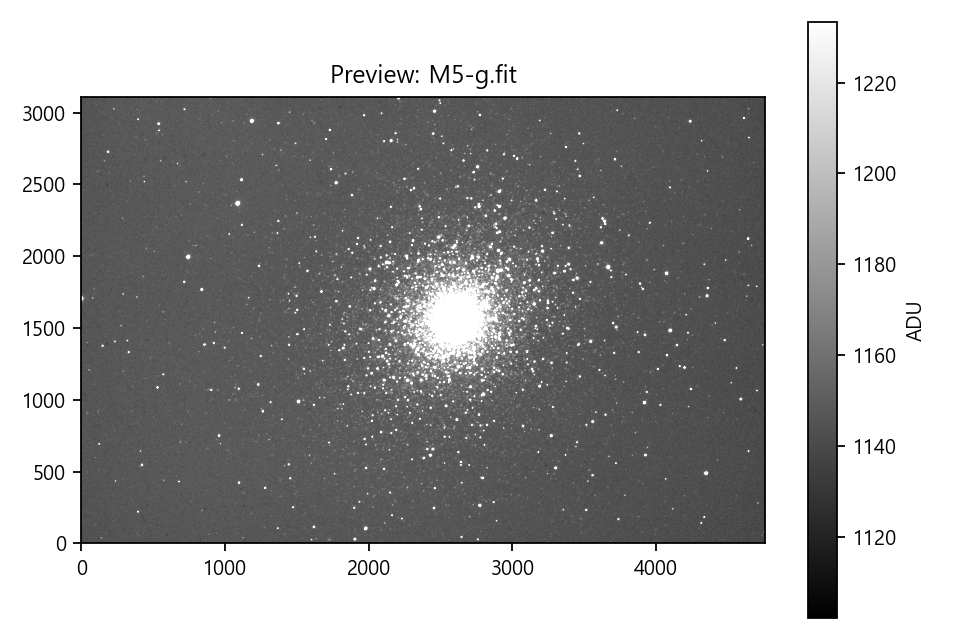

In [9]:
# === Cell 3: 간단 프리뷰 (첫 이미지) ===
from astropy.visualization import ZScaleInterval, ImageNormalize
fname0 = filenames[0]
img0 = fits.getdata(DATA_DIR / fname0)
vmin, vmax = ZScaleInterval().get_limits(img0)
plt.figure(figsize=(6,4), dpi=160)
plt.imshow(img0, cmap="gray", origin="lower", norm=ImageNormalize(vmin=vmin, vmax=vmax))
plt.title(f"Preview: {fname0}")
plt.colorbar(label="ADU"); plt.tight_layout(); plt.show()


In [10]:
# === Cell 4: 정렬 & 저장 (r_*) — getattr 가드/필터표시/캐시스킵 보강 ===
import os
from pathlib import Path
import astroalign as aa
from astropy.io import fits

# ---- guards & switches ----
DO_ALIGN       = bool(getattr(P, "do_align", True))
RESUME         = bool(getattr(P, "resume_mode", True))
FORCE_REALIGN  = bool(getattr(P, "force_realign", False))

# 입력 목록/기준 프레임 체크
assert 'filenames' in globals() and len(filenames) > 0, "정렬 대상 filenames 가 비었습니다."
assert 'ref_name'  in globals(), "기준 프레임 ref_name 이 정의되어야 합니다."

# 기준 프레임 로드
ref_path = DATA_DIR / ref_name
ref_img = fits.getdata(ref_path).byteswap().newbyteorder()

# 기준 필터 라벨( df_headers → FITS 헤더 → 헬퍼 순 )
try:
    if 'df_headers' in globals() and (not df_headers.empty):
        _idxed = df_headers.set_index('Filename')
        _filt  = _idxed.loc[ref_name, 'FILTER'] if ref_name in _idxed.index else None
        REF_FILTER = str(_filt).strip() if _filt is not None else None
    else:
        REF_FILTER = None
except Exception:
    REF_FILTER = None

if not REF_FILTER:
    try:
        REF_FILTER = fits.getheader(ref_path).get("FILTER", None)
    except Exception:
        REF_FILTER = None
if not REF_FILTER:
    # Cell 0의 헬퍼
    REF_FILTER = get_filter_from_fits(ref_path)

print(f"기준 프레임: {ref_name} (FILTER={REF_FILTER})")

# 로그 준비
log = TailLogger(CACHE_DIR/"align.log", tail=getattr(P, "ui_log_tail", 5), enable_console=True)
aligned_made = 0
skipped      = 0  # 캐시 스킵 카운트

# 정렬 루프
for fn in filenames:
    src = DATA_DIR / fn
    out = RESULT_DIR / f"r_{fn}"

    # 캐시 스킵
    can_skip = False
    if RESUME and (not FORCE_REALIGN) and out.exists():
        try:
            with fits.open(out) as hdul:
                hdr = hdul[0].header
                cond = (bool(hdr.get("REG_DONE", False))
                        and hdr.get("REG_REF","") == ref_name
                        and hdr.get("PARAMH","") == PARAM_HASH
                        and hdr.get("CODEVER","") == CODE_VER)
            if cond and _is_up_to_date(out, [src]):
                log.write(f"↩︎ skip align: {out.name} (up-to-date)")
                can_skip = True
                skipped += 1
        except Exception:
            pass
    if can_skip:
        continue

    try:
        if DO_ALIGN:
            img = fits.getdata(src).byteswap().newbyteorder()
            aligned, _ = aa.register(img, ref_img)
            with fits.open(src) as hdul:
                hdr = hdul[0].header.copy()
            hdr["REG_DONE"] = (True, "aligned by astroalign")
            hdr["REG_REF"]  = (ref_name, "alignment reference filename")
            hdr["PARAMH"]   = (PARAM_HASH, "parameter hash")
            hdr["CODEVER"]  = (CODE_VER, "pipeline code version")
            fits.PrimaryHDU(aligned.astype(img.dtype), header=hdr).writeto(out, overwrite=True)
            aligned_made += 1
            log.write(f"✅ 정렬: {fn} -> {out.name}")
        else:
            # 정렬 OFF: 원본 복사 + 헤더 표기
            with fits.open(src) as hdul:
                hdr = hdul[0].header.copy()
                data0 = hdul[0].data
            hdr["REG_DONE"] = (True, "copied without alignment")
            hdr["REG_REF"]  = (ref_name, "")
            hdr["PARAMH"]   = (PARAM_HASH, "parameter hash")
            hdr["CODEVER"]  = (CODE_VER, "pipeline code version")
            fits.PrimaryHDU(data0, header=hdr).writeto(out, overwrite=True)
            log.write(f"⤴️ 복사: {fn} -> {out.name}")
    except Exception as e:
        log.write(f"⚠️ 정렬 실패 {fn}: {e}")

log.close()

# 산출 목록 갱신
r_filenames = sorted([
    f for f in os.listdir(RESULT_DIR)
    if f.startswith("r_") and f.lower().endswith((".fit",".fits",".fit.fz",".fits.fz"))
])

print(f"정렬 결과: {len(r_filenames)} (새 처리 {aligned_made}개, 캐시스킵 {skipped}개) | 로그: {CACHE_DIR/'align.log'}")




[19:37:15] ✅ 정렬: M5-g.fit -> r_M5-g.fit
[19:37:22] ✅ 정렬: M5-i.fit -> r_M5-i.fit
[19:37:30] ✅ 정렬: M5-r.fit -> r_M5-r.fit
정렬 결과: 3 (새 처리 3개, 캐시스킵 0개) | 로그: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\cache\align.log


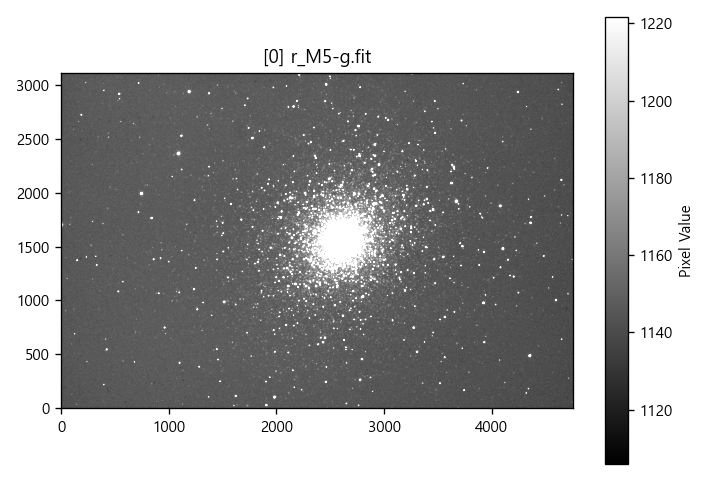

In [11]:
# === Cell 5: 정렬 미리보기 (작게) ===
if not r_filenames:
    raise RuntimeError("result/에 r_*.fits 없음")

idx = max(0, min(getattr(P, "inspect_index", 0), len(r_filenames)-1))
fname = r_filenames[idx]
img = fits.getdata(RESULT_DIR / fname)

interval = ZScaleInterval(); vmin, vmax = interval.get_limits(img)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(6,4), dpi=DPI)
plt.imshow(img, cmap="gray", origin="lower", norm=norm)
plt.colorbar(label="Pixel Value")
plt.title(f"[{idx}] {fname}")
plt.tight_layout(); plt.show()


In [12]:
# === Cell 5C: CROP 선택/저장 (rect만; resume 시 스킵) ===
from ipywidgets import HTML, VBox
from matplotlib.widgets import RectangleSelector

if not r_filenames:
    raise RuntimeError("r_*.fits가 없습니다. 4 셀 먼저 실행하세요.")

crop_path    = RESULT_DIR / "crop_rect.json"
RESUME       = bool(getattr(P, "resume_mode", True))
FORCE_RECROP = bool(getattr(P, "force_recrop", False))

# 이미 crop_rect.json 있고 rc_*도 있으면, 기본적으로 다시 그리지 않고 그대로 사용
has_rc = any(
    f.startswith("rc_") and f.lower().endswith((".fit", ".fits", ".fit.fz", ".fits.fz"))
    for f in os.listdir(RESULT_DIR)
)

if RESUME and (not FORCE_RECROP) and crop_path.exists() and has_rc:
    try:
        crop = json.loads(crop_path.read_text(encoding="utf-8"))
        print(f"↩︎ 기존 CROP 유지 (crop_rect.json 재사용): {crop_path}")
        print(
            f"   x=[{crop.get('x0')}:{crop.get('x1')}) "
            f"y=[{crop.get('y0')}:{crop.get('y1')})  ref_file={crop.get('ref_file')}"
        )
    except Exception:
        print(f"↩︎ 기존 crop_rect.json 유지: {crop_path}")
else:
    # 새 rect 선택 UI
    ref_idx  = max(0, min(getattr(P, "align_ref_index", 0), len(r_filenames)-1))
    ref_file = r_filenames[ref_idx]
    img = fits.getdata(RESULT_DIR / ref_file).astype(float)

    interval = ZScaleInterval(); vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)

    plt.ioff()
    fig, ax = plt.subplots(figsize=(7,7), dpi=110)
    im = ax.imshow(img, cmap="gray", origin="lower", norm=norm)
    ax.set_title(f"[CROP 선택] {ref_file} — 드래그 후 Enter 저장", fontsize=11)

    CROP = {
        "x0": 0,
        "y0": 0,
        "x1": img.shape[1],
        "y1": img.shape[0],
        "ref_file": ref_file,
    }

    def onselect(eclick, erelease):
        if (eclick.xdata is None) or (erelease.xdata is None):
            return
        x0 = int(min(eclick.xdata, erelease.xdata))
        x1 = int(max(eclick.xdata, erelease.xdata))
        y0 = int(min(eclick.ydata,  erelease.ydata))
        y1 = (int(max(erelease.ydata, eclick.ydata))
              if erelease.ydata < eclick.ydata
              else int(max(eclick.ydata, erelease.ydata)))

        H, W = img.shape
        x0 = max(0, min(W-1, x0)); x1 = max(1, min(W, x1))
        y0 = max(0, min(H-1, y0)); y1 = max(1, min(H, y1))

        CROP.update(dict(x0=x0, y0=y0, x1=x1, y1=y1))
        info.value = (
            f"선택: x=[{x0}:{x1}) y=[{y0}:{y1}) → W={x1-x0}, H={y1-y0}"
        )

    def on_key(event):
        if event.key in ("enter", "return"):
            out = crop_path
            out.write_text(
                json.dumps(CROP, indent=2, default=_jsonify),
                encoding="utf-8"
            )
            info.value = (
                f"✅ CROP 저장: {out}  "
                f"(x0={CROP['x0']}, y0={CROP['y0']}, "
                f"x1={CROP['x1']}, y1={CROP['y1']})"
            )
            print(info.value)

    selector = RectangleSelector(
        ax, onselect, useblit=True, button=[1],
        minspanx=5, minspany=5, spancoords='pixels', interactive=True,
        props=dict(edgecolor='orange', facecolor='none', linewidth=1.2)
    )
    fig.canvas.mpl_connect("key_press_event", on_key)

    info = HTML("<b>Tip:</b> 마우스로 드래그 → <b>Enter</b>로 확정/저장 (crop_rect.json)")

    from IPython.display import display
    if HAS_IPYMPL:
        display(VBox([info, fig.canvas]))
    else:
        display(info); display(fig)
    plt.ion()


↩︎ 기존 CROP 유지 (crop_rect.json 재사용): C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\crop_rect.json
   x=[77:4686) y=[86:3077)  ref_file=r_M5-g.fit


In [13]:
# === Cell 5C-APPLY: rc_* 생성 (crop_rect.json 적용 + resume 스킵) ===
crop_path = RESULT_DIR / "crop_rect.json"
if not crop_path.exists():
    raise FileNotFoundError("crop_rect.json이 없습니다. 5C에서 먼저 저장하세요.")

crop = json.loads(crop_path.read_text(encoding="utf-8"))
x0, y0, x1, y1 = int(crop["x0"]), int(crop["y0"]), int(crop["x1"]), int(crop["y1"])
W = x1 - x0
H = y1 - y0
if W <= 10 or H <= 10:
    raise RuntimeError(f"CROP이 너무 작음: W={W}, H={H}")

RESUME       = bool(getattr(P, "resume_mode", True))
FORCE_RECROP = bool(getattr(P, "force_recrop", False))

log = TailLogger(CACHE_DIR/"crop.log",
                 tail=getattr(P, "ui_log_tail", 5),
                 enable_console=True)
rc_filenames = []

for fn in r_filenames:
    src = RESULT_DIR / fn

    # r_*.fits → rc_*.fits 로만 생성 (r_pp → rc_pp)
    if fn.startswith("r_"):
        out = RESULT_DIR / f"rc_{fn[2:]}"   # r_* -> rc_*
    else:
        # 이미 rc_* 등인 경우 이름 그대로 사용 (재실행 방지용)
        out = RESULT_DIR / fn

    # resume_mode에서, 이미 같은 파라미터/코드/rect로 만든 rc_*면 스킵
    can_skip = False
    if RESUME and (not FORCE_RECROP) and out.exists():
        try:
            with fits.open(out) as hdul:
                hdr_out = hdul[0].header
                cond = (
                    bool(hdr_out.get("RC_DONE", False)) and
                    hdr_out.get("RC_SRC", "") == fn and
                    hdr_out.get("PARAMH", "") == PARAM_HASH and
                    hdr_out.get("CODEVER", "") == CODE_VER
                )
                if cond and _is_up_to_date(out, [src, crop_path]):
                    log.write(f"↩︎ skip crop: {out.name} (up-to-date)")
                    rc_filenames.append(out.name)
                    can_skip = True
        except Exception:
            pass
    if can_skip:
        continue

    try:
        with fits.open(src) as hdul:
            data = hdul[0].data
            hdr  = hdul[0].header.copy()

        if data.ndim != 2:
            log.write(f"⚠️ skip {fn}: 2D 아님({data.ndim}D)")
            continue

        H0, W0 = data.shape
        xa0, xa1 = max(0, x0), min(W0, x1)
        ya0, ya1 = max(0, y0), min(H0, y1)
        if (xa1 - xa0) <= 0 or (ya1 - ya0) <= 0:
            log.write(f"⚠️ skip {fn}: CROP 범위 밖")
            continue

        crop_img = data[ya0:ya1, xa0:xa1]

        if "CRPIX1" in hdr and "CRPIX2" in hdr:
            hdr["CRPIX1"] = float(hdr["CRPIX1"]) - xa0
            hdr["CRPIX2"] = float(hdr["CRPIX2"]) - ya0
        hdr["NAXIS1"] = crop_img.shape[1]
        hdr["NAXIS2"] = crop_img.shape[0]

        # crop 메타데이터 (align 셀과 동일한 PARAMH/CODEVER 사용)
        hdr["RC_DONE"] = (True, "cropped from aligned frame")
        hdr["RC_SRC"]  = (fn,   "source aligned filename")
        hdr["PARAMH"]  = (PARAM_HASH, "parameter hash")
        hdr["CODEVER"] = (CODE_VER,   "pipeline code version")

        fits.PrimaryHDU(
            crop_img.astype(data.dtype),
            header=hdr
        ).writeto(out, overwrite=True)

        rc_filenames.append(out.name)
        log.write(f"✂️  {fn}  →  {out.name}  ({xa0}:{xa1}, {ya0}:{ya1})")
    except Exception as e:
        log.write(f"⚠️ 실패 {fn}: {e}")

log.close()

# 이후 단계에서 rc_*만 쓰도록 r_filenames 갱신
r_filenames = sorted([
    f for f in os.listdir(RESULT_DIR)
    if f.startswith("rc_") and f.lower().endswith((".fit", ".fits", ".fit.fz", ".fits.fz"))
])
print(f"완료: rc_* {len(r_filenames)}개 | 전체 로그: {CACHE_DIR/'crop.log'}")


[19:37:32] ✂️  r_M5-g.fit  →  rc_M5-g.fit  (77:4686, 86:3077)
[19:37:33] ✂️  r_M5-i.fit  →  rc_M5-i.fit  (77:4686, 86:3077)
[19:37:33] ✂️  r_M5-r.fit  →  rc_M5-r.fit  (77:4686, 86:3077)
완료: rc_* 3개 | 전체 로그: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\cache\crop.log


In [14]:
# === Cell 5X: Sky/Focus HUD (zscale only, wheel zoom, thin overlay, full stats) ===
import json, math, html, types
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import HTML, VBox, HBox, Layout, Output
from IPython.display import display
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from astropy.io import fits

# --------- params / const ----------
F5X = types.SimpleNamespace(
    ap_scale=float(getattr(P,"5x.aperture_scale",1.0) or 1.0),
    cbox_scale=float(getattr(P,"5x.center_cbox_scale",1.5) or 1.5),
    ann_in_scale=float(getattr(P,"5x.annulus_in_scale",4.0) or 4.0),
    ann_out_scale=float(getattr(P,"5x.annulus_out_scale",2.0) or 2.0),
    min_r_ap_px=float(getattr(P,"5x.min_r_ap_px",4.0) or 4.0),
    min_r_in_px=float(getattr(P,"5x.min_r_in_px",12.0) or 12.0),
    min_r_out_px=float(getattr(P,"5x.min_r_out_px",20.0) or 20.0),
    sigma_clip=float(getattr(P,"5x.sigma_clip",3.0) or 3.0),
    neighbor_scale=float(getattr(P,"5x.neighbor_mask_scale",1.3) or 1.3),
    mag_flux=str(getattr(P,"5x.mag_flux","rate_e") or "rate_e").lower(),
    use_header_exptime=bool(str(getattr(P,"5x.use_header_exptime","true")).strip().lower() in ("1","true","y","yes")),
)
GAIN = float(getattr(P,"gain_e_per_adu",1.0))
RN_PARM = float(getattr(P,"rdnoise_e",7.5))  # parameter(비교용)
ZP   = float(getattr(P,"zp_initial",25.0))
ANN_GAP   = float(getattr(P,"annulus_min_gap_px",6.0))
ANN_MINW  = float(getattr(P,"annulus_min_width_px",12.0))
FWHM_SEED = float(getattr(P,"fwhm_seed_px",6.0))
PS_ARCSEC = float(getattr(P,"pixel_scale_arcsec", np.nan) or np.nan)

# CSV 로그(옵션): 클릭 측정값 누적
F5X_LOG = RESULT_DIR / "5x_measurements.csv"
if not F5X_LOG.exists():
    F5X_LOG.write_text(
        "file,x,y,exptime,sky_min_adu,sky_med_adu,sky_max_adu,"
        "pix_min_adu,pix_med_adu,pix_max_adu,"
        "fwhm_px,fwhm_arcsec,rdnoise_est_e,snr,mag,mag_err\n",
        encoding="utf-8"
    )

# ---------- small utils ----------
def _html(text:str):
    return "<div style='white-space:pre-wrap;word-break:break-word;" \
           "font-family:ui-monospace,Consolas,monospace;font-size:12px;line-height:1.28'>" \
           + html.escape(text).replace("\n","<br>") + "</div>"

def _filter_label(fn):
    return get_filter_from_fits(RESULT_DIR / fn).lower()

def _norm_zscale(img):
    arr = np.asarray(img, float)
    finite = np.isfinite(arr)
    if not finite.any():
        return ImageNormalize(vmin=0, vmax=1)
    v0, v1 = ZScaleInterval().get_limits(arr[finite])
    return ImageNormalize(vmin=float(v0), vmax=float(v1))

def _disp_image_for(img):
    disp = img.astype(float, copy=True)
    if not np.isfinite(disp).any():
        return np.zeros_like(disp)
    if np.isnan(disp).mean() > 0.5:
        med = np.nanmedian(disp)
        disp = np.where(np.isfinite(disp), disp, med)
    return disp

def _get_exptime(path):
    return (get_exptime_from_fits(path, default=1.0)
            if F5X.use_header_exptime else 1.0)

def _circle_mask(shape, cx, cy, r):
    H, W = shape
    y = np.arange(H)[:,None]; x = np.arange(W)[None,:]
    return (x-cx)**2 + (y-cy)**2 <= (r*r)

def _recenter(img, x, y, fwhm):
    H, W = img.shape
    r = int(max(F5X.cbox_scale * max(fwhm, 2.0), 6.0))
    xi, yi = int(round(x)), int(round(y))
    x0,x1 = max(0,xi-r), min(W,xi+r+1)
    y0,y1 = max(0,yi-r), min(H,yi+r+1)
    if (x1-x0)<9 or (y1-y0)<9: return None
    cut = img[y0:y1, x0:x1]
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0)
    Z = cut - med; Z[~np.isfinite(Z)] = 0.0; Z[Z<0] = 0.0
    S = np.nansum(Z)
    if S <= 0: return None
    yy,xx = np.mgrid[y0:y1, x0:x1]
    xc = float(np.nansum(xx*Z)/S); yc = float(np.nansum(yy*Z)/S)
    return xc, yc

def _annulus_stats(img, xc, yc, fwhm):
    r_ap  = max(F5X.ap_scale * fwhm, F5X.min_r_ap_px)
    r_in  = max(F5X.ann_in_scale * fwhm, r_ap + ANN_GAP, F5X.min_r_in_px)
    r_out = max(r_in + F5X.ann_out_scale * fwhm, r_in + ANN_MINW, F5X.min_r_out_px)

    # annulus 값 추출 (클리핑)
    ann_mask = _circle_mask(img.shape, xc, yc, r_out) & (~_circle_mask(img.shape, xc, yc, r_in))
    vals = img[ann_mask]; vals = vals[np.isfinite(vals)]

    n_sky = 0
    sky_min=sky_med=sky_max=sky_std=np.nan
    if vals.size:
        sc = SigmaClip(F5X.sigma_clip, maxiters=int(getattr(P,"fitsky_max_iter",5)))
        v_cl = sc(vals)
        vv = v_cl.compressed() if np.ma.isMaskedArray(v_cl) else np.asarray(v_cl)
        vv = vv[np.isfinite(vv)]
        n_sky = int(vv.size)
        if n_sky:
            sky_min = float(np.nanmin(vv))
            sky_med = float(np.nanmedian(vv))
            sky_max = float(np.nanmax(vv))
            # robust std: max(std, MAD)
            std_lin = float(np.nanstd(vv, ddof=1)) if n_sky>1 else 0.0
            mad = 1.4826*float(np.nanmedian(np.abs(vv - sky_med))) if n_sky>0 else 0.0
            sky_std = float(max(std_lin, mad))

    return dict(r_ap=r_ap, r_in=r_in, r_out=r_out,
                sky_min=sky_min, sky_med=sky_med, sky_max=sky_max,
                sky_std=sky_std, n_sky=n_sky)

def _radial_fwhm(img, xc, yc, seed_fwhm_px, ann_in_scale, ann_out_scale,
                 sigma=3.0, maxiters=5, dr=0.5):
    """라디얼 프로파일 기반 FWHM (배경=annulus median)."""
    # annulus로 배경 추정
    r_in  = max(ann_in_scale*seed_fwhm_px, F5X.min_r_in_px)
    r_out = max(r_in + ann_out_scale*seed_fwhm_px, r_in + ANN_MINW, F5X.min_r_out_px)
    ann_mask = _circle_mask(img.shape, xc, yc, r_out) & (~_circle_mask(img.shape, xc, yc, r_in))
    vals = img[ann_mask]; vals = vals[np.isfinite(vals)]
    if vals.size:
        sc = SigmaClip(sigma=sigma, maxiters=maxiters)
        vv = sc(vals); vv = vv.compressed() if np.ma.isMaskedArray(vv) else np.asarray(vv)
        vv = vv[np.isfinite(vv)]
        sky_med = float(np.nanmedian(vv)) if vv.size else float(np.nanmedian(vals))
        sky_std = float(np.nanstd(vv, ddof=1)) if vv.size>1 else float(np.nanstd(vals, ddof=1)) if vals.size>1 else 0.0
    else:
        sky_med=0.0; sky_std=0.0

    H,W = img.shape
    rmax = int(max(6.0*seed_fwhm_px, r_out + 6.0))
    xi, yi = int(round(xc)), int(round(yc))
    x0,x1 = max(0, xi-rmax), min(W, xi+rmax+1)
    y0,y1 = max(0, yi-rmax), min(H, yi+rmax+1)
    cut = img[y0:y1, x0:x1].astype(float)
    yy,xx = np.mgrid[y0:y1, x0:x1]
    rr = np.hypot(xx-xc, yy-yc); val = cut - sky_med
    edges = np.arange(0.0, rmax+dr, dr); centers = 0.5*(edges[:-1]+edges[1:])
    prof = np.full_like(centers, np.nan, dtype=float)
    for i in range(len(centers)):
        a = (rr>=edges[i]) & (rr<edges[i+1])
        if np.any(a):
            vv = val[a]; vv = vv[np.isfinite(vv)]
            if vv.size: prof[i] = float(np.mean(vv))
    if not np.isfinite(prof).any(): 
        return np.nan, sky_med, sky_std
    k_peak = int(max(2, np.round(1.5*seed_fwhm_px/max(dr,1e-9))))
    use_slice = prof[:min(k_peak, len(prof))]
    peak = np.nanmax(use_slice) if np.isfinite(use_slice).any() else np.nanmax(prof)
    if not (np.isfinite(peak) and peak>0): 
        return np.nan, sky_med, sky_std
    half = 0.5*peak
    idx = np.where((prof[:-1] >= half) & (prof[1:] < half))[0]
    if len(idx)==0: 
        return np.nan, sky_med, sky_std
    i = int(idx[0]); x1_, y1_ = centers[i], prof[i]; x2_, y2_ = centers[i+1], prof[i+1]
    if not (np.isfinite(y1_) and np.isfinite(y2_) and (y1_!=y2_)):
        return np.nan, sky_med, sky_std
    r_half = x1_ + (half - y1_) * (x2_ - x1_) / (y2_ - y1_)
    return 2.0*float(r_half), sky_med, sky_std

# ---- UI setup ----
assert 'r_filenames' in globals() and len(r_filenames) > 0, "rc_* 프레임이 필요합니다."
plt.ioff()
fig, ax = plt.subplots(figsize=(7,7), dpi=115)
try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception: pass
try: fig.canvas.header_visible=False
except Exception: pass

cur_idx = max(0, min(int(getattr(P, "inspect_index", 0)), len(r_filenames)-1))
hud = HTML(layout=Layout(width="100%", height="132px"))
log_out = Output(layout=Layout(width='520px', height='740px', overflow='auto', border='1px solid #444'))

_LOG_BUF, _LOG_TAIL = [], int(getattr(P,"ui_log_tail",300))
def _log(msg):
    _LOG_BUF.insert(0, msg)
    with log_out:
        from IPython.display import clear_output
        clear_output(wait=True)
        for line in _LOG_BUF[:_LOG_TAIL]:
            print(line)

def _hud(text): hud.value = _html(text)

def _load(idx):
    name = r_filenames[idx]
    raw = fits.getdata(RESULT_DIR / name).astype(float)
    disp = _disp_image_for(raw)
    ax.clear()
    ax.imshow(disp, origin="lower", cmap=CM_GRAY, norm=_norm_zscale(disp), interpolation='none')
    ax.set_title(f"[{idx}] {name} — Sky/Focus probe (zscale) | filter={_filter_label(name)}", fontsize=11)
    fig.canvas.draw_idle()
    return name, raw

rc_name, img = _load(cur_idx)
help_text = "[ ] 프레임 이동   . 다음 필터   m 측정   h 도움말   q 닫기   (휠=줌)"
_hud(help_text)

def _jump_filter(idx, order=("g","r","i")):
    cur_f = _filter_label(r_filenames[idx])
    next_f = order[(order.index(cur_f)+1) % len(order)] if cur_f in order else cur_f
    cand = [k for k,fn in enumerate(r_filenames) if _filter_label(fn)==next_f]
    return (min(cand, key=lambda k: abs(k-idx)) if cand else (idx+1) % len(r_filenames))

# ---- overlay (얇은 선) ----
CROSS_LW = 0.6
AP_LW    = 0.8
xc_overlay = yc_overlay = None
ap_artist = ann_in_art = ann_out_art = None
cross_v = cross_h = None

def _init_overlay(xc, yc, r_ap, r_in, r_out):
    global cross_v, cross_h, ap_artist, ann_in_art, ann_out_art, xc_overlay, yc_overlay
    xc_overlay, yc_overlay = xc, yc
    cross_v = ax.plot([xc, xc], [yc-15, yc+15], lw=CROSS_LW, color="tab:cyan")[0]
    cross_h = ax.plot([xc-15, xc+15], [yc, yc], lw=CROSS_LW, color="tab:cyan")[0]
    ap_artist  = plt.Circle((xc,yc), r_ap,  fill=False, lw=AP_LW, ec="tab:orange")
    ann_in_art = plt.Circle((xc,yc), r_in,  fill=False, lw=AP_LW*0.9, ec="tab:green", ls=":")
    ann_out_art= plt.Circle((xc,yc), r_out, fill=False, lw=AP_LW*0.9, ec="tab:green", ls=":")
    for art in (ap_artist, ann_in_art, ann_out_art):
        ax.add_patch(art)
    fig.canvas.draw_idle()

def _update_overlay(xc, yc, r_ap, r_in, r_out):
    if cross_v is None: return
    cross_v.set_data([xc, xc], [yc-15, yc+15])
    cross_h.set_data([xc-15, xc+15], [yc, yc])
    for c, r in [(ap_artist,r_ap),(ann_in_art,r_in),(ann_out_art,r_out)]:
        c.center=(xc,yc); c.set_radius(r)
    fig.canvas.draw_idle()

# ---- mouse wheel zoom ----
def _on_scroll(event):
    if event.inaxes != ax: return
    base = 1.2
    s = 1/base if event.button == 'up' else base
    x0,x1 = ax.get_xlim(); y0,y1 = ax.get_ylim()
    x = event.xdata if event.xdata is not None else 0.5*(x0+x1)
    y = event.ydata if event.ydata is not None else 0.5*(y0+y1)
    w = (x1-x0)*s; h = (y1-y0)*s
    rx = (x-x0)/(x1-x0); ry = (y-y0)/(y1-y0)
    ax.set_xlim([x - w*rx, x + w*(1-rx)])
    ax.set_ylim([y - h*ry, y + h*(1-ry)])
    fig.canvas.draw_idle()
fig.canvas.mpl_connect("scroll_event", _on_scroll)

# ---- key handler ----
def on_key(e):
    global cur_idx, rc_name, img, xc_overlay, yc_overlay
    if e.key == "q":
        _hud(help_text+"\n종료"); plt.close(fig); return
    if e.key == "h":
        _hud(help_text+"\n[m] 지점에서 중심 재탐색 → 통계/FWHM/SNR/등급 표시 & 로그 저장")
        return
    if e.key == "[":
        cur_idx = (cur_idx - 1) % len(r_filenames); rc_name, img = _load(cur_idx); return
    if e.key == "]":
        cur_idx = (cur_idx + 1) % len(r_filenames); rc_name, img = _load(cur_idx); return
    if e.key == ".":
        cur_idx = _jump_filter(cur_idx); rc_name, img = _load(cur_idx); return
    if (e.inaxes != ax) or (e.xdata is None) or (e.ydata is None):
        return

    if e.key == "m":
        # 중심 재탐색
        rc = _recenter(img, float(e.xdata), float(e.ydata), FWHM_SEED)
        if rc is None:
            _hud(help_text+"\n측정 실패: 신호 없음"); _log("[m] 측정 실패"); return
        xc, yc = rc

        # 반경/배경 통계
        meta = _annulus_stats(img, xc, yc, FWHM_SEED)
        r_ap, r_in, r_out = meta["r_ap"], meta["r_in"], meta["r_out"]

        # 오버레이(처음이면 생성)
        if ap_artist is None:
            _init_overlay(xc, yc, r_ap, r_in, r_out)
        else:
            _update_overlay(xc, yc, r_ap, r_in, r_out)

        # 아퍼처 합/픽셀 통계
        ap = CircularAperture((xc, yc), r=r_ap)
        ap_mask = _circle_mask(img.shape, xc, yc, r_ap)
        pix_vals = img[ap_mask]; pix_vals = pix_vals[np.isfinite(pix_vals)]
        pix_min = float(np.nanmin(pix_vals)) if pix_vals.size else np.nan
        pix_med = float(np.nanmedian(pix_vals)) if pix_vals.size else np.nan
        pix_max = float(np.nanmax(pix_vals)) if pix_vals.size else np.nan
        st_ap = ApertureStats(img, ap, sigma_clip=SigmaClip(F5X.sigma_clip, maxiters=int(getattr(P,"fitsky_max_iter",5))))
        ap_sum  = float(st_ap.sum or 0.0)
        ap_area = float(np.count_nonzero(ap_mask))

        # 배경 값들
        sky_min = float(meta["sky_min"]); sky_med = float(meta["sky_med"]); sky_max = float(meta["sky_max"])
        bkg_std = float(meta["sky_std"]); n_sky = int(meta["n_sky"])

        # FWHM (px/arcsec)
        fwhm_px, _, _ = _radial_fwhm(
            img, xc, yc, max(FWHM_SEED,2.0),
            F5X.ann_in_scale, F5X.ann_out_scale,
            sigma=F5X.sigma_clip, maxiters=int(getattr(P,"fitsky_max_iter",5)), dr=0.5
        )
        fwhm_arc = (fwhm_px*PS_ARCSEC) if (np.isfinite(PS_ARCSEC) and np.isfinite(fwhm_px)) else np.nan

        # Photometry & SNR (Cell 11과 동일식)
        exptime = _get_exptime(RESULT_DIR / rc_name)
        flux_net_adu = ap_sum - sky_med * ap_area
        flux_e = max(flux_net_adu, 0.0) * GAIN

        sigma_pix_e2 = (bkg_std * GAIN)**2
        var_e = (flux_e
                 + ap_area * sigma_pix_e2
                 + (ap_area**2 / max(n_sky,1)) * sigma_pix_e2)
        sigma_e = math.sqrt(max(var_e, 0.0))
        snr = (flux_e / sigma_e) if sigma_e>0 else 0.0

        # RDNOISE 추정 (1픽셀 분산에서 μ_e 제거)
        mu_e = max(sky_med, 0.0) * GAIN
        rn2 = sigma_pix_e2 - mu_e
        rn_est = math.sqrt(rn2) if rn2 > 1e-12 else 0.0

        # 등급(m, merr)
        if "rate" in F5X.mag_flux and exptime>0:
            rate = (flux_e/exptime)
            mag = -2.5*math.log10(rate) + ZP if rate>0 else np.nan
            # sigma_rate/rate == sigma_e/flux_e (exptime 상쇄)
            mag_err = 1.0857 * (sigma_e/max(flux_e,1e-30))
        else:
            mag = -2.5*math.log10(max(flux_e,1e-30)) + ZP if flux_e>0 else np.nan
            mag_err = 1.0857 * (sigma_e/max(flux_e,1e-30))

        # HUD 표시(요청 컬럼들만 전면)
        txt = (
            f"(x,y)=({xc:.2f},{yc:.2f})   FWHM={fwhm_px:.2f}px"
            + (f" ({fwhm_arc:.2f}\")" if np.isfinite(fwhm_arc) else "")
            + f"\nSNR={snr:.2f}   m={mag:.3f}±{(mag_err if np.isfinite(mag_err) else np.nan):.3f}"
            f"\nsky[min/med/max]={sky_min:.2f}/{sky_med:.2f}/{sky_max:.2f} ADU"
            f"   pix[min/med/max]={pix_min:.2f}/{pix_med:.2f}/{pix_max:.2f} ADU"
            f"\nRDNOISE(est)={rn_est:.3f} e⁻ (param={RN_PARM:.2f})"
        )
        _hud(help_text+"\n"+txt)
        _log("[m] "+txt)

        # CSV 누적 저장(소수점 유지)
        with open(F5X_LOG, "a", encoding="utf-8") as fh:
            fh.write(
                f"{rc_name},{xc:.3f},{yc:.3f},{exptime:.4f},"
                f"{sky_min:.6g},{sky_med:.6g},{sky_max:.6g},"
                f"{pix_min:.6g},{pix_med:.6g},{pix_max:.6g},"
                f"{(fwhm_px if np.isfinite(fwhm_px) else np.nan):.6g},"
                f"{(fwhm_arc if np.isfinite(fwhm_arc) else np.nan):.6g},"
                f"{rn_est:.6g},{snr:.6g},{mag:.6g},{(mag_err if np.isfinite(mag_err) else np.nan):.6g}\n"
            )

fig.canvas.mpl_connect("key_press_event", on_key)

# 오른쪽 패널(로그)
right = VBox([hud, log_out])
if HAS_IPYMPL:
    display(HBox([fig.canvas, right]))
else:
    display(hud); display(HBox([fig, right])); display(fig)
plt.ion()


In [15]:
# === Cell 6 — Detection (SEG+Peak) + Frame SKY SIGMA (parallel; optimized; FWHM kept) ===
import os, math, time, json, warnings, concurrent.futures as cf
import numpy as np, pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from scipy.ndimage import median_filter, binary_dilation, gaussian_filter
from scipy.spatial import cKDTree as KDTree
from photutils.segmentation import SourceCatalog, detect_sources, deblend_sources

# ---------- fallbacks ----------
try:
    TailLogger  # noqa
except NameError:
    class TailLogger:
        def __init__(self, path, tail=200, enable_console=True):
            self.path = Path(path)
            self.enable_console = enable_console
            self.path.parent.mkdir(parents=True, exist_ok=True)
        def write(self, msg):
            s = str(msg)
            try:
                with open(self.path, "a", encoding="utf-8") as f:
                    f.write(s + "\n")
            except Exception:
                pass
            if self.enable_console:
                print(s)
        def close(self):
            pass

try:
    get_filter_from_fits  # noqa
except NameError:
    def get_filter_from_fits(path):
        try:
            with fits.open(path) as hdul:
                f = hdul[0].header.get("FILTER", None)
                return str(f).strip().lower() if f is not None else "unknown"
        except Exception:
            return "unknown"

def _as_bool(x, default=False):
    if isinstance(x, bool):
        return x
    if x is None:
        return default
    if isinstance(x, (int, np.integer)):
        return bool(x)
    s = str(x).strip().lower()
    if s in ("1","true","t","yes","y","on"):
        return True
    if s in ("0","false","f","no","n","off"):
        return False
    return default

def _is_up_to_date(out_path: Path, in_paths):
    try:
        out_m = out_path.stat().st_mtime
    except Exception:
        return False
    for p in in_paths:
        try:
            if Path(p).stat().st_mtime > out_m:
                return False
        except Exception:
            return False
    return True


# resume / force (중복 정의 제거)
RESUME         = _as_bool(getattr(P, "resume_mode", True), True)
FORCE_REDETECT = _as_bool(getattr(P, "force_redetect", False), False)

GAIN    = float(getattr(P, "gain_e_per_adu", 0.1))
PIX_ARC = float(getattr(P, "pixel_scale_arcsec", 0.393))
if not np.isfinite(PIX_ARC) or PIX_ARC <= 0:
    raise RuntimeError("[Cell 6] pixel scale 미확정: Cell 1(Telescope/Camera) 먼저 실행하세요.")

sat_adu = float(getattr(P, "saturation_adu", 60000.0))

FWHM_SEED_PX = float(getattr(P, "fwhm_seed_px", 6.0))
elong_max    = float(getattr(P, "fwhm_elong_max", 1.3))
iso_min_sep  = float(getattr(P, "iso_min_sep_pix", 10.0))

ANN_IN_SC   = float(getattr(P, "fitsky_annulus_scale", 4.0))
ANN_OUT_SC  = float(getattr(P, "fitsky_dannulus_scale", 2.0))
ANN_SIGMA   = float(getattr(P, "fitsky_sigma_clip", 3.0))
ANN_MAXITER = int(getattr(P,  "fitsky_max_iter", 5))

DEBLEND_EN = _as_bool(getattr(P, "deblend_enable", True), True)
MINAREA_PX = int(getattr(P, "minarea_pix", 3))
DEBL_NTHR  = int(getattr(P, "deblend_nthresh", 64))
DEBL_CONT  = float(getattr(P, "deblend_cont", 0.0025))
SEG_DIL_R  = int(getattr(P, "segm_dilate_radius_px", 4))

# (최적화) deblend 적응형 컷/완화
DEBL_LABEL_SOFT_MAX = int(getattr(P, "deblend_label_soft_max", 3500))  # 이 이상이면 완화
DEBL_LABEL_HARD_MAX = int(getattr(P, "deblend_label_hard_max", 7000))  # 이 이상이면 스킵
DEBL_NLEVEL_SOFT    = int(getattr(P, "deblend_nlevels_soft", 32))
DEBL_CONT_SOFT      = float(getattr(P, "deblend_contrast_soft", 0.005))

# (최적화) 후보 너무 많으면 상한
DETECT_KEEP_MAX = int(getattr(P, "detect_keep_max", 6000))

# 피크 보조
PEAK_EN      = _as_bool(getattr(P, "peak_pass_enable", True), True)
PEAK_NSIG    = float(getattr(P, "peak_nsigma", 3.2))
PEAK_SCALES  = getattr(P, "peak_kernel_scales", "0.9,1.3")
if isinstance(PEAK_SCALES, str):
    PEAK_SCALES = [float(s) for s in PEAK_SCALES.split(",") if s.strip()]
PEAK_MINSEP  = float(getattr(P, "peak_min_sep_px", 4.0))
PEAK_MAXADD  = int(getattr(P, "peak_max_add", 600))
PEAK_ELONGMX = float(getattr(P, "peak_max_elong", 1.6))
PEAK_SHARPLO = float(getattr(P, "peak_sharp_lo", 0.12))

# (최적화) 이미 소스가 많으면 peak-pass 스킵 가능
PEAK_SKIP_IF_NSRC_GE = int(getattr(P, "peak_skip_if_nsrc_ge", 4500))

# QC Gate
FWHM_QC_MAX_SOURCES = int(getattr(P, "fwhm_qc_max_sources", 40))
# (최적화) FWHM 계산은 너무 많이 돌릴 필요 없음
FWHM_MEASURE_MAX = int(getattr(P, "fwhm_measure_max", 25))
FWHM_DR = float(getattr(P, "fwhm_dr", 0.5))

PX_MIN  = float(getattr(P, "fwhm_px_min", 3.5))
PX_MAX  = float(getattr(P, "fwhm_px_max", 8.0))
ARC_MIN = getattr(P, "fwhm_arcsec_min", 1.0)
ARC_MAX = getattr(P, "fwhm_arcsec_max", 4.0)

# sky sigma gate (선택)
GATE_SKY_SIGMA_MAX = getattr(P, "gate_sky_sigma_max", None)
KEEP_POS_IF_QC_FAIL = _as_bool(getattr(P, "keep_positions_if_qc_fail", True), True)

# 2D background 
BKG2D_IN_DET  = _as_bool(getattr(P, "bkg2d_in_detect", True), True)
BKG2D_BOX     = int(getattr(P, "bkg2d_box", 64))
BKG2D_DOWNSMP = int(getattr(P, "bkg2d_downsample", 4))  # (최적화) 4 권장 (큰 프레임일수록 효과 큼)

# 병렬
PAR_MODE     = str(getattr(P, "parallel_mode", "thread")).lower()  # auto | process | thread
mw           = int(getattr(P, "max_workers", 0))
MAX_WORKERS  = (mw if mw > 0 else None)
PROGRESS_BAR = _as_bool(getattr(P, "detect_progress_bar", True), True)
ui_tail      = int(getattr(P, "ui_log_tail", 300))

log    = TailLogger(CACHE_DIR/"detect.log", tail=ui_tail, enable_console=True)
skylog = TailLogger(CACHE_DIR/"sky_sigma.log", tail=ui_tail, enable_console=True)

# 출력 CSV (튜닝용 전역 하늘 σ)
sky_csv_path = RESULT_DIR / "frame_sky_sigma.csv"
if not sky_csv_path.exists():
    sky_csv_path.write_text(
        "file,sky_sigma_med_e,sky_sigma_med_adu,n_boxes,method\n",
        encoding="utf-8"
    )

print(
    "[Cell6] mode=", PAR_MODE,
    "| workers=", (MAX_WORKERS if MAX_WORKERS is not None else "auto"),
    "| bkg2d_in_detect=", BKG2D_IN_DET,
    "| deblend=", DEBLEND_EN, f"(soft>{DEBL_LABEL_SOFT_MAX}, hard>{DEBL_LABEL_HARD_MAX})",
    "| peak=", PEAK_EN,
    "| FWHM_seed_px=", FWHM_SEED_PX,
)

# ---------- helpers ----------
class PhaseBar:
    def __init__(self, fname, steps, emit):
        self.fname = fname
        self.steps = list(steps)
        self.total = max(1, len(self.steps))
        self.k = 0
        self.t0 = time.time()
        self.emit = emit
    def tick(self, label=None):
        self.k = min(self.k + 1, self.total)
        if label is None and (self.k - 1) < len(self.steps):
            label = self.steps[self.k - 1]
        bar_w = 22
        done = int(bar_w * self.k / self.total)
        rem = bar_w - done
        el = time.time() - self.t0
        self.emit(f"[{self.fname}] "
                  f"[{'#'*done}{'.'*rem}] {self.k}/{self.total} {label} | {el:5.1f}s")

def _nn_sep(xy):
    if len(xy) < 2:
        return np.array([np.inf]*len(xy))
    tree = KDTree(xy)
    d, _ = tree.query(xy, k=2)
    return d[:, 1]

def _refine_centroid(img, x, y, seed_fwhm_px):
    H, W = img.shape
    r = max(int(round(3.5*max(seed_fwhm_px, 2.0))), 8)
    xi, yi = int(round(x)), int(round(y))
    x0, x1 = max(0, xi-r), min(W, xi+r+1)
    y0, y1 = max(0, yi-r), min(H, yi+r+1)
    if (x1-x0) < 9 or (y1-y0) < 9:
        return None
    cut = img[y0:y1, x0:x1]
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0, maxiters=5, mask=~np.isfinite(cut))
    Z = cut - med
    Z[~np.isfinite(Z)] = 0.0
    Z[Z < 0] = 0.0
    S = np.nansum(Z)
    if S <= 0:
        return None
    yy, xx = np.mgrid[y0:y1, x0:x1]
    xc = float(np.nansum(xx*Z)/S)
    yc = float(np.nansum(yy*Z)/S)
    return xc, yc, float(med), float(0.0)

def _shape_metrics(img, xc, yc, seed_fwhm_px):
    H, W = img.shape
    r = max(int(round(2.5*max(seed_fwhm_px, 2.0))), 7)
    xi, yi = int(round(xc)), int(round(yc))
    x0, x1 = max(0, xi-r), min(W, xi+r+1)
    y0, y1 = max(0, yi-r), min(H, yi+r+1)
    if (x1-x0) < 7 or (y1-y0) < 7:
        return np.inf, 0.0
    cut = img[y0:y1, x0:x1].astype(float)
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0, maxiters=5, mask=~np.isfinite(cut))
    Z = cut - med
    Z[~np.isfinite(Z)] = 0.0
    Z[Z < 0] = 0.0
    S = float(np.nansum(Z))
    if S <= 0:
        return np.inf, 0.0
    yy, xx = np.mgrid[y0:y1, x0:x1]
    xbar = float(np.nansum(xx*Z)/S)
    ybar = float(np.nansum(yy*Z)/S)
    dx = xx - xbar
    dy = yy - ybar
    Ixx = float(np.nansum(Z*dx*dx)/S)
    Iyy = float(np.nansum(Z*dy*dy)/S)
    Ixy = float(np.nansum(Z*dx*dy)/S)
    w, _ = np.linalg.eigh(np.array([[Ixx, Ixy], [Ixy, Iyy]]))
    w = np.sort(np.maximum(w, 1e-12))
    elong = float(np.sqrt(w[1]/w[0]))
    cx, cy = int(round(xbar)), int(round(ybar))
    def _box_sum(R):
        xa0, xa1 = max(0, cx-R), min(W, cx+R+1)
        ya0, ya1 = max(0, cy-R), min(H, cy+R+1)
        b = img[ya0:ya1, xa0:xa1] - med
        b = np.where(np.isfinite(b), b, 0.0)
        return float(np.nansum(b[b > 0]))
    s33 = _box_sum(1)
    s55 = _box_sum(2)
    sharp = (s33/max(s55, 1e-9)) if s55 > 0 else 0.0
    return elong, sharp

def _radial_fwhm(img, xc, yc, seed_fwhm_px, ann_sigma, ann_maxiter, dr=0.5):
    from photutils.aperture import CircularAnnulus, ApertureStats
    r_in  = max(ANN_IN_SC*seed_fwhm_px, 12.0)
    r_out = max(r_in + ANN_OUT_SC*seed_fwhm_px, r_in + 12.0)
    an = CircularAnnulus((xc, yc), r_in=r_in, r_out=r_out)
    st = ApertureStats(
        img,
        an,
        mask=~np.isfinite(img),
        sigma_clip=SigmaClip(sigma=ann_sigma, maxiters=ann_maxiter),
    )
    sky_med = float(st.median)

    H, W = img.shape
    rmax = int(max(6.0*seed_fwhm_px, r_out + 6.0))
    xi, yi = int(round(xc)), int(round(yc))
    x0, x1 = max(0, xi-rmax), min(W, xi+rmax+1)
    y0, y1 = max(0, yi-rmax), min(H, yi+rmax+1)

    cut = img[y0:y1, x0:x1].astype(float)
    yy, xx = np.mgrid[y0:y1, x0:x1]
    rr = np.hypot(xx-xc, yy-yc)
    val = cut - sky_med

    edges = np.arange(0.0, rmax+dr, dr)
    centers = 0.5*(edges[:-1]+edges[1:])
    prof = np.full_like(centers, np.nan, dtype=float)

    # (최적화) bin loop는 유지하되, fwhm 대상 개수를 줄여서 전체 시간 절감
    for i in range(len(centers)):
        a = (rr >= edges[i]) & (rr < edges[i+1])
        if np.any(a):
            vv = val[a]
            vv = vv[np.isfinite(vv)]
            if vv.size:
                prof[i] = float(np.mean(vv))

    k_peak = int(max(2, np.round(1.5*seed_fwhm_px/max(dr, 1e-9))))
    use_slice = prof[:min(k_peak, len(prof))] if len(prof) else prof
    peak = np.nanmax(use_slice) if np.isfinite(use_slice).any() else np.nanmax(prof)
    if not np.isfinite(peak) or peak <= 0:
        return np.nan, sky_med, np.nan
    half = 0.5*peak
    idx = np.where((prof[:-1] >= half) & (prof[1:] < half))[0]
    if len(idx) == 0:
        return np.nan, sky_med, np.nan
    i = int(idx[0])
    x1_, y1_ = centers[i], prof[i]
    x2_, y2_ = centers[i+1], prof[i+1]
    if not (np.isfinite(y1_) and np.isfinite(y2_) and (y1_ != y2_)):
        return np.nan, sky_med, np.nan
    r_half = x1_ + (half - y1_) * (x2_ - x1_) / (y2_ - y1_)
    return 2.0*float(r_half), sky_med, np.nan

def _peak_pass_candidates(data_det, med, seed_fwhm_px):
    from photutils.detection import find_peaks
    H, W = data_det.shape
    fill = float(np.nanmedian(data_det))
    det_safe = np.where(np.isfinite(data_det), data_det, fill)
    out = []

    for s in (PEAK_SCALES or [0.9, 1.3]):
        sig = max(0.7, (s*seed_fwhm_px)/2.355)
        F = gaussian_filter(det_safe - med, sig, mode="nearest")
        _, mF, stdF = sigma_clipped_stats(F, sigma=3.0, maxiters=5)
        thr = mF + PEAK_NSIG * max(stdF, 1e-9)
        tbl = find_peaks(F, threshold=thr, box_size=9)
        if tbl is None or len(tbl) == 0:
            continue
        for r in tbl:
            x = float(r["x_peak"])
            y = float(r["y_peak"])
            rc = _refine_centroid(data_det, x, y, seed_fwhm_px)
            if rc is None:
                continue
            xc, yc, _, _ = rc
            if not (2 <= xc < W-2 and 2 <= yc < H-2):
                continue
            elong, sharp = _shape_metrics(data_det, xc, yc, seed_fwhm_px)
            if (elong <= PEAK_ELONGMX) and (sharp >= PEAK_SHARPLO):
                out.append((xc, yc))

    if not out:
        return []
    pts = np.array(out, float)
    keep = np.ones(len(pts), bool)
    tree = KDTree(pts)
    for i in range(len(pts)):
        if not keep[i]:
            continue
        j = tree.query_ball_point(pts[i], r=PEAK_MINSEP)
        for k in j:
            if k <= i:
                continue
            keep[k] = False
    pts = pts[keep]
    if len(pts) > PEAK_MAXADD:
        vals = data_det[pts[:, 1].astype(int), pts[:, 0].astype(int)]
        order = np.argsort(vals)[::-1][:PEAK_MAXADD]
        pts = pts[order]
    return [tuple(xy) for xy in pts]

def _estimate_sky_sigma_frame(
    data,
    seg_mask=None,
    gain=1.0,
    box=32,
    n=120,
    seed=12345,
    clip_sigma=3.0,
    clip_maxiters=5,
):
    H, W = data.shape
    rng = np.random.default_rng(seed)
    sky_adu = []
    for _ in range(n):
        if H < box or W < box:
            break
        y0 = int(rng.integers(0, H - box + 1))
        x0 = int(rng.integers(0, W - box + 1))
        cut = data[y0:y0+box, x0:x0+box].astype(float)
        if seg_mask is not None:
            cut = np.where(seg_mask[y0:y0+box, x0:x0+box], np.nan, cut)
        if np.count_nonzero(np.isfinite(cut)) < (box*box*0.6):
            continue
        _, _, std_adu = sigma_clipped_stats(cut, sigma=clip_sigma, maxiters=clip_maxiters)
        if np.isfinite(std_adu):
            sky_adu.append(float(std_adu))
    n_used = len(sky_adu)
    sky_med_adu = float(np.median(sky_adu)) if n_used else np.nan
    sky_med_e   = sky_med_adu * gain if np.isfinite(sky_med_adu) else np.nan
    return sky_med_e, sky_med_adu, n_used, "boxes_clip"

# ---------- worker ----------
def _process_one_frame(fname: str):
    logs = []
    def L(*a):
        logs.append(" ".join(str(x) for x in a))

    det_csv   = CACHE_DIR / f"detect_{fname}.csv"
    mask_npz  = CACHE_DIR / f"mask_{fname}.npz"
    meta_json = CACHE_DIR / f"detect_{fname}.json"

    # ---- 캐시 스킵 ----
    if RESUME and (not FORCE_REDETECT) and det_csv.exists() and meta_json.exists() and mask_npz.exists():
        try:
            up_to_date = (
                _is_up_to_date(det_csv,   [RESULT_DIR / fname]) and
                _is_up_to_date(meta_json, [RESULT_DIR / fname]) and
                _is_up_to_date(mask_npz,  [RESULT_DIR / fname])
            )
        except Exception:
            up_to_date = False

        if up_to_date:
            try:
                df_det = pd.read_csv(det_csv) if det_csv.stat().st_size > 0 else pd.DataFrame()
                positions = df_det[["x", "y"]].to_numpy(float).tolist() if {"x","y"} <= set(df_det.columns) else []
            except Exception:
                positions = []

            try:
                meta = json.loads(meta_json.read_text(encoding="utf-8"))
            except Exception:
                meta = {}

            try:
                z = np.load(mask_npz)
                seg_mask = z.get("mask", None)
            except Exception:
                seg_mask = None

            # ★ FWHM 키는 여러 버전 호환 + 폴백(seed)
            fwhm_med_px  = float(meta.get("fwhm_med_rad_px", meta.get("fwhm_med_px", np.nan)))
            if not np.isfinite(fwhm_med_px):
                fwhm_med_px = float(FWHM_SEED_PX)
            fwhm_med_arc = float(meta.get("fwhm_med_rad_arcsec", meta.get("fwhm_med_arc", fwhm_med_px*PIX_ARC)))

            passed         = bool(meta.get("passed", True))
            sky_sig_med_e  = float(meta.get("sky_sigma_med_e",   np.nan))
            sky_sig_med_adu= float(meta.get("sky_sigma_med_adu", np.nan))
            n_boxes        = int(meta.get("n_boxes", 0))
            sky_method     = meta.get("sky_method", "cached")

            L(f"↩︎ skip detect: {fname} (cache, N={len(positions)})")
            return dict(
                fname=fname, positions=positions, seg_mask=seg_mask,
                fwhm_med_px=fwhm_med_px, fwhm_med_arc=fwhm_med_arc,
                passed=passed,
                sky_sig_med_e=sky_sig_med_e, sky_sig_med_adu=sky_sig_med_adu,
                n_boxes=n_boxes, sky_method=sky_method,
                logs=logs
            )

    # ---- 실제 디텍션 ----
    steps = ["open","clip/bkg2d","smooth","threshold","segment","deblend","peak","FWHM","SKY","save"]
    pb = PhaseBar(fname, steps, emit=L) if PROGRESS_BAR else None

    data = fits.getdata(RESULT_DIR / fname, memmap=False).astype(float)
    this_filter = get_filter_from_fits(RESULT_DIR / fname)
    if pb: pb.tick("open")

    # clip
    dmin = getattr(P, "datamin_adu", None)
    dmax = getattr(P, "datamax_adu", None)
    if dmin is None: dmin = np.nanmin(data)
    if dmax is None: dmax = np.nanmax(data)

    data = data.copy()
    data[(data < float(dmin)) | (data > float(dmax))] = np.nan

    # (최적화) bkg2d: 큰 커널 median_filter는 downsample로 가속
    if BKG2D_IN_DET:
        H, W = data.shape
        fill = float(np.nanmedian(data))
        data_filled = np.where(np.isfinite(data), data, fill)

        ds = max(1, int(BKG2D_DOWNSMP))
        small = data_filled[::ds, ::ds]
        k = max(3, int(round(BKG2D_BOX / ds)))
        bkg_small = median_filter(small, size=k, mode="nearest")
        bkg = np.repeat(np.repeat(bkg_small, ds, axis=0), ds, axis=1)[:H, :W]

        data_det = data - bkg
        work = np.where(np.isfinite(data_det), data_det, 0.0)
    else:
        data_det = data
        work = np.where(np.isfinite(data_det), data_det, 0.0)
    if pb: pb.tick("clip/bkg2d")

    # stats (work 기준)
    _, med, _ = sigma_clipped_stats(work, sigma=3.0, maxiters=5)
    fwhm_seed = float(FWHM_SEED_PX)

    # (최적화) smoothing: astropy.convolve 대신 gaussian_filter 사용
    sig = max(0.8, fwhm_seed/2.355)
    fim = gaussian_filter(work - med, sig, mode="nearest")
    if pb: pb.tick("smooth")

    # threshold: detect_threshold(맵) 대신 scalar로 가볍게
    nsig = float(getattr(P, f"detect_sigma_{this_filter}", None) or getattr(P, "detect_sigma", 3.2))
    _, mF, stdF = sigma_clipped_stats(fim, sigma=3.0, maxiters=5)
    thr = mF + nsig * max(stdF, 1e-9)
    if pb: pb.tick("threshold")

    positions = []
    seg_mask  = None
    nlabels0  = 0

    try:
        segm = detect_sources(fim, threshold=thr, npixels=max(3, MINAREA_PX), connectivity=8)
        if pb: pb.tick("segment")

        # deblend 적응형
        do_deblend = (segm is not None and segm.nlabels > 0 and DEBLEND_EN)
        if segm is not None:
            nlabels0 = int(segm.nlabels)

        if do_deblend:
            if nlabels0 >= DEBL_LABEL_HARD_MAX:
                do_deblend = False
                L(fname, f": deblend SKIP (labels={nlabels0} >= {DEBL_LABEL_HARD_MAX})")
            else:
                nlev = DEBL_NTHR
                cont = DEBL_CONT
                if nlabels0 >= DEBL_LABEL_SOFT_MAX:
                    nlev = min(nlev, DEBL_NLEVEL_SOFT)
                    cont = max(cont, DEBL_CONT_SOFT)
                    L(fname, f": deblend SOFT (labels={nlabels0}) → nlevels={nlev}, cont={cont}")

                segm = deblend_sources(
                    fim, segm,
                    npixels=max(3, MINAREA_PX),
                    nlevels=int(nlev),
                    contrast=float(cont),
                )
        if pb: pb.tick("deblend")

        if segm is not None and segm.nlabels > 0:
            # (최적화) kron_flux 계산은 매우 비싸서 segment_flux만 사용
            cat = SourceCatalog(work, segm)
            tab = cat.to_table(columns=("xcentroid","ycentroid","elongation","segment_flux"))

            flux  = np.asarray(tab["segment_flux"], float)
            xcen  = np.asarray(tab["xcentroid"], float)
            ycen  = np.asarray(tab["ycentroid"], float)
            elong = np.asarray(tab["elongation"], float) if "elongation" in tab.colnames else np.ones_like(xcen)

            order = np.argsort(flux)[::-1]
            x0 = xcen[order]; y0 = ycen[order]; e0 = elong[order]
            keep = np.isfinite(x0) & np.isfinite(y0) & (e0 <= elong_max)
            x0, y0 = x0[keep], y0[keep]

            cand = np.vstack([x0, y0]).T
            if len(cand) > DETECT_KEEP_MAX:
                cand = cand[:DETECT_KEEP_MAX]

            if len(cand) > 1:
                sep = _nn_sep(cand)
                cand = cand[sep >= iso_min_sep]

            if len(cand) > 0:
                H, W = data.shape
                ix = np.clip(np.round(cand[:,0]).astype(int), 0, W-1)
                iy = np.clip(np.round(cand[:,1]).astype(int), 0, H-1)
                ok = data[iy, ix] < sat_adu
                cand = cand[ok]

            positions = list(map(tuple, cand))
            seg_mask = (segm.data > 0)
            if SEG_DIL_R > 0 and seg_mask is not None:
                seg_mask = binary_dilation(
                    seg_mask,
                    structure=np.ones((2*SEG_DIL_R+1, 2*SEG_DIL_R+1), bool),
                )

        L(fname, f": segmentation OK (N={len(positions)}) labels={nlabels0}")

    except Exception as e:
        L(fname, f": segmentation FAIL → {e}")
        positions = []
        seg_mask  = None
        if pb: pb.tick("deblend")  # 단계수 맞추기용

    # peak assist (너무 crowded면 시간절약 위해 스킵)
    added_peak = 0
    if PEAK_EN and (len(positions) < PEAK_SKIP_IF_NSRC_GE):
        try:
            peak_xy = _peak_pass_candidates(data_det, med, fwhm_seed)
            if positions:
                base = np.array(positions, float)
                treeB = KDTree(base)
                for (x, y) in peak_xy:
                    d, _ = treeB.query([x, y], k=1)
                    if d >= iso_min_sep * 0.6:
                        positions.append((float(x), float(y)))
                        added_peak += 1
            else:
                positions = [(float(x), float(y)) for (x, y) in peak_xy]
                added_peak = len(positions)
            L(fname, f": peak-assist +{added_peak}")
        except Exception as e:
            L(fname, f": peak-assist FAIL → {e}")
    else:
        if PEAK_EN:
            L(fname, f": peak-assist SKIP (N={len(positions)} >= {PEAK_SKIP_IF_NSRC_GE})")
    if pb: pb.tick("peak")

    # ---------- FWHM (절대 저장) ----------
    fwhm_fallback = False
    try:
        fwhms = []
        if len(positions) > 0:
            pts = np.array(positions, float)
            H, W = data.shape
            ix = np.clip(np.round(pts[:,0]).astype(int), 0, W-1)
            iy = np.clip(np.round(pts[:,1]).astype(int), 0, H-1)
            vals = np.where(np.isfinite(data_det[iy, ix]), data_det[iy, ix], data[iy, ix])
            order = np.argsort(vals)[::-1]
            pts = pts[order]

            n_use = min(int(FWHM_QC_MAX_SOURCES), int(FWHM_MEASURE_MAX), len(pts))
            for (x, y) in pts[:n_use]:
                rc = _refine_centroid(data, x, y, fwhm_seed)
                if rc is None:
                    continue
                xc, yc, _, _ = rc
                fpx, _, _ = _radial_fwhm(
                    data, xc, yc, max(fwhm_seed, 2.0),
                    ANN_SIGMA, ANN_MAXITER, dr=float(FWHM_DR),
                )
                if np.isfinite(fpx):
                    fwhms.append(float(fpx))

        fwhm_med_px = float(np.nanmedian(fwhms)) if fwhms else np.nan
        if not np.isfinite(fwhm_med_px):
            fwhm_med_px = float(FWHM_SEED_PX)
            fwhm_fallback = True

        fwhm_med_arc = (fwhm_med_px * float(PIX_ARC)) if (np.isfinite(PIX_ARC) and PIX_ARC > 0) else np.nan
        L(fname, f": FWHM med ~ {fwhm_med_px:.2f}px / {fwhm_med_arc:.2f}\"" + (" (fallback)" if fwhm_fallback else ""))

    except Exception as e:
        fwhm_med_px = float(FWHM_SEED_PX)
        fwhm_med_arc = (fwhm_med_px * float(PIX_ARC)) if (np.isfinite(PIX_ARC) and PIX_ARC > 0) else np.nan
        fwhm_fallback = True
        L(fname, f": FWHM FAIL → {e} (fallback={fwhm_med_px:.2f}px)")
    if pb: pb.tick("FWHM")

    # SKY σ (전역; 튜닝/기록 전용)
    sky_sig_med_e, sky_sig_med_adu, n_boxes, sky_method = _estimate_sky_sigma_frame(
        data,
        seg_mask=seg_mask,
        gain=GAIN,
        box=32,
        n=120,
        seed=1337,
        clip_sigma=3.0,
        clip_maxiters=5,
    )
    L(fname, f": SKY σ ~ {sky_sig_med_e:.3f} e- ({sky_sig_med_adu:.3f} ADU) n={n_boxes} [{sky_method}]")
    if pb: pb.tick("SKY")

    # QC gate
    passed = True
    if _as_bool(getattr(P, "gate_enable", True), True):
        px_min = PX_MIN
        px_max = PX_MAX
        if (ARC_MIN is not None) and np.isfinite(PIX_ARC) and (PIX_ARC > 0):
            px_min = max(px_min, float(ARC_MIN)/PIX_ARC)
        if (ARC_MAX is not None) and np.isfinite(PIX_ARC) and (PIX_ARC > 0):
            px_max = min(px_max, float(ARC_MAX)/PIX_ARC)
        passed = (np.isfinite(fwhm_med_px) and (px_min <= fwhm_med_px <= px_max))

        # (선택) sky sigma gate
        if (GATE_SKY_SIGMA_MAX is not None) and np.isfinite(sky_sig_med_e):
            if float(sky_sig_med_e) > float(GATE_SKY_SIGMA_MAX):
                passed = False

    if (not passed) and (not KEEP_POS_IF_QC_FAIL):
        positions = []

    # save caches
    pd.DataFrame(positions, columns=["x", "y"]).to_csv(det_csv, index=False)

    if seg_mask is not None and np.size(seg_mask):
        np.savez_compressed(mask_npz, mask=seg_mask.astype(bool))
    else:
        np.savez_compressed(mask_npz, mask=np.array([], dtype=bool))

    meta = {
        "engine": "segm+peak",
        "filter": this_filter,
        "fwhm_method": "radial_annulus",
        "fwhm_med_rad_px": float(fwhm_med_px),
        "fwhm_med_rad_arcsec": float(fwhm_med_arc),
        "fwhm_fallback": bool(fwhm_fallback),

        "nsrc": int(len(positions)),
        "passed": bool(passed),
        "peak_added": int(added_peak),

        "sky_sigma_med_e": float(sky_sig_med_e),
        "sky_sigma_med_adu": float(sky_sig_med_adu),
        "sky_method": sky_method,
        "n_boxes": int(n_boxes),

        "bkg2d_in_detect": bool(BKG2D_IN_DET),
        "deblend_labels_in": int(nlabels0),
        "note": "optimized: gaussian_filter smooth, scalar threshold, adaptive deblend, bkg2d downsample; rdnoise removed downstream",
    }
    meta_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")

    if pb: pb.tick("save")

    return dict(
        fname=fname, positions=positions, seg_mask=seg_mask,
        fwhm_med_px=fwhm_med_px, fwhm_med_arc=fwhm_med_arc,
        passed=passed,
        sky_sig_med_e=sky_sig_med_e, sky_sig_med_adu=sky_sig_med_adu,
        n_boxes=n_boxes, sky_method=sky_method,
        logs=logs
    )

# ---------- run_pool ----------
def _run_pool(files, fn, mode="thread", max_workers=None, on_result=None):
    mode = (mode or "thread").lower()
    if mode == "auto":
        mode = "thread"
    Executor = cf.ThreadPoolExecutor if mode == "thread" else cf.ProcessPoolExecutor

    if max_workers is None:
        # (안전) 과도한 스레드 방지: 기본은 CPU 코어 수 정도
        try:
            cpu = os.cpu_count() or 1
        except Exception:
            cpu = 1
        max_workers = min(cpu, max(1, len(files)))

    start = time.time()
    total = len(files)
    with Executor(max_workers=max_workers) as ex:
        futs = {ex.submit(fn, f): f for f in files}
        for i, fut in enumerate(cf.as_completed(futs), 1):
            res = fut.result()
            if on_result:
                on_result(res, i, total, start, mode)

# ---------- main ----------
star_positions_list = []
segm_masks = {}
rows_qc = []
t0 = time.time()

def _on_result(res, k, total, start_ts, mode):
    for ln in res.get("logs", []):
        log.write(ln)
    fname = res["fname"]
    segm_masks[fname] = res["seg_mask"]
    star_positions_list.append({"filename": fname, "positions": res["positions"]})

    rows_qc.append(dict(
        file=fname,
        fwhm_med=float(res["fwhm_med_px"]),
        nsrc=int(len(res["positions"])),
        passed=bool(res["passed"]),
        sky_sigma_med_e=float(res["sky_sig_med_e"]),
        sky_sigma_med_adu=float(res["sky_sig_med_adu"]),
    ))

    with open(sky_csv_path, "a", encoding="utf-8") as fh:
        fh.write(
            f"{fname},{res['sky_sig_med_e']:.6g},"
            f"{res['sky_sig_med_adu']:.6g},"
            f"{res['n_boxes']},{res['sky_method']}\n"
        )

    skylog.write(
        f"{fname}: skyσ~{res['sky_sig_med_e']:.3f} e- "
        f"({res['sky_sig_med_adu']:.3f} ADU) "
        f"n={res['n_boxes']} [{res['sky_method']}]"
    )

    pct = 100.0 * k / max(total, 1)
    eta = (time.time() - start_ts) / max(k, 1) * (total - k)
    log.write(
        f"[{k:03d}/{total}] {fname}: N={len(res['positions'])} "
        f"| FWHM~{res['fwhm_med_px']:.2f}px "
        f"| QC={res['passed']} | mode={mode} | {pct:.1f}% | ETA~{eta/60:.1f}m"
    )

_run_pool(r_filenames, _process_one_frame,
          mode=PAR_MODE, max_workers=MAX_WORKERS,
          on_result=_on_result)

pd.DataFrame(rows_qc).to_csv(RESULT_DIR/"frame_quality.csv", index=False)

log.close()
skylog.close()
print(f"Saved: {RESULT_DIR/'frame_quality.csv'}")
print(f"Saved: {sky_csv_path}")
print(f"Detect index saved: {CACHE_DIR/'detect_*.json/.csv/.npz'}")


[19:40:39] [rc_M5-i.fit] [##....................] 1/10 open |   0.2s
[19:40:39] [rc_M5-i.fit] [####..................] 2/10 clip/bkg2d |   4.1s
[19:40:39] [rc_M5-i.fit] [######................] 3/10 smooth |   8.3s
[19:40:39] [rc_M5-i.fit] [########..............] 4/10 threshold |  11.0s
[19:40:39] [rc_M5-i.fit] [###########...........] 5/10 segment |  11.2s
[19:40:39] [rc_M5-i.fit] [#############.........] 6/10 deblend |  96.6s
[19:40:39] rc_M5-i.fit : segmentation OK (N=2210) labels=3349
[19:40:39] rc_M5-i.fit : peak-assist +139
[19:40:39] [rc_M5-i.fit] [###############.......] 7/10 peak | 172.3s
[19:40:39] rc_M5-i.fit : FWHM med ~ 8.16px / 3.21"
[19:40:39] [rc_M5-i.fit] [#################.....] 8/10 FWHM | 173.6s
[19:40:39] rc_M5-i.fit : SKY σ ~ 0.341 e- (3.413 ADU) n=93 [boxes_clip]
[19:40:39] [rc_M5-i.fit] [###################...] 9/10 SKY | 174.6s
[19:40:39] [rc_M5-i.fit] [######################] 10/10 save | 174.8s
[19:40:39] [001/3] rc_M5-i.fit: N=2349 | FWHM~8.16px | QC=True |

In [16]:
# === Cell 7 — PlateSolve (ASTAP primary + Gaia refine + SIP) ===
import os, time, json, subprocess, shutil, glob
import numpy as np
import pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as _u
from astropy.wcs.utils import fit_wcs_from_points, proj_plane_pixel_scales
from astropy.stats import sigma_clipped_stats

from scipy.spatial import cKDTree as KDTree

# ----------------------------
# 0) 기본 경로/입력 준비
# ----------------------------

# ref frame 자동 선택: rc_pp_*.fit 우선
def _pick_ref_frame():
    cand = sorted(RESULT_DIR.glob("rc_pp_*.*fit*"))
    if cand:
        return cand[0].name
    cand = sorted(RESULT_DIR.glob("rc_*.*fit*"))
    if cand:
        return cand[0].name
    # 마지막 fallback: RESULT_DIR의 첫 fits
    cand = sorted(list(RESULT_DIR.glob("*.fit")) + list(RESULT_DIR.glob("*.fits")))
    if not cand:
        raise FileNotFoundError(f"[PlateSolve] RESULT_DIR에 FITS가 없습니다: {RESULT_DIR}")
    return cand[0].name

ref_fname = str(getattr(P, "platesolve_ref_frame", "")).strip()
if not ref_fname:
    ref_fname = _pick_ref_frame()

ref_path = RESULT_DIR / ref_fname
print(f"[PlateSolve] reference frame = {ref_fname}")

# 중심좌표: 세팅셀에서 만든 PRIMARY_COORD 우선, 없으면 parameter/raw에서 꺼내기
ra0_deg = None
dec0_deg = None

if "PRIMARY_COORD" in globals() and (globals().get("PRIMARY_COORD") is not None):
    c0 = globals()["PRIMARY_COORD"]
    ra0_deg  = float(c0.ra.deg)
    dec0_deg = float(c0.dec.deg)
else:
    _raw = getattr(P, "_raw", {}) if hasattr(P, "_raw") else {}
    ra0_deg  = float(_raw.get("target_ra_deg", _raw.get("ra_deg", 0.0)) or 0.0)
    dec0_deg = float(_raw.get("target_dec_deg", _raw.get("dec_deg", 0.0)) or 0.0)

print(f"[PlateSolve] center: RA={ra0_deg:.7f}°, Dec={dec0_deg:.7f}°")

# pixel scale: 세팅셀에서 P.pixel_scale_arcsec 이미 확정된 값 사용
pix_scale_arcsec = float(getattr(P, "pixel_scale_arcsec", np.nan))
if not np.isfinite(pix_scale_arcsec) or pix_scale_arcsec <= 0:
    raise ValueError("[PlateSolve] P.pixel_scale_arcsec가 유효하지 않습니다. 세팅셀/parameter 확인 필요.")
print(f"[PlateSolve] pix_scale(input) = {pix_scale_arcsec:.4f}\"/pix")

# 이미지 열기 + crop FOV 계산(※ 초점거리로 다시 계산 X)
img = fits.getdata(ref_path).astype(np.float32)
ny, nx = img.shape

fov_w_deg = (nx * pix_scale_arcsec) / 3600.0
fov_h_deg = (ny * pix_scale_arcsec) / 3600.0
fov_r_deg = 0.5 * float(np.hypot(fov_w_deg, fov_h_deg))  # diagonal radius
print(f"[PlateSolve] crop FOV ≈ {fov_w_deg:.3f}° × {fov_h_deg:.3f}°, radius≈{fov_r_deg:.3f}°")

# ----------------------------
# 1) Gaia FOV 로드/쿼리 (cache 우선)
# ----------------------------
gaia_cache = RESULT_DIR / "gaia_fov.ecsv"

def _query_gaia_fov(ra_deg, dec_deg, radius_deg, out_path):
    from astroquery.gaia import Gaia
    Gaia.ROW_LIMIT = -1
    q = f"""
    SELECT ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
           parallax, parallax_error
    FROM gaiadr3.gaia_source
    WHERE 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra_deg:.8f}, {dec_deg:.8f}, {radius_deg:.8f})
    )
    """
    job = Gaia.launch_job_async(q)
    t = job.get_results()
    t.meta["REF_CATALOG"] = "Gaia DR3"
    t.write(str(out_path), format="ascii.ecsv", overwrite=True)
    return t

if gaia_cache.exists():
    t_gaia = Table.read(str(gaia_cache), format="ascii.ecsv")
    print(f"[Gaia] cache 사용: {gaia_cache} | N={len(t_gaia)}")
else:
    t_gaia = _query_gaia_fov(ra0_deg, dec0_deg, radius_deg=max(0.05, fov_r_deg*1.25), out_path=gaia_cache)
    print(f"[Gaia] gaia_fov.ecsv 저장 완료 | N={len(t_gaia)}")

print(f"[PlateSolve] Gaia FOV 유효 소스 수: N={len(t_gaia)}")

# solve용 밝기 제한(너가 쓰던 흐름 유지)
g_lim = float(getattr(P, "platesolve_gaia_g_limit", 18.0))
m_solve = np.isfinite(t_gaia["phot_g_mean_mag"]) & (t_gaia["phot_g_mean_mag"] <= g_lim)
t_gaia_solve = t_gaia[m_solve]
print(f"[PlateSolve] solve용(G<={g_lim:.1f}) N={len(t_gaia_solve)}")

gaia_sky_all = SkyCoord(t_gaia["ra"], t_gaia["dec"], unit="deg", frame="icrs")
gaia_sky_sol = SkyCoord(t_gaia_solve["ra"], t_gaia_solve["dec"], unit="deg", frame="icrs")

# ----------------------------
# 2) ref 검출별(xy) 로드 (detect_{fname}.csv 우선)
# ----------------------------
det_csv = CACHE_DIR / f"detect_{ref_fname}.csv"
xy_det = None

if det_csv.exists() and det_csv.stat().st_size > 0:
    df_det = pd.read_csv(det_csv)
    if {"x","y"} <= set(df_det.columns):
        xy_det = df_det[["x","y"]].to_numpy(np.float32)
        xy_det = xy_det[np.isfinite(xy_det).all(axis=1)]
        print(f"[PlateSolve] detect cache 사용: N={len(xy_det)}")
else:
    v = img.copy()
    v[~np.isfinite(v)] = np.nanmedian(v)
    _, med, std = sigma_clipped_stats(v, sigma=3.0, maxiters=5)
    thr = med + 6.0*std
    ys, xs = np.where(v > thr)
    if len(xs) > 0:
        keep = np.random.default_rng(0).choice(len(xs), size=min(len(xs), 2000), replace=False)
        xy_det = np.vstack([xs[keep], ys[keep]]).T.astype(np.float32)
    else:
        xy_det = np.zeros((0,2), np.float32)
    print(f"[PlateSolve] detect fallback(rough): N={len(xy_det)}")

if xy_det is None:
    xy_det = np.zeros((0,2), np.float32)

# 밝은 샘플 선택
N_pick = int(getattr(P, "platesolve_use_nstars", 400))
if len(xy_det) > 0:
    xi = np.clip(np.round(xy_det[:,0]).astype(int), 0, nx-1)
    yi = np.clip(np.round(xy_det[:,1]).astype(int), 0, ny-1)
    val = img[yi, xi].astype(np.float32)
    order = np.argsort(val)[::-1]
    xy_use = xy_det[order[:min(N_pick, len(order))]]
else:
    xy_use = xy_det
print(f"[PlateSolve] 밝은+고립 검출 별 {len(xy_use)}개 사용")

# ----------------------------
# 3) ASTAP subprocess solve (고친 부분)
#    - RA는 hours로 넣음
#    - 출력(.ini/.wcs 텍스트 또는 update된 fits 헤더)에서 WCS를 확실히 추출
# ----------------------------
def _find_astap_exe():
    p = str(getattr(P, "astap_exe_path", "")).strip()
    if p:
        pp = Path(p)
        if pp.is_dir():
            for nm in ["astap_cli.exe", "astap.exe", "astap_cli", "astap"]:
                c = pp / nm
                if c.exists():
                    return str(c)
        if pp.exists():
            # astap.exe가 찍혀도 같은 폴더에 astap_cli.exe 있으면 그걸 우선
            if pp.name.lower() == "astap.exe":
                cli = pp.with_name("astap_cli.exe")
                if cli.exists():
                    return str(cli)
            return str(pp)

    # 흔한 설치 경로들
    cands = [
        r"C:\Program Files\astap\astap_cli.exe",
        r"C:\Program Files\astap\astap.exe",
        r"C:\Program Files\ASTAP\astap_cli.exe",
        r"C:\Program Files\ASTAP\astap.exe",
    ]
    for c in cands:
        if Path(c).exists():
            return c

    # PATH에 있으면 cli 우선
    return "astap_cli.exe"

ASTAP_EXE = _find_astap_exe()
astap_timeout = int(getattr(P, "astap_timeout_s", 120))
astap_db_path = str(getattr(P, "astap_db_path", "")).strip()

astap_work = RESULT_DIR / "_astap_work"
astap_work.mkdir(exist_ok=True)

astap_in = astap_work / f"astap_in_{Path(ref_fname).stem}.fits"

# solve 전용 FITS (uint16)
tmp = img.astype(np.float32)
tmp[~np.isfinite(tmp)] = np.nanmedian(tmp)
mn = float(np.nanmin(tmp))
tmp = tmp - mn
mx = float(np.nanpercentile(tmp, 99.9))
mx = mx if mx > 0 else float(np.nanmax(tmp))
scale = 60000.0 / max(mx, 1e-6)
u16 = np.clip(tmp*scale, 0, 65535).astype(np.uint16)

hdr0 = fits.getheader(ref_path)
fits.writeto(astap_in, u16, header=hdr0, overwrite=True)

def _parse_astap_text_header(txt: str):
    """ASTAP .wcs/.ini 텍스트에서 FITS 헤더 키=값 형태를 관대하게 파싱."""
    h = fits.Header()
    for line in txt.splitlines():
        line = line.strip()
        if (not line) or line.startswith(("#", ";")):
            continue
        if "=" not in line:
            continue
        k, rest = line.split("=", 1)
        k = k.strip()
        rest = rest.strip()

        comment = None
        if "/" in rest:
            vstr, cmt = rest.split("/", 1)
            vstr = vstr.strip()
            comment = cmt.strip()
        else:
            vstr = rest.strip()

        if (len(vstr) >= 2) and (vstr[0] == "'" and vstr[-1] == "'"):
            val = vstr[1:-1]
        else:
            try:
                if any(ch in vstr.upper() for ch in [".", "E"]):
                    val = float(vstr)
                else:
                    val = int(vstr)
            except Exception:
                val = vstr

        try:
            if comment:
                h[k] = (val, comment)
            else:
                h[k] = val
        except Exception:
            pass
    return h

def _extract_wcs_from_astap_outputs(out_base: Path):
    # 1) -update로 입력 FITS 헤더에 WCS가 들어갔는지
    try:
        h = fits.getheader(astap_in)
        if ("CRVAL1" in h) and (("CD1_1" in h) or ("PC1_1" in h)) and ("CRPIX1" in h):
            return h, "astap_in_header"
    except Exception:
        pass

    # 2) out_base.wcs / out_base.ini 텍스트 파싱
    for suf in [".wcs", ".ini"]:
        p = out_base.with_suffix(suf)
        if p.exists() and p.stat().st_size > 0:
            try:
                txt = p.read_text(encoding="utf-8", errors="ignore")
                h2 = _parse_astap_text_header(txt)
                if ("CRVAL1" in h2) and (("CD1_1" in h2) or ("PC1_1" in h2)) and ("CRPIX1" in h2):
                    return h2, f"astap_text:{p.name}"
            except Exception:
                pass

    # 3) 혹시 새 FITS가 생겼으면 거기서도 찾기
    for p in sorted(astap_work.glob(out_base.name + ".*")):
        if p.suffix.lower() in [".fit", ".fits"]:
            try:
                h = fits.getheader(p)
                if ("CRVAL1" in h) and (("CD1_1" in h) or ("PC1_1" in h)) and ("CRPIX1" in h):
                    return h, f"astap_file:{p.name}"
            except Exception:
                continue

    return None, None

def _astap_run_try(fov_deg, search_r_deg):
    spd = dec0_deg + 90.0
    ra_h = ra0_deg / 15.0  # ★ 중요: ASTAP -ra는 hours

    s_stars = int(getattr(P, "astap_s_stars", 500))
    z_down  = str(getattr(P, "astap_z_downsample", "0"))

    out_base = astap_work / f"astap_out_{Path(ref_fname).stem}"

    # 이전 출력 제거(혼선 방지)
    for p in astap_work.glob(out_base.name + ".*"):
        try:
            p.unlink()
        except Exception:
            pass

    cmd = [
        ASTAP_EXE,
        "-f",   str(astap_in),
        "-ra",  f"{ra_h:.6f}",
        "-spd", f"{spd:.6f}",
        "-fov", f"{float(fov_deg):.6f}",
        "-r",   f"{float(search_r_deg):.2f}",
        "-z",   f"{z_down}",
        "-s",   f"{s_stars}",
        "-o",   str(out_base),
        "-update",
        "-wcs",
        "-log",
    ]
    if astap_db_path and Path(astap_db_path).exists():
        cmd += ["-d", astap_db_path]

    t0 = time.time()
    try:
        cp = subprocess.run(
            cmd,
            cwd=str(astap_work),
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            timeout=astap_timeout,
            check=False,
        )
        dt = time.time() - t0
        return cp.returncode, (cp.stdout or ""), dt, cmd, out_base
    except subprocess.TimeoutExpired:
        return -999, "[ASTAP] timeout", float(astap_timeout), cmd, out_base
    except Exception as e:
        return -998, f"[ASTAP] exec error: {e}", 0.0, cmd, out_base

# ASTAP 실행 시도(4회 고정): 너 설정(r1,r2) + 안전 30° + 블라인드(0,180)
r1 = float(getattr(P, "astap_search_r1_deg", 8.0))
r2 = float(getattr(P, "astap_search_r2_deg", 20.0))

# fov는 이미지 큰 변 기준(너 pixscale 기반으로 이미 계산됨)
fov_for_astap = float(max(fov_w_deg, fov_h_deg))

tries = [
    (fov_for_astap, r1),
    (fov_for_astap, r2),
    (fov_for_astap, 30.0),
    (0.0, 180.0),
]

astap_hdr = None
astap_src = None
astap_log = ""

for fov_deg, rdeg in tries:
    print(f"[ASTAP] run: fov={fov_deg:.3f}° r={rdeg:.1f}° timeout={astap_timeout}s | exe={Path(ASTAP_EXE).name}")
    rc, out, dt, cmd, out_base = _astap_run_try(fov_deg=fov_deg, search_r_deg=rdeg)
    astap_log = out

    # 디버그 로그 저장(실패 사유 확인용)
    (astap_work / "astap_stdout_last.txt").write_text(out or "", encoding="utf-8", errors="ignore")

    h, src = _extract_wcs_from_astap_outputs(out_base)
    if h is not None:
        astap_hdr = h
        astap_src = src
        print(f"[ASTAP] WCS 확보 성공 ({src}) | dt={dt:.1f}s")
        break
    else:
        print(f"[ASTAP] WCS 없음 (dt={dt:.1f}s) → 다음 시도")
        head = "\n".join((out or "").splitlines()[:25])
        if head.strip():
            print("[ASTAP][stdout head]\n" + head)

# ----------------------------
# 4) WCS 초기값 + Gaia refine(SIP 포함)
# ----------------------------
def _world2pix_safe(w, sky: SkyCoord):
    ra = np.asarray(sky.ra.deg, float)
    dec = np.asarray(sky.dec.deg, float)
    try:
        x, y = w.all_world2pix(ra, dec, 0, maxiter=50, tolerance=1e-4, quiet=True)
        return np.asarray(x, float), np.asarray(y, float)
    except Exception:
        x, y = w.wcs_world2pix(ra, dec, 0)
        return np.asarray(x, float), np.asarray(y, float)

def _pixscale_arcsec_from_wcs(w):
    sc_deg = proj_plane_pixel_scales(w)  # deg/pix
    sc_arc = np.median(sc_deg) * 3600.0
    return float(sc_arc)

def _residual_arcsec(w, xy_pix, sky: SkyCoord):
    ra, dec = w.all_pix2world(xy_pix[:,0], xy_pix[:,1], 0)
    pred = SkyCoord(ra=ra*_u.deg, dec=dec*_u.deg, frame="icrs")
    return pred.separation(sky).arcsec

def _fit_wcs_from_matches(xy_pix, sky: SkyCoord, sip_deg=None):
    x = np.asarray(xy_pix[:,0], float)
    y = np.asarray(xy_pix[:,1], float)
    w = fit_wcs_from_points((x, y), sky, projection="TAN", sip_degree=sip_deg)
    if getattr(w, "sip", None) is not None:
        w.wcs.ctype = ["RA---TAN-SIP", "DEC--TAN-SIP"]
    return w

def _match_gaia_to_det(w0, xy_det_all, gaia_sky, tol_px):
    xg, yg = _world2pix_safe(w0, gaia_sky)
    m_in = (xg >= -10) & (xg < nx+10) & (yg >= -10) & (yg < ny+10)
    xg, yg = xg[m_in], yg[m_in]
    sky_in = gaia_sky[m_in]

    if len(xg) == 0 or len(xy_det_all) == 0:
        return np.zeros((0,2), float), sky_in[:0]

    tree = KDTree(xy_det_all.astype(float))
    d, idx = tree.query(np.vstack([xg, yg]).T, k=1)
    ok = np.isfinite(d) & (d <= tol_px)

    if not np.any(ok):
        return np.zeros((0,2), float), sky_in[:0]

    idx_ok = idx[ok]
    d_ok   = d[ok]
    sky_ok = sky_in[ok]
    xy_ok  = xy_det_all[idx_ok].astype(float)

    # det 중복 매칭 제거(가장 가까운 것만)
    order = np.argsort(d_ok)
    used = set()
    keep = []
    for j in order:
        k = int(idx_ok[j])
        if k in used:
            continue
        used.add(k)
        keep.append(j)
    keep = np.array(keep, int)

    return xy_ok[keep], sky_ok[keep]

# 초기 WCS: ASTAP 성공이면 그걸 사용, 아니면 중단
if astap_hdr is None:
    raise RuntimeError(
        "ASTAP로 WCS를 못 얻었습니다.\n"
        f" - astap_stdout_last.txt: {astap_work / 'astap_stdout_last.txt'}\n"
        "1) P.astap_exe_path 확인(가능하면 astap_cli.exe)\n"
        "2) ASTAP 스타 DB 설치/경로 확인(필요하면 P.astap_db_path로 -d 강제)\n"
        "3) _astap_work/astap_in_*.fits를 ASTAP GUI로 직접 열어 solve 되는지 확인"
    )

w0 = WCS(astap_hdr)

# 1-pass: 넉넉한 tol로 매칭 → linear
tol1 = float(getattr(P, "platesolve_tol1_px", 10.0))
xy_m1, sky_m1 = _match_gaia_to_det(w0, xy_use, gaia_sky_sol, tol_px=tol1)

if len(xy_m1) < 12:
    raise RuntimeError(f"[PlateSolve] 1-pass 매칭이 너무 적습니다: N={len(xy_m1)} (ASTAP 결과/중심/DB/입력FITS 확인)")

w_lin = _fit_wcs_from_matches(xy_m1, sky_m1, sip_deg=None)
res1 = _residual_arcsec(w_lin, xy_m1, sky_m1)
print(f"[PlateSolve] linear residual: median={np.median(res1):.3f}\"  max={np.max(res1):.3f}\"  (N={len(res1)})")

# 2-pass: 더 빡센 tol로 다시 매칭 → SIP(왜곡항)
tol2 = float(getattr(P, "platesolve_tol2_px", 4.0))
xy_m2, sky_m2 = _match_gaia_to_det(w_lin, xy_det, gaia_sky_sol, tol_px=tol2)
print(f"[Refine] 2-pass 매칭된 별 수: N={len(xy_m2)} (≤ {tol2:.1f}px)")

if len(xy_m2) < 18:
    w_fin = w_lin
    res_fin = res1
    print("[Refine] 2-pass 매칭이 부족 → linear WCS 채택")
else:
    w_sip = _fit_wcs_from_matches(xy_m2, sky_m2, sip_deg=int(getattr(P, "platesolve_sip_degree", 3)))
    res2 = _residual_arcsec(w_sip, xy_m2, sky_m2)

    # sigma-clip inlier로 1회 더 SIP refit
    med = float(np.median(res2))
    mad = float(1.4826*np.median(np.abs(res2 - med))) if len(res2) else 0.0
    clip = float(getattr(P, "platesolve_clip_sigma", 3.0))
    thr = med + clip*max(mad, 1e-6)
    inl = res2 <= thr

    if np.count_nonzero(inl) >= 18:
        w_sip2 = _fit_wcs_from_matches(xy_m2[inl], sky_m2[inl], sip_deg=int(getattr(P, "platesolve_sip_degree", 3)))
        res3 = _residual_arcsec(w_sip2, xy_m2[inl], sky_m2[inl])
        w_fin = w_sip2
        res_fin = res3
        print(f"[Refine] SIP({int(getattr(P,'platesolve_sip_degree',3))}) σ-clip residual: median={np.median(res3):.3f}\"  max={np.max(res3):.3f}\"  (N={len(res3)})")
    else:
        w_fin = w_sip
        res_fin = res2
        print(f"[Refine] SIP clip 후 매칭 부족 → SIP 1회 피팅본 사용 (N={len(res2)})")
        print(f"[Refine] SIP residual: median={np.median(res2):.3f}\"  max={np.max(res2):.3f}\"  (N={len(res2)})")

pix_fit = _pixscale_arcsec_from_wcs(w_fin)
print(f"[PlateSolve] pixel_scale_fit ≈ {pix_fit:.4f}\"/pix  (input P.pixel_scale_arcsec={pix_scale_arcsec:.4f})")

sip_on = (getattr(w_fin, "sip", None) is not None)
print(f"[PlateSolve] 최종 residual: median={np.median(res_fin):.3f}\"  max={np.max(res_fin):.3f}\"  (N={len(res_fin)}) | SIP={sip_on}")

# ----------------------------
# 5) 저장 (header/meta)
# ----------------------------
ref_wcs_header_txt = RESULT_DIR / "ref_wcs_header.txt"
ref_wcs_meta_json  = RESULT_DIR / "ref_wcs_meta.json"

hdr_out = w_fin.to_header(relax=True)
for k in ["CDELT1", "CDELT2"]:
    if k in hdr_out:
        del hdr_out[k]

ref_wcs_header_txt.write_text(hdr_out.tostring(sep="\n"), encoding="utf-8")

meta = dict(
    ref_frame=ref_fname,
    nx=int(nx), ny=int(ny),
    center_ra_deg=float(ra0_deg),
    center_dec_deg=float(dec0_deg),
    fov_w_deg=float(fov_w_deg),
    fov_h_deg=float(fov_h_deg),
    fov_r_deg=float(fov_r_deg),
    pix_scale_input_arcsec=float(pix_scale_arcsec),
    pix_scale_fit_arcsec=float(pix_fit),
    gaia_g_limit=float(g_lim),
    astap_exe=str(ASTAP_EXE),
    astap_source=str(astap_src),
    sip=bool(sip_on),
    resid_median_arcsec=float(np.median(res_fin)),
    resid_max_arcsec=float(np.max(res_fin)),
    resid_n=int(len(res_fin)),
)
ref_wcs_meta_json.write_text(json.dumps(meta, indent=2), encoding="utf-8")

print(f"[PlateSolve] ref_wcs_header.txt 저장 완료")
print(f"[PlateSolve] ref_wcs_meta.json 저장 완료")
print(f"[DONE] PlateSolve 완료 | resid_med={np.median(res_fin):.3f}\" | SIP={sip_on}")


[PlateSolve] reference frame = rc_M5-g.fit
[PlateSolve] center: RA=229.6384200°, Dec=2.0810300°
[PlateSolve] pix_scale(input) = 0.3930"/pix
[PlateSolve] crop FOV ≈ 0.503° × 0.327°, radius≈0.300°
[Gaia] cache 사용: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\gaia_fov.ecsv | N=39830
[PlateSolve] Gaia FOV 유효 소스 수: N=39830
[PlateSolve] solve용(G<=18.0) N=6397
[PlateSolve] detect cache 사용: N=3299
[PlateSolve] 밝은+고립 검출 별 400개 사용
[ASTAP] run: fov=0.503° r=8.0° timeout=120s | exe=astap_cli.exe
[ASTAP] WCS 확보 성공 (astap_in_header) | dt=0.7s
[PlateSolve] linear residual: median=0.182"  max=1.878"  (N=399)
[Refine] 2-pass 매칭된 별 수: N=1835 (≤ 4.0px)


Set MJD-END to 60742.737940 from DATE-END'. [astropy.wcs.wcs]


[Refine] SIP(3) σ-clip residual: median=0.136"  max=0.499"  (N=1646)
[PlateSolve] pixel_scale_fit ≈ 0.3950"/pix  (input P.pixel_scale_arcsec=0.3930)
[PlateSolve] 최종 residual: median=0.136"  max=0.499"  (N=1646) | SIP=True
[PlateSolve] ref_wcs_header.txt 저장 완료
[PlateSolve] ref_wcs_meta.json 저장 완료
[DONE] PlateSolve 완료 | resid_med=0.136" | SIP=True


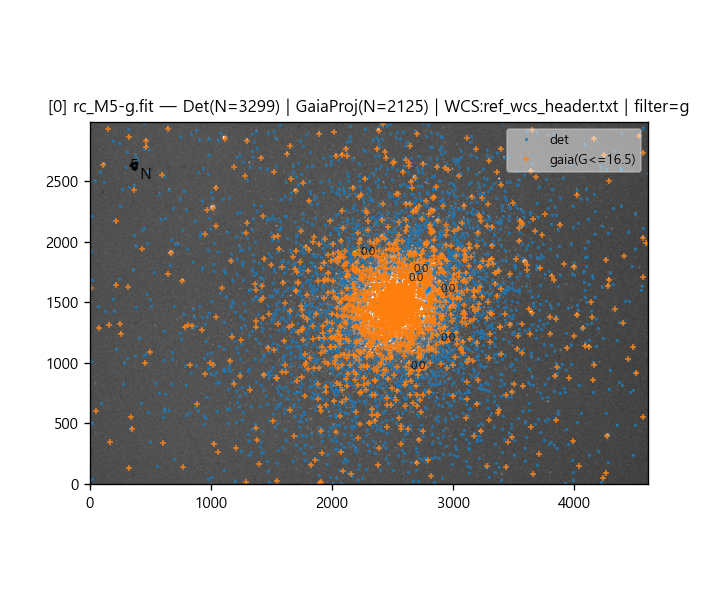

In [17]:
# === Cell 7X: Detection + PlateSolve Overlay Navigator ([], ., q) — filter 소문자 분류/표시 ===
#  - 기존 detect 오버레이 + (가능하면) WCS(솔빙) 기반 Gaia 별 위치/방향(N/E)까지 같이 표시
#  - 경로/파이프라인 흐름은 건드리지 않고, "표시"만 추가

assert len(r_filenames) > 0, "RESULT_DIR에 rc_*.fits 없음"

# ---------- detect loader ----------
def _load_detect_xy(fname):
    p = CACHE_DIR / f"detect_{fname}.csv"
    if p.exists():
        try:
            df = pd.read_csv(p)
            return df[["x","y"]].to_numpy(float) if not df.empty else np.zeros((0,2), float)
        except Exception:
            return np.zeros((0,2), float)
    return np.zeros((0,2), float)

# ---------- filter → index map (lowercase) ----------
by_filter = {}
for k, fn in enumerate(r_filenames):
    f = get_filter_from_fits(RESULT_DIR / fn).lower()
    by_filter.setdefault(f, []).append(k)
filters = sorted(by_filter.keys())

cur_idx = 0
cur_filter = None
interval = ZScaleInterval()

# ---------- Gaia cache (optional) ----------
# (Cell7에서 만들어 둔 gaia_fov.ecsv 있으면 그걸 써서 overlay)
gaia_cache = RESULT_DIR / "gaia_fov.ecsv"
t_gaia = None
try:
    if gaia_cache.exists():
        t_gaia = Table.read(str(gaia_cache), format="ascii.ecsv")
except Exception:
    t_gaia = None

# 표시용 밝기 컷(없으면 전체)
gaia_g_disp = float(getattr(P, "platesolve_gaia_display_g_limit", 16.5))

# ---------- Ref WCS header fallback (optional) ----------
# 파일 헤더에 WCS 없으면, RESULT_DIR/ref_wcs_header.txt가 있으면 그걸로 시도(등록 이미지면 대개 OK)
_ref_wcs_hdr = None
ref_wcs_header_txt = RESULT_DIR / "ref_wcs_header.txt"
try:
    if ref_wcs_header_txt.exists():
        _ref_wcs_hdr = fits.Header.fromstring(ref_wcs_header_txt.read_text(encoding="utf-8"), sep="\n")
except Exception:
    _ref_wcs_hdr = None

def _has_wcs_like(h):
    return ("CRVAL1" in h) and ("CRVAL2" in h) and ("CRPIX1" in h) and ("CRPIX2" in h) and (("CD1_1" in h) or ("PC1_1" in h) or ("CDELT1" in h))

def _load_wcs_for_frame(fname):
    """프레임 FITS 헤더에서 WCS 로드. 없으면 ref_wcs_header.txt fallback."""
    h = None
    try:
        h = fits.getheader(RESULT_DIR / fname)
    except Exception:
        h = None

    # 1) 파일 자체 헤더에 WCS
    if h is not None and _has_wcs_like(h):
        try:
            w = WCS(h)
            if getattr(w, "has_celestial", False) and w.has_celestial:
                return w, "fits"
            return w, "fits"
        except Exception:
            pass

    # 2) fallback ref_wcs_header.txt
    if _ref_wcs_hdr is not None and _has_wcs_like(_ref_wcs_hdr):
        try:
            w = WCS(_ref_wcs_hdr)
            return w, "ref_wcs_header.txt"
        except Exception:
            pass

    return None, None

def _world2pix_safe(w, ra_deg, dec_deg):
    """WCS world->pix 안전 변환."""
    ra = np.asarray(ra_deg, float)
    dec = np.asarray(dec_deg, float)
    try:
        x, y = w.all_world2pix(ra, dec, 0, maxiter=50, tolerance=1e-4, quiet=True)
        return np.asarray(x, float), np.asarray(y, float)
    except Exception:
        x, y = w.wcs_world2pix(ra, dec, 0)
        return np.asarray(x, float), np.asarray(y, float)

def _draw_compass(ax, w, nx, ny):
    """WCS가 있으면 N/E 방향 화살표를 그림(예쁘게, 짧게)."""
    if w is None:
        return

    cx, cy = (nx - 1) * 0.5, (ny - 1) * 0.5
    try:
        ra0, dec0 = w.all_pix2world([cx], [cy], 0)
        ra0, dec0 = float(ra0[0]), float(dec0[0])
    except Exception:
        return

    # 작은 각도 이동(0.02 deg ~ 72 arcsec)
    d = 0.02
    # 북쪽(Dec 증가)
    raN, decN = ra0, dec0 + d
    # 동쪽(RA 증가, cos(dec) 보정)
    raE = ra0 + d / max(np.cos(np.deg2rad(dec0)), 1e-6)
    decE = dec0

    try:
        x0, y0 = cx, cy
        xN, yN = _world2pix_safe(w, [raN], [decN])
        xE, yE = _world2pix_safe(w, [raE], [decE])
        xN, yN = float(xN[0]), float(yN[0])
        xE, yE = float(xE[0]), float(yE[0])
    except Exception:
        return

    # 보기 좋게 길이 정규화
    def _norm_arrow(x1, y1, maxlen=80.0):
        dx, dy = x1 - x0, y1 - y0
        L = (dx*dx + dy*dy) ** 0.5
        if not np.isfinite(L) or L <= 1e-6:
            return None
        s = min(maxlen / L, 1.0)
        return (dx*s, dy*s)

    aN = _norm_arrow(xN, yN)
    aE = _norm_arrow(xE, yE)
    if aN is None or aE is None:
        return

    # 좌상단에 표시(이미지 좌표 기준)
    xA, yA = 0.08*nx, 0.88*ny
    dxN, dyN = aN
    dxE, dyE = aE

    ax.annotate("", xy=(xA + dxN, yA + dyN), xytext=(xA, yA),
                arrowprops=dict(arrowstyle="-|>", lw=1.2, alpha=0.9))
    ax.annotate("", xy=(xA + dxE, yA + dyE), xytext=(xA, yA),
                arrowprops=dict(arrowstyle="-|>", lw=1.2, alpha=0.9))
    ax.text(xA + dxN, yA + dyN, " N", fontsize=9, va="center", ha="left", alpha=0.95)
    ax.text(xA + dxE, yA + dyE, " E", fontsize=9, va="center", ha="left", alpha=0.95)

# ---------- UI ----------
plt.ioff()
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception:
    pass

def _redraw():
    ax.clear()
    fname = r_filenames[cur_idx]
    path = RESULT_DIR / fname

    img = fits.getdata(path)
    ny, nx = img.shape

    vmin, vmax = interval.get_limits(img)
    ax.imshow(img, cmap="gray", origin="lower", norm=ImageNormalize(vmin=vmin, vmax=vmax))

    # ---- 1) detect overlay ----
    pos = _load_detect_xy(fname)
    if len(pos):
        ax.plot(pos[:,0], pos[:,1], "o", ms=1.0, alpha=0.75, label="det")

    # ---- 2) solved overlay (Gaia proj) ----
    w, wsrc = _load_wcs_for_frame(fname)
    gaia_n = 0
    if (w is not None) and (t_gaia is not None) and (len(t_gaia) > 0) and ("ra" in t_gaia.colnames) and ("dec" in t_gaia.colnames):
        try:
            # 표시용으로 밝은 것만
            if "phot_g_mean_mag" in t_gaia.colnames:
                m = np.isfinite(t_gaia["phot_g_mean_mag"]) & (t_gaia["phot_g_mean_mag"] <= gaia_g_disp)
            else:
                m = np.ones(len(t_gaia), bool)
            tt = t_gaia[m]

            xg, yg = _world2pix_safe(w, tt["ra"], tt["dec"])
            xg, yg = np.asarray(xg), np.asarray(yg)

            ok = np.isfinite(xg) & np.isfinite(yg) & (xg >= -5) & (xg < nx+5) & (yg >= -5) & (yg < ny+5)
            xg, yg = xg[ok], yg[ok]
            gaia_n = int(len(xg))

            if gaia_n > 0:
                # Gaia overlay는 + 마커로(검출원과 구분)
                ax.plot(xg, yg, "+", ms=4.0, mew=1.0, alpha=0.85, label=f"gaia(G<={gaia_g_disp:g})")

                # 상위 몇 개만 라벨(너무 지저분해지지 않게)
                if "phot_g_mean_mag" in tt.colnames and gaia_n > 0:
                    # ok가 적용된 tt 인덱스가 필요하므로 다시 구성
                    mag = np.asarray(tt["phot_g_mean_mag"], float)[ok]
                    if len(mag) > 0:
                        idx = np.argsort(mag)[:min(6, len(mag))]
                        for j in idx:
                            ax.text(xg[j] + 6, yg[j] + 6, f"{mag[j]:.1f}", fontsize=7, alpha=0.85)
        except Exception:
            gaia_n = 0

    # ---- 3) compass (N/E) ----
    if w is not None:
        _draw_compass(ax, w, nx, ny)

    # ---- title / legend ----
    filt = get_filter_from_fits(path).lower()
    wcs_txt = "WCS:None"
    if w is not None:
        wcs_txt = f"WCS:{wsrc or 'OK'}"
    ax.set_title(
        f"[{cur_idx}] {fname} — Det(N={len(pos)}) | GaiaProj(N={gaia_n}) | {wcs_txt} | filter={filt}",
        fontsize=10
    )
    ax.set_xlim(0, nx-1)
    ax.set_ylim(0, ny-1)

    # 범례(겹치지 않게 우상단)
    try:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(loc="upper right", fontsize=8, framealpha=0.5)
    except Exception:
        pass

    fig.canvas.draw_idle()

def _jump(step=1):
    global cur_idx
    n = len(r_filenames)
    if cur_filter is None:
        cur_idx = (cur_idx + step) % n
    else:
        cand = by_filter.get(cur_filter, [])
        if not cand:
            cur_idx = (cur_idx + step) % n
        else:
            if cur_idx in cand:
                j = cand.index(cur_idx)
                cur_idx = cand[(j + (1 if step>0 else -1)) % len(cand)]
            else:
                diffs = [(abs(k-cur_idx), k) for k in cand]
                cur_idx = min(diffs)[1]
    _redraw()

def _cycle_filter():
    global cur_filter, cur_idx
    if not filters:
        cur_filter = None
        _redraw(); return
    if cur_filter is None:
        cur_filter = get_filter_from_fits(RESULT_DIR / r_filenames[cur_idx]).lower()
        if cur_filter not in filters:
            cur_filter = filters[0]
    else:
        i = filters.index(cur_filter)
        cur_filter = filters[(i+1) % len(filters)]
    cand = by_filter.get(cur_filter, [])
    if cand:
        diffs = [(abs(k-cur_idx), k) for k in cand]
        cur_idx = min(diffs)[1]
    _redraw()

_redraw()

def on_key(e):
    if e.key == "q":
        plt.close(fig); return
    if e.key == "[":
        _jump(step=-1); return
    if e.key == "]":
        _jump(step=+1); return
    if e.key == ".":
        _cycle_filter(); return

cid = fig.canvas.mpl_connect("key_press_event", on_key)
plt.ion()
plt.show()


In [18]:
# === Cell 8 (IRAF FWHM 일원화, aperture/annulus 결정 + 로그) ===
# (네가 올린 그대로, 변경 없음)
import json, math, numpy as np, pandas as pd
from astropy.stats import SigmaClip
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

RESUME     = bool(getattr(P, "resume_mode", True))
FORCE_REAP = bool(getattr(P, "force_reap", False))

AP_SCALE      = float(getattr(P, "phot_aperture_scale", 1.0))
ANN_IN_SCALE  = float(getattr(P, "fitsky_annulus_scale", 4.0))
DANN_SCALE    = float(getattr(P, "fitsky_dannulus_scale", 2.0))
CBOX_SCALE    = float(getattr(P, "center_cbox_scale", 1.5))

fwhm_px_min   = float(getattr(P, "fwhm_px_min", 3.5))
fwhm_px_max   = float(getattr(P, "fwhm_px_max", 8.0))

min_r_ap_px   = float(getattr(P, "min_r_ap_px", 4.0))
min_r_in_px   = float(getattr(P, "min_r_in_px", 12.0))
min_r_out_px  = float(getattr(P, "min_r_out_px", 20.0))

GAIN   = float(getattr(P, "gain_e_per_adu", 0.1))
RN     = float(getattr(P, "rdnoise_e", 1.39))
ps = float(getattr(P, "pixel_scale_arcsec", np.nan))
if not np.isfinite(ps) or ps <= 0:
    raise RuntimeError("[Cell 8] pixel scale 미확정: Cell 1(Telescope/Camera) 먼저 실행하세요.")


rows_ap, rows_apcorr = [], []
made_ap, made_c = 0, 0
log = TailLogger(CACHE_DIR/"aperture.log", tail=getattr(P,"ui_log_tail",300), enable_console=True)

for fname in r_filenames:
    ap_json  = CACHE_DIR / f"ap_{fname}.json"
    apc_json = CACHE_DIR / f"apcorr_{fname}.json"
    use_ap  = RESUME and (not FORCE_REAP) and ap_json.exists()  and _is_up_to_date(ap_json,  [RESULT_DIR/fname])
    use_apc = RESUME and (not FORCE_REAP) and apc_json.exists() and _is_up_to_date(apc_json, [RESULT_DIR/fname])

    # --- FWHM: Cell 6 결과만 사용 (일원화)
    meta_path = CACHE_DIR / f"detect_{fname}.json"
    if meta_path.exists():
        try:
            meta = json.loads(meta_path.read_text(encoding="utf-8"))
            fwhm_med = float(meta.get("fwhm_med_rad_px", np.nan))
        except Exception:
            fwhm_med = float(getattr(P, "fwhm_pix_guess", 6.0))
            print("no fwhm_med in meta_path")
    else:
        fwhm_med = float(getattr(P, "fwhm_pix_guess", 6.0))
        print("no meta_path exists")

    fwhm_used = float(np.clip(fwhm_med, fwhm_px_min, fwhm_px_max))
    r_ap  = max(AP_SCALE     * fwhm_used, min_r_ap_px)
    r_in  = max(ANN_IN_SCALE * fwhm_used, max(min_r_in_px, r_ap + float(getattr(P,"annulus_min_gap_px",6.0))))
    r_out = max(r_in + DANN_SCALE * fwhm_used,
                r_in + float(getattr(P,"annulus_min_width_px",12.0)), min_r_out_px)
    cbox_px = max(CBOX_SCALE * fwhm_used, 5.0)

    row = dict(file=fname, fwhm_med=fwhm_med, fwhm_used=fwhm_used,
               r_ap=r_ap, r_in=r_in, r_out=r_out, cbox_px=cbox_px,
               )
    
    if (ps is not None) and (ps > 0):
        row.update(dict(fwhm_med_arcsec=fwhm_med*ps, fwhm_used_arcsec=fwhm_used*ps,
                        r_ap_arcsec=r_ap*ps, r_in_arcsec=r_in*ps, r_out_arcsec=r_out*ps,
                        cbox_arcsec=cbox_px*ps))
    rows_ap.append(row)
    ap_json.write_text(json.dumps(row, indent=2, default=_jsonify), encoding="utf-8")
    made_ap += 1

    # --- Aperture correction (옵션/동일 로직; 필요시 유지)
    apcorr_apply = True
    apcorr_min_snr = float(getattr(P, "apcorr_min_snr", 40.0))
    apcorr_use_min_n = int(getattr(P, "apcorr_use_min_n", 20))
    apcorr_scatter_max = float(getattr(P, "apcorr_scatter_max", 0.05))

    # 검출 좌표 (없으면 apcorr skip)
    det_csv = CACHE_DIR / f"detect_{fname}.csv"
    if not det_csv.exists():
        rowc = dict(file=fname, apcorr=np.nan, rel_scatter=np.nan, n_used=0, apply=False)
    else:
        img = fits.getdata(RESULT_DIR / fname).astype(float)
        xy_all = pd.read_csv(det_csv)[["x","y"]].to_numpy(float)
        # 후보 간소화: 밝고 고립된 top-K, 세부 구현은 기존과 같아도 충분.
        from scipy.spatial import cKDTree as KDTree
        H, W = img.shape
        if len(xy_all):
            vals = img[xy_all[:,1].astype(int).clip(0,H-1), xy_all[:,0].astype(int).clip(0,W-1)]
            order = np.argsort(vals)[::-1]
            xy_all = xy_all[order][:300]

        # 간단형 apcorr
        from astropy.stats import SigmaClip
        corr = []
        sc = SigmaClip(getattr(P,"annulus_sigma_clip",3.0), maxiters=int(getattr(P,"fitsky_max_iter",5)))
        r_small = max(float(getattr(P, 'apcorr_small_scale', 1.0)) * fwhm_used, r_ap)
        r_large = max(float(getattr(P, 'apcorr_large_scale', 3.0)) * fwhm_used, r_small + fwhm_used)

        for (x,y) in xy_all:
            ap_s = CircularAperture((x, y), r=r_small)
            ap_L = CircularAperture((x, y), r=r_large)
            an   = CircularAnnulus((x, y), r_in=r_in, r_out=r_out)
            st_s = ApertureStats(img, ap_s, sigma_clip=sc)
            st_L = ApertureStats(img, ap_L, sigma_clip=sc)
            st_an= ApertureStats(img, an, sigma_clip=sc)
            bkg_med = float(st_an.median)
            flux_s = float(st_s.sum - bkg_med * ap_s.area)
            flux_L = float(st_L.sum - bkg_med * ap_L.area)
            if flux_s>0 and flux_L>0:
                corr.append(float(flux_L/flux_s))

        if len(corr) >= apcorr_use_min_n:
            medc = float(np.median(corr))
            mad  = float(np.median(np.abs(np.array(corr) - medc)))
            rel_sc = 1.4826*mad/medc if medc>0 else np.nan
            apply_flag = bool(np.isfinite(rel_sc) and (rel_sc <= apcorr_scatter_max)) if apcorr_apply else False
        else:
            medc, rel_sc, apply_flag = (np.nan, np.nan, False)

        rowc = dict(file=fname, fwhm_med=fwhm_med, fwhm_used=fwhm_used,
                    r_small=r_small, r_large=r_large, n_used=int(len(corr)),
                    apcorr=medc, rel_scatter=rel_sc, apply=bool(apply_flag))
        if (ps is not None) and (ps>0):
            rowc.update(dict(r_small_arcsec=r_small*ps, r_large_arcsec=r_large*ps))

    rows_apcorr.append(rowc)
    apc_json.write_text(json.dumps(rowc, indent=2, default=_jsonify), encoding="utf-8")
    made_c += 1

    if (ps is not None) and (ps > 0):
        log.write(f"{fname}: FWHM~{fwhm_med:.2f}px ({fwhm_med*ps:.2f}\") → r_ap={r_ap:.1f}px")
    else:
        log.write(f"{fname}: FWHM~{fwhm_med:.2f}px → r_ap={r_ap:.1f}px")

log.close()
pd.DataFrame(rows_ap).to_csv(RESULT_DIR/"aperture_by_frame.csv", index=False)
pd.DataFrame(rows_apcorr).to_csv(RESULT_DIR/"apcorr_summary.csv", index=False)
print(f"Saved: aperture_by_frame.csv / apcorr_summary.csv (새 ap={made_ap}, apcorr={made_c}) | 로그: {CACHE_DIR/'aperture.log'}")


[19:41:03] rc_M5-g.fit: FWHM~5.25px (2.06") → r_ap=5.2px
[19:41:06] rc_M5-i.fit: FWHM~8.16px (3.21") → r_ap=8.2px
[19:41:09] rc_M5-r.fit: FWHM~5.65px (2.22") → r_ap=5.6px
Saved: aperture_by_frame.csv / apcorr_summary.csv (새 ap=3, apcorr=3) | 로그: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\cache\aperture.log


In [19]:
# === Cell 9: Master 편집 UI (+ '.' 필터 순환) — star-like 강제추가 & 동일화된 SNR ===
from ipywidgets import Output, VBox, HBox, HTML, Layout
from IPython.display import display
import numpy as np, pandas as pd, time, math
from pathlib import Path
from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from scipy.spatial import cKDTree as KDTree
import matplotlib.pyplot as plt

# 환경 (Cell 0에서 준비된 전역 사용)
CACHE_DIR = P.cache_dir; CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULT_DIR = P.result_dir

EDIT_LOG = CACHE_DIR / "master_edit.log"

def _log_to_file(msg: str):
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    EDIT_LOG.write_text((EDIT_LOG.read_text(encoding="utf-8") if EDIT_LOG.exists() else "") + f"[{ts}] {msg}\n", encoding="utf-8")

# 파라미터
add_min_snr        = float(getattr(P, "add_min_snr", 10.0))   # 'a' 추가 컷
search_radius_px   = float(getattr(P, "search_radius_px", 7.0))

# 단위/키 통일 (px 전용, fitsky 키 사용)
fwhm_guess       = float(getattr(P, "fwhm_seed_px", 6.0))
ap_scale_for_snr = float(getattr(P, "phot_aperture_scale", 1.6))
ann_in_scale     = float(getattr(P, "fitsky_annulus_scale", 3.2))
ann_out_scale    = float(getattr(P, "fitsky_dannulus_scale", 2.0))

label_max   = int(getattr(P, "overlay_max_labels", 150))
GAIN        = float(getattr(P, "gain_e_per_adu", 1.0))
RN_PARAM    = float(getattr(P, "rdnoise_e", 7.5))  # ★ 파이프라인 전체에서 공통으로 쓰는 rdnoise (Cell 11과 동일)
CANVAS_PX   = int(getattr(P, "ui_canvas_px", 700))

# star-like 판정 파라미터
STAR_ELONG_MAX = float(getattr(P, "add_star_elong_max", 1.6))
STAR_SHARP_LO  = float(getattr(P, "add_star_sharp_lo", 0.08))
STAR_SHARP_HI  = float(getattr(P, "add_star_sharp_hi", 0.9))

# 준비 체크
if not r_filenames:
    raise RuntimeError("정렬 완료된 프레임이 없습니다. 4R/5C-APPLY까지 실행하세요.")

ref_idx  = max(0, min(getattr(P, "align_ref_index", 0), len(r_filenames)-1))
ref_file = r_filenames[ref_idx]

def _filter_upper(fn): 
    return get_filter_from_fits(RESULT_DIR / fn).upper()

# 필터 그룹
filters_order = ["G","R","I"]
def _nearest_by_filter(cur_idx, nextF):
    cand = [k for k,fn in enumerate(r_filenames) if _filter_upper(fn)==nextF]
    if not cand: return (cur_idx + 1) % len(r_filenames)
    return min(cand, key=lambda k: abs(k-cur_idx))

def _cycle_filter_idx(cur_idx):
    curF = _filter_upper(r_filenames[cur_idx])
    try:
        nextF = filters_order[(filters_order.index(curF)+1) % len(filters_order)]
    except Exception:
        nextF = curF
    return _nearest_by_filter(cur_idx, nextF)

# 검출 csv 경로 헬퍼
def _detect_csv_for(rfn: str) -> Path:
    p = CACHE_DIR / f"detect_{rfn}.csv"
    if p.exists(): return p
    q = Path(RESULT_DIR) / f"detect_{rfn}.csv"
    if q.exists(): return q
    return p

# ★★★ 프레임별 rdnoise.csv는 더 이상 사용하지 않음 — 파이프라인 전체에서 RN_PARAM(파라미터값)만 사용 ★★★

# 로드 기본 (ref 기준)
view_idx  = ref_idx
view_file = r_filenames[view_idx]
img = fits.getdata(Path(RESULT_DIR) / view_file).astype(float)

# 검출 목록 (보기용 점)
det = pd.read_csv(_detect_csv_for(view_file)) if _detect_csv_for(view_file).exists() else pd.DataFrame(columns=["x","y"])
detXY = det[["x","y"]].to_numpy(float) if len(det) else np.zeros((0,2))

# 마스터 카탈로그 로드/생성
master_path = Path(RESULT_DIR) / "master_catalog.tsv"
if master_path.exists():
    master = pd.read_csv(master_path, sep="\t")
else:
    Nm = int(getattr(P, "N_master", 1000))
    det_ref = pd.read_csv(_detect_csv_for(ref_file)) if _detect_csv_for(ref_file).exists() else pd.DataFrame(columns=["x","y"])
    use = det_ref.head(Nm).copy()
    if use.empty:
        raise RuntimeError("검출 목록이 비었습니다. 검출 파라미터를 확인하세요.")
    use["ID"] = np.arange(1, len(use)+1, dtype=int)
    use["ref_file"] = ref_file
    master = use.rename(columns={"x":"x_ref","y":"y_ref"})[["ID","x_ref","y_ref","ref_file"]]
    master.to_csv(master_path, sep="\t", index=False)

# 최초 백업
backup_master_path = Path(RESULT_DIR) / "master_catalog.orig.tsv"
if master_path.exists() and (not backup_master_path.exists()):
    master_path.replace(backup_master_path)
    backup_master_path.replace(master_path)
    print(f"(백업) {backup_master_path.name} 생성")

# 로그 UI
LOG_TAIL = int(getattr(P, "ui_log_tail", 300))
log_out = Output(layout=Layout(width='330px', height='700px', overflow='auto', border='1px solid #444'))
_log_buffer = []
def _log_ui(*args):
    msg = " ".join(str(a) for a in args)
    _log_buffer.insert(0, msg)
    with log_out:
        from IPython.display import clear_output as _clr
        _clr(wait=True)
        for line in _log_buffer[:LOG_TAIL]:
            print(line)
    _log_to_file(msg)
def log(*args, **kwargs): _log_ui(*args)

# KDTree for master
def _build_tree(df): 
    XY = df[["x_ref","y_ref"]].to_numpy(float)
    return KDTree(XY) if len(XY) else None
tree = _build_tree(master)

def _save_master():
    master.sort_values("ID").to_csv(master_path, sep="\t", index=False)
    log(f"[저장] master_catalog.tsv (N={len(master)})")

# 모양 지표
def _shape_metrics_local(xc, yc):
    H, W = img.shape
    r = max(int(round(2.5*max(fwhm_guess, 2.0))), 7)
    xi, yi = int(round(xc)), int(round(yc))
    x0,x1 = max(0,xi-r), min(W,xi+r+1)
    y0,y1 = max(0,yi-r), min(H,yi+r+1)
    if (x1-x0)<7 or (y1-y0)<7:
        return np.inf, 0.0
    cut = img[y0:y1, x0:x1].astype(float)
    mean, med, std = sigma_clipped_stats(cut, sigma=3.0)
    Z = cut - med
    Z[~np.isfinite(Z)] = 0.0
    Z[Z < 0] = 0.0
    S = float(np.nansum(Z))
    if S <= 0:
        return np.inf, 0.0
    yy, xx = np.mgrid[y0:y1, x0:x1]
    xbar = float(np.nansum(xx*Z)/S); ybar = float(np.nansum(yy*Z)/S)
    dx = xx - xbar; dy = yy - ybar
    Ixx = float(np.nansum(Z * dx*dx)/S); Iyy = float(np.nansum(Z * dy*dy)/S); Ixy = float(np.nansum(Z * dx*dy)/S)
    w, _ = np.linalg.eigh(np.array([[Ixx, Ixy],[Ixy, Iyy]]))
    w = np.sort(np.maximum(w, 1e-12))
    elong = float(np.sqrt(w[1]/w[0]))  # 1이면 원형
    # sharpness (간단 박스 합)
    cx, cy = int(round(xbar)), int(round(ybar))
    def _box_sum(R):
        xa0, xa1 = max(0, cx-R), min(W, cx+R+1)
        ya0, ya1 = max(0, cy-R), min(H, cy+R+1)
        b = img[ya0:ya1, xa0:xa1] - med
        b = np.where(np.isfinite(b), b, 0.0)
        return float(np.nansum(b[b>0]))
    s33 = _box_sum(1); s55 = _box_sum(2)
    sharp = (s33/max(s55, 1e-9)) if s55>0 else 0.0
    return elong, sharp

# 동일화된 SNR 계산(5X/11과 같은 형태) — n_sky 사용 + rdnoise는 파라미터 값만 사용
def _snr_local(xc, yc, fname, fwhm_px):
    # 아퍼처/애널러스 반경
    r_ap  = max(ap_scale_for_snr * fwhm_px, float(getattr(P,"min_r_ap_px",6.0)))
    r_in  = max(ann_in_scale * fwhm_px, r_ap + float(getattr(P,"annulus_min_gap_px",6.0)))
    r_out = max(r_in + ann_out_scale * fwhm_px, r_in + float(getattr(P,"annulus_min_width_px",12.0)))
    ap = CircularAperture((xc, yc), r=r_ap)
    an = CircularAnnulus((xc, yc), r_in=r_in, r_out=r_out)

    # 배경 샘플(시그마클립) → n_sky
    sc = SigmaClip(getattr(P,"annulus_sigma_clip", 3.0), maxiters=int(getattr(P,"fitsky_max_iter",5)))
    st_an = ApertureStats(img, an, sigma_clip=sc)
    bkg_med = float(st_an.median) if st_an.median is not None else np.nan
    bkg_std = float(st_an.std) if st_an.std is not None else np.nan

    # n_sky 직접 집계(샘플 개수)
    mask = an.to_mask(method='center').to_image(img.shape) > 0
    vals = img[mask]; vals = vals[np.isfinite(vals)]
    n_sky = 0
    if vals.size:
        vc = sc(vals)
        vv = vc.compressed() if np.ma.isMaskedArray(vc) else np.asarray(vc)
        n_sky = int(np.sum(np.isfinite(vv)))

    st_ap = ApertureStats(img, ap, sigma_clip=None)
    ap_sum  = float(st_ap.sum or 0.0)
    ap_area = float(ap.area)

    # 순신호(e-)
    flux_net_adu = ap_sum - bkg_med * ap_area
    flux_e = max(flux_net_adu, 0.0) * GAIN

    # 픽셀당 분산(e-^2) = sky + RN^2
    sky_sig_pix_e2 = (bkg_std * GAIN)**2 if np.isfinite(bkg_std) else 0.0
    # ★ rdnoise는 프레임별 추정 없이 RN_PARAM만 사용 (Cell 11과 동일)
    sigma_pix_e2 = sky_sig_pix_e2 + (RN_PARAM**2)

    # 전체 분산(e-^2) — n_sky 사용
    var_e = flux_e + ap_area*sigma_pix_e2 + (ap_area**2 / max(n_sky,1)) * sigma_pix_e2
    if var_e <= 0: 
        return 0.0
    return float(flux_e / math.sqrt(var_e))

# 로컬 중심 + SNR (추가 판정용)
def _local_centroid_and_snr(x, y, fname):
    H, W = img.shape; xi, yi = int(round(x)), int(round(y))
    r = int(max(search_radius_px, fwhm_guess))
    x0, x1 = max(0, xi-r), min(W, xi+r+1); y0, y1 = max(0, yi-r), min(H, yi+r+1)
    if (x1-x0) < 7 or (y1-y0) < 7: return None
    cut = img[y0:y1, x0:x1].copy()
    mean, med, std = sigma_clipped_stats(cut, sigma=3.0)
    if not np.isfinite(std) or std <= 0: return None
    yy, xx = np.mgrid[y0:y1, x0:x1]
    Z = cut - med; Z[Z<0] = 0; S = Z.sum()
    if S <= 0: return None
    xc = float((xx*Z).sum()/S); yc = float((yy*Z).sum()/S)
    snr = _snr_local(xc, yc, fname, fwhm_guess)
    return (xc, yc, snr)

# KDT for master
def _nearest_master_idx(x, y):
    if (tree is None) or (len(master)==0): return None, np.inf
    d, j = tree.query([x, y], k=1); return int(j), float(d)

next_id = (int(master["ID"].max()) + 1) if len(master) else 1

# Matplotlib 뷰어
interval = ZScaleInterval(); vmin, vmax = interval.get_limits(img)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

plt.ioff()
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
try:
    if hasattr(fig.canvas, "manager") and hasattr(fig.canvas.manager, "key_press_handler_id"):
        fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except Exception: pass
try: fig.canvas.header_visible = False
except Exception: pass

im = ax.imshow(img, cmap="gray", origin="lower", norm=norm)
ax.set_title(f"{view_file} — Master 편집 (view) | FILTER={_filter_upper(view_file)}", fontsize=10)
if HAS_IPYMPL and hasattr(fig, "canvas") and hasattr(fig.canvas, "layout"):
    fig.canvas.layout = Layout(width=f"{CANVAS_PX}px", height=f"{CANVAS_PX}px")

det_scatter   = ax.plot(detXY[:,0], detXY[:,1], ".", ms=1.8, color=(1,1,1,0.35))[0] if len(detXY) else None
mast_scatter  = ax.plot([], [], "o", ms=3.5, mfc="none", mec="gold",  mew=0.9, alpha=0.9)[0]
added_scatter = ax.plot([], [], "o", ms=4.0, mfc="none", mec="lime",  mew=1.2, alpha=0.95)[0]
labs = []

def _refresh():
    XYm = master[["x_ref","y_ref"]].to_numpy(float)
    mast_scatter.set_data((XYm[:,0], XYm[:,1]) if len(XYm) else ([], []))
    added_scatter.set_data([], [])
    for t in labs:
        try: t.remove()
        except Exception: pass
    labs.clear()
    if "mag" in det.columns:
        tmp = det[["x","y","mag"]].copy(); tmp["mag_for_sort"] = tmp["mag"].fillna(99.0)
        tmp = tmp.sort_values("mag_for_sort").head(label_max)
        for _, r in tmp.iterrows():
            t = ax.text(float(r["x"])+3, float(r["y"])+3, f"{r['mag']:.2f}",
                        color='cyan', fontsize=6, ha='left', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.12', fc=(0,0,0,0.42), ec='none'))
            labs.append(t)
    fig.canvas.draw_idle()

def _reload_view(idx):
    global view_idx, view_file, img, det, detXY, im, norm
    view_idx = int(idx); view_file = r_filenames[view_idx]
    img = fits.getdata(Path(RESULT_DIR) / view_file).astype(float)
    det_path = _detect_csv_for(view_file)
    det = pd.read_csv(det_path) if det_path.exists() else pd.DataFrame(columns=["x","y"])
    detXY = det[["x","y"]].to_numpy(float) if len(det) else np.zeros((0,2))
    vmin, vmax = ZScaleInterval().get_limits(img)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    im.set_data(img); im.set_norm(norm)
    if det_scatter is not None:
        det_scatter.set_data(detXY[:,0], detXY[:,1]) if len(detXY) else det_scatter.set_data([],[])
    ax.set_title(f"{view_file} — Master 편집 (view) | FILTER={_filter_upper(view_file)}", fontsize=10)
    _refresh()

_last_deleted = None  # (ID, x, y)

def _add_at(x, y, force=False):
    global next_id, tree
    res = _local_centroid_and_snr(x, y, view_file)
    if res is None:
        log("추가 실패: 신호 없음(centroid/SNR 산출 불가)")
        return
    xc, yc, snr = res
    elong, sharp = _shape_metrics_local(xc, yc)
    star_like = (elong <= STAR_ELONG_MAX) and (STAR_SHARP_LO <= sharp <= STAR_SHARP_HI)
    if not star_like:
        log(f"추가 실패: 별 형태 아님 (elong={elong:.2f}, sharp={sharp:.2f})")
        return
    if (not force) and (snr < add_min_snr):
        log(f"추가 실패: SNR={snr:.1f} < {add_min_snr}")
        return
    j, d = _nearest_master_idx(xc, yc)
    if (j is not None) and (d <= 8.0):
        near = master.iloc[j]; log(f"추가 생략: 근처에 이미 ID {int(near['ID'])} (d={d:.1f}px)"); return
    new_id = int(next_id); next_id += 1
    master.loc[len(master)] = dict(ID=new_id, x_ref=float(xc), y_ref=float(yc), ref_file=str(ref_file))
    tree = _build_tree(master); _save_master()
    log(f"[ADD] ID {new_id} @ ({xc:.1f}, {yc:.1f})  |  SNR={snr:.1f}, elong={elong:.2f}, sharp={sharp:.2f}")
    _refresh()

def _drop_at(x, y):
    global _last_deleted, tree
    j, d = _nearest_master_idx(x, y)
    if (j is None) or (d > 8.0): log("삭제 실패: 커서 근처에 마스터 별 없음"); return
    row = master.iloc[j]; ID  = int(row["ID"]); xc = float(row["x_ref"]); yc = float(row["y_ref"])
    master.drop(index=master.index[j], inplace=True); master.reset_index(drop=True, inplace=True)
    tree = _build_tree(master); _last_deleted = (ID, xc, yc)
    _save_master(); log(f"[DROP] ID {ID} @ ({xc:.1f}, {yc:.1f})  (d={d:.1f}px)"); _refresh()

def _undo_last():
    global _last_deleted, next_id, tree
    if _last_deleted is None: log("되돌릴 삭제 항목이 없습니다."); return
    ID, xc, yc = _last_deleted
    if (len(master)>0) and (ID in set(master["ID"].astype(int))):
        ID = int(next_id); next_id += 1; log(f"(원 ID 충돌) 새 ID {ID}로 복구")
    master.loc[len(master)] = dict(ID=int(ID), x_ref=float(xc), y_ref=float(yc), ref_file=str(ref_file))
    tree = _build_tree(master); _save_master(); log(f"[UNDO] 복구: ID {ID} @ ({xc:.1f}, {yc:.1f})")
    _last_deleted = None; _refresh()

def _drop_box_at(x, y, size=None):
    global tree
    if size is None: size = int(getattr(P, "bulk_drop_box_px", 200))
    half = size/2.0; x0, x1 = x-half, x+half; y0, y1 = y-half, y+half
    if len(master) == 0: log("박스삭제: master가 비어있음"); return
    sel = master.index[(master["x_ref"].between(x0, x1)) & (master["y_ref"].between(y0, y1))].tolist()
    if not sel: log(f"박스삭제: 범위 내 마스터 없음 (box={size}px @ {x:.1f},{y:.1f})"); return
    ids = master.loc[sel, "ID"].astype(int).tolist()
    master.drop(index=sel, inplace=True); master.reset_index(drop=True, inplace=True)
    tree = _build_tree(master); _save_master()
    head = ids[:30]; more = f" ...(+{len(ids)-30})" if len(ids) > 30 else ""
    log(f"[BOX DROP] {len(ids)}개 삭제 (box={size}px @ {x:.1f},{y:.1f}) → IDs: {head}{more}"); _refresh()

def on_scroll(event):
    if event.inaxes != ax: return
    base_scale = 1.2; scale_factor = 1/base_scale if event.button == 'up' else base_scale
    cur_xlim = ax.get_xlim(); cur_ylim = ax.get_ylim()
    xdata = event.xdata if event.xdata is not None else 0.5*(cur_xlim[0]+cur_xlim[1])
    ydata = event.ydata if event.ydata is not None else 0.5*(cur_ylim[0]+cur_ylim[1])
    new_w  = (cur_xlim[1]-cur_xlim[0]) * scale_factor; new_h  = (cur_ylim[1]-cur_ylim[0]) * scale_factor
    relx = (xdata - cur_xlim[0]) / (cur_xlim[1]-cur_xlim[0]); rely = (ydata - cur_ylim[0]) / (cur_ylim[1]-cur_ylim[0])
    ax.set_xlim([xdata - new_w*relx,  xdata + new_w*(1-relx)]); ax.set_ylim([ydata - new_h*rely, ydata + new_h*(1-rely)])
    fig.canvas.draw_idle()

def on_key(event):
    if (event.xdata is not None) and (event.ydata is not None):
        log(f"[key] '{event.key}' at ({event.xdata:.1f}, {event.ydata:.1f})")
    else:
        log(f"[key] '{event.key}'")
    if event.key == "q": log("[종료] 창을 닫습니다."); plt.close(fig); return
    if event.key == ".": _reload_view(_cycle_filter_idx(view_idx)); return
    if event.inaxes != ax: return
    x, y = event.xdata, event.ydata
    if x is None or y is None: return
    k = event.key
    if   k == "a": _add_at(x, y, force=False)
    elif k == "A": _add_at(x, y, force=True)
    elif k == "d": _drop_at(x, y)
    elif k in ("D", "shift+d"): _drop_box_at(x, y)
    elif k == "u": _undo_last()
    elif k == "s": _save_master(); log("[알림] 좌표 저장 완료")

cid_k = fig.canvas.mpl_connect("key_press_event", on_key)
cid_s = fig.canvas.mpl_connect("scroll_event", on_scroll)

def _refresh_and_show():
    _refresh()
    box_sz = int(getattr(P, "bulk_drop_box_px", 200))
    help_html = HTML(f"<b>키:</b> '.'다음필터  휠=줌  a(추가) A(강추가:★모양 필수) d(삭제) <b>Shift+D(박스삭제 {box_sz}px)</b> u(복원) s(저장) q(종료)")
    if HAS_IPYMPL:
        display(VBox([help_html, HBox([fig.canvas, log_out])]))
    else:
        display(help_html); display(HBox([log_out])); display(fig)
    plt.ion(); log("준비 완료. 좌표를 편집하세요.")

_refresh_and_show()


(백업) master_catalog.orig.tsv 생성


In [20]:
# === Cell 10: Match summary (간결화) ===
master = pd.read_csv(RESULT_DIR/"master_catalog.tsv", sep="\t")
XY_ref = master[["x_ref","y_ref"]].to_numpy()
tree_ref = KDTree(XY_ref) if len(XY_ref) else None

rows=[]
for fname in r_filenames:
    det_csv = CACHE_DIR / f"detect_{fname}.csv"
    XY = pd.read_csv(det_csv)[["x","y"]].to_numpy(float) if det_csv.exists() else np.zeros((0,2))
    n_det = len(XY)
    if n_det>0 and tree_ref is not None:
        tree_det = KDTree(XY)
        dist, _ = tree_det.query(XY_ref, k=1)
        n_within = int(np.sum(dist <= float(getattr(P,"match_tol_px",3.0))))
        d_med = float(np.median(dist)) if len(dist) else np.nan
    else:
        n_within, d_med = 0, np.nan
    rows.append(dict(file=fname, n_master=len(master), n_detected=n_det,
                     matched_within_tol=n_within, median_nn_dist=d_med))

pd.DataFrame(rows).to_csv(RESULT_DIR/"match_summary.csv", index=False)
print("Saved →", RESULT_DIR/"match_summary.csv")


Saved → C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\match_summary.csv


In [21]:
# === Cell 11 — Forced photometry (전역 SKY σ 사용; rdnoise는 파라미터 고정) ===
try:
    from tqdm.auto import tqdm
except Exception:
    class tqdm:
        def __init__(self, it=None, total=None, desc="", unit="", position=0, leave=True):
            self.it = it or []
        def __iter__(self): 
            for x in self.it: yield x
        def set_postfix_str(self, s): pass
        def update(self, n=1): pass
        def close(self): pass

import json, math, time, os
import numpy as np, pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.aperture import CircularAperture, CircularAnnulus
from scipy.spatial import cKDTree as KDTree

RESULT_DIR = Path(RESULT_DIR); CACHE_DIR = Path(CACHE_DIR)

# --- params / keys ---
GAIN = float(getattr(P,"gain_e_per_adu",1.0))
ZP   = float(getattr(P,"zp_initial",25.0))

ann_sigma   = float(getattr(P,"fitsky_sigma_clip",3.0))
ann_maxiter = int(getattr(P,"fitsky_max_iter",5))

neigh_scale     = float(getattr(P,"annulus_neighbor_mask_scale",1.3) or 1.3)
CBOX_SCALE      = float(getattr(P,"center_cbox_scale",1.5))
min_snr_for_mag = float(getattr(P,"min_snr_for_mag",3.0))
tol             = float(getattr(P,"match_tol_px",3.0))
ap_mode         = getattr(P,"aperture_mode","apcorr").lower()
sat_adu         = float(getattr(P,"saturation_adu",60000.0))

# rdnoise는 프레임별 추정 제거 → 파라미터 고정 사용
RN_PARAM = float(getattr(P,"rdnoise_e",7.5))

# --- inputs ---
master    = pd.read_csv(RESULT_DIR/"master_catalog.tsv", sep="\t")
df_ap     = pd.read_csv(RESULT_DIR/"aperture_by_frame.csv")
apcorr_df = pd.read_csv(RESULT_DIR/"apcorr_summary.csv") if (RESULT_DIR/"apcorr_summary.csv").exists() else None

# segm masks from Cell 6 (optional)
use_segm_mask = bool(getattr(P,"bkg_use_segm_mask", True))
segm_masks = globals().get("segm_masks", {})

# SKY SIGMA (frame) 로드: 1순위 frame_sky_sigma.csv, 2순위 frame_quality.csv
_sky_df = None
_sky_src = None
sky_csv = RESULT_DIR/"frame_sky_sigma.csv"
if sky_csv.exists():
    _sky_df = pd.read_csv(sky_csv)
    _sky_src = "frame_sky_sigma.csv"
elif (RESULT_DIR/"frame_quality.csv").exists():
    _sky_df = pd.read_csv(RESULT_DIR/"frame_quality.csv")
    _sky_src = "frame_quality.csv"

def _sky_sigma_for(fname):
    """전역 하늘 σ (e-/px). 없으면 NaN."""
    try:
        if _sky_df is None or _sky_df.empty:
            return np.nan
        row = _sky_df[_sky_df["file"]==fname]
        if row.empty:
            return np.nan
        # 우선 e- 컬럼 탐색
        for col in ("sky_sigma_med_e","sky_sigma_e"):
            if col in row.columns:
                v = float(row[col].values[0])
                return v if np.isfinite(v) else np.nan
        # ADU만 있으면 gain으로 환산
        for col in ("sky_sigma_med_adu","sky_sigma_adu"):
            if col in row.columns:
                v = float(row[col].values[0])
                v = v*GAIN if np.isfinite(v) else np.nan
                return v
        return np.nan
    except Exception:
        return np.nan

# FAIL logs — 한 번에 저장
fail_csv = RESULT_DIR / "phot_forced_fail.tsv"
_fail_rows_all = []

# ---- helpers ----
def _get_frame_filter_lower(r_name):
    try:
        with fits.open(RESULT_DIR / r_name) as hdul:
            f = hdul[0].header.get("FILTER", None)
            if f is not None: return str(f).strip().lower()
    except Exception:
        pass
    return "unknown"

def _get_exptime(path):
    return get_exptime_from_fits(path, default=1.0)

def _refine_local_centroid(img, x, y, fwhm_used, cbox_scale):
    H, W = img.shape
    r = int(max(cbox_scale * max(fwhm_used, 2.0), 6.0))
    xi, yi = int(round(x)), int(round(y))
    x0, x1 = max(0,xi-r), min(W,xi+r+1)
    y0, y1 = max(0,yi-r), min(H,yi+r+1)
    if (x1-x0)<9 or (y1-y0)<9: return (x, y)
    cut = img[y0:y1, x0:x1]
    _, med, _ = sigma_clipped_stats(cut, sigma=3.0)
    z = cut - med; z[~np.isfinite(z)] = 0.0; z[z<0] = 0.0
    S = np.nansum(z)
    if S <= 0: return (x, y)
    yy, xx = np.mgrid[y0:y1, x0:x1]
    xc = float(np.nansum(xx*z)/S); yc = float(np.nansum(yy*z)/S)
    return (xc, yc)

def _circle_mask(shape, cx, cy, r):
    H, W = shape
    y = np.arange(H)[:,None]; x = np.arange(W)[None,:]
    return (x-cx)**2 + (y-cy)**2 <= (r*r)

def _phot_one_target(img, xc, yc, r_ap, r_in, r_out,
                     base_mask_cut, neighbors_xy_cut,
                     fwhm_used, sigma_clip_val=3.0, maxiters=5,
                     rn_param_e=RN_PARAM, sky_frame_e=np.nan):
    """로컬 σ와 전역 σ(e-/px) 중 큰 값을 사용. rdnoise는 파라미터 고정."""
    Hc, Wc = img.shape
    ap_mask      = _circle_mask((Hc,Wc), xc, yc, r_ap)
    ann_out_mask = _circle_mask((Hc,Wc), xc, yc, r_out)
    ann_in_mask  = _circle_mask((Hc,Wc), xc, yc, r_in)
    ann_mask = ann_out_mask & (~ann_in_mask)

    # neighbor/segm 마스킹
    neigh_mask = np.zeros_like(img, dtype=bool)
    if neighbors_xy_cut:
        r_nei = neigh_scale * fwhm_used
        for nx, ny in neighbors_xy_cut:
            neigh_mask |= _circle_mask((Hc,Wc), nx, ny, r_nei)
    if base_mask_cut is not None: ann_mask &= (~base_mask_cut)
    ann_mask &= (~neigh_mask)

    vals = img[ann_mask]; vals = vals[np.isfinite(vals)]
    n_sky = 0
    if vals.size:
        sc = SigmaClip(sigma=sigma_clip_val, maxiters=maxiters)
        vals_c = sc(vals)
        vv = vals_c.compressed() if np.ma.isMaskedArray(vals_c) else np.asarray(vals_c)
        vv = vv[np.isfinite(vv)]
        n_sky = int(vv.size)
        if n_sky >= 5:
            bkg_med  = float(np.nanmedian(vv))
            std_lin  = float(np.nanstd(vv, ddof=1))
            mad      = 1.4826 * float(np.nanmedian(np.abs(vv - bkg_med)))
            bkg_std  = float(np.nanmax([std_lin, mad]))
        else:
            bkg_med  = float(np.nanmedian(vals))
            bkg_std  = float(np.nanstd(vals, ddof=1)) if vals.size>1 else np.nan
    else:
        bkg_med = bkg_std = np.nan

    ap_sum   = float(np.nansum(img[ap_mask]))
    ap_area  = float(np.count_nonzero(ap_mask))

    # phot & SNR (전역 σ 바닥 사용)
    flux_net_adu = ap_sum - bkg_med * ap_area
    flux_e       = max(flux_net_adu, 0.0) * GAIN

    # 픽셀당 σ (e-/px): local vs global 중 큰 것
    local_sky_e = (bkg_std * GAIN) if np.isfinite(bkg_std) else 0.0
    sky_e_use   = local_sky_e
    if np.isfinite(sky_frame_e):
        sky_e_use = max(local_sky_e, sky_frame_e)

    # rdnoise는 파라미터 고정
    sigma_pix_e2 = (sky_e_use**2) + (rn_param_e**2)

    # 단순한 근사 소음 합산(포아송 + 배경 + 배경추정오차)
    var_e   = flux_e + ap_area*sigma_pix_e2 + (ap_area**2/max(n_sky,1))*sigma_pix_e2
    sigma_e = math.sqrt(max(var_e, 0.0))
    snr     = (flux_e / sigma_e) if sigma_e > 0 else 0.0

    # 포화 체크
    is_sat = False
    try:
        is_sat = np.nanmax(img[ap_mask]) >= sat_adu
    except Exception:
        pass

    return (flux_e, sigma_e, snr, ap_sum, bkg_med, bkg_std, ap_area, n_sky, is_sat)

def _det_xy_for(fname):
    det_csv = CACHE_DIR / f"detect_{fname}.csv"
    if det_csv.exists():
        tmp = pd.read_csv(det_csv)
        if not tmp.empty:
            return tmp[["x","y"]].to_numpy(float)
    return None

def _is_up_to_date(out_path, deps):
    try:
        t_out = os.path.getmtime(out_path)
        for d in deps:
            if os.path.getmtime(d) > t_out: return False
        return True
    except Exception:
        return False

# ---- main loop ----
print(f"[Cell11] rdnoise: parameter-fixed {RN_PARAM:.3f} e-  | SKY source: {_sky_src or 'None'}")

outer = tqdm(r_filenames, desc="Photometry (11)", unit="frame", position=0)
index_rows = []; made_phot = 0

for fname in outer:
    out = RESULT_DIR / f"{fname}_photometry.tsv"
    deps = [RESULT_DIR/fname, RESULT_DIR/"master_catalog.tsv", RESULT_DIR/"aperture_by_frame.csv"]
    if (RESULT_DIR/"apcorr_summary.csv").exists(): deps.append(RESULT_DIR/"apcorr_summary.csv")

    if getattr(P,"resume_mode",True) and (not getattr(P,"force_rephot",False)) and out.exists() and _is_up_to_date(out, deps):
        outer.set_postfix_str("cached")
        index_rows.append(dict(file=fname, filter=_get_frame_filter_lower(fname), n="cached", path=str(out.name)))
        continue

    img = fits.getdata(RESULT_DIR/fname).astype(np.float32)
    exptime = _get_exptime(RESULT_DIR/fname)
    this_filter = _get_frame_filter_lower(fname)

    row = df_ap[df_ap["file"]==fname]
    if row.empty:
        print(f"[FORCED] {fname}: aperture_by_frame.csv 누락 → 스킵"); 
        continue
    r_ap_val  = float(row["r_ap"].values[0])
    r_in_val  = float(row["r_in"].values[0])
    r_out_val = float(row["r_out"].values[0])
    fwhm_used = float(row["fwhm_used"].values[0])
    cbox_px   = float(row["cbox_px"].values[0])

    base_mask_full = segm_masks.get(fname, None) if use_segm_mask else None
    XYdet = _det_xy_for(fname)

    # apcorr
    apply_flag, c_apcorr, rel_sc = (False, np.nan, np.nan)
    if apcorr_df is not None and ap_mode in ("apcorr","auto"):
        rowc = apcorr_df[apcorr_df["file"]==fname]
        if not rowc.empty:
            c_apcorr = float(rowc["apcorr"].values[0])
            apply_flag = bool(rowc.get("apply", True).values[0]) if "apply" in rowc.columns else np.isfinite(c_apcorr)
            rel_sc = float(rowc["rel_scatter"].values[0]) if "rel_scatter" in rowc.columns else np.nan

    # 전역 SKY σ (프레임)
    sky_frame_e = _sky_sigma_for(fname)

    rows=[]; frame_fail_rows=[]
    inner = tqdm(master.itertuples(index=False), total=len(master), desc=f"{fname}", unit="star", position=1, leave=False)
    for rec in inner:
        ID, x_ref, y_ref = int(rec.ID), float(rec.x_ref), float(rec.y_ref)

        # 중심 재탐색
        xc, yc = (x_ref, y_ref)
        if bool(getattr(P,"recenter_aperture", True)):
            xc, yc = _refine_local_centroid(img, x_ref, y_ref, fwhm_used, CBOX_SCALE)

        # 로컬 컷
        H, W = img.shape
        rad = max(r_out_val, r_ap_val) + neigh_scale*fwhm_used + 2.0
        xi, yi = int(round(xc)), int(round(yc))
        x0, x1 = max(0, xi-int(rad)), min(W, xi+int(rad)+1)
        y0, y1 = max(0, yi-int(rad)), min(H, yi+int(rad)+1)
        cut = img[y0:y1, x0:x1]
        xc_cut = xc - x0; yc_cut = yc - y0

        base_mask_cut = base_mask_full[y0:y1, x0:x1] if (base_mask_full is not None and getattr(base_mask_full, "size", 0)) else None

        # 이웃(검출 기반)
        neighbors_xy_cut=[]
        if XYdet is not None and len(XYdet):
            tree_det = KDTree(XYdet)
            idxs = tree_det.query_ball_point([x_ref, y_ref], r=neigh_scale*fwhm_used*1.2)
            for j in (idxs or []):
                nx, ny = XYdet[j]
                if (x0 <= nx < x1) and (y0 <= ny < y1):
                    neighbors_xy_cut.append((nx - x0, ny - y0))

        (flux_e, sigma_e, snr, ap_sum_adu, bkg_med_adu, bkg_std_adu, 
         ap_area, n_sky, is_sat) = _phot_one_target(
            cut, xc_cut, yc_cut, r_ap_val, r_in_val, r_out_val,
            base_mask_cut, neighbors_xy_cut, fwhm_used,
            sigma_clip_val=ann_sigma, maxiters=ann_maxiter,
            rn_param_e=RN_PARAM, sky_frame_e=sky_frame_e
        )

        # apcorr 적용
        flux_use_e, sigma_use_e, flux_corr_e = flux_e, sigma_e, np.nan
        if apply_flag and np.isfinite(c_apcorr):
            sigma_c = (rel_sc * c_apcorr) if np.isfinite(rel_sc) else 0.0
            flux_corr_e = flux_e * c_apcorr
            var_corr = (c_apcorr*sigma_e)**2 + (flux_e*sigma_c)**2
            flux_use_e = flux_corr_e
            sigma_use_e= math.sqrt(max(var_corr, 0.0))

        # mag or fail (여기서의 mag는 '기기등급'으로 간주; 표준계 보정은 Cell 13에서)
        rate_e = sigma_rate = mag = mag_err = np.nan
        reason = None
        if (not np.isfinite(exptime)) or (exptime<=0):
            reason = "BAD_EXPTIME"
        elif is_sat:
            reason = "SATURATED"
        elif flux_use_e <= 0:
            reason = "NEGATIVE_FLUX"
        elif (not np.isfinite(snr)) or (snr < min_snr_for_mag):
            reason = "LOW_SNR"
        elif n_sky < 5:
            reason = "BAD_ANNULUS"

        if reason is None:
            rate_e = flux_use_e/exptime
            sigma_rate = sigma_use_e/exptime
            if rate_e>0:
                mag = -2.5*np.log10(rate_e) + ZP
                mag_err = 1.0857*(sigma_rate/max(rate_e,1e-300))
            else:
                reason = "NEGATIVE_RATE"

        if reason is not None:
            frame_fail_rows.append(dict(
                file=fname, ID=ID, x=x_ref, y=y_ref, FILTER=this_filter,
                r_ap_px=r_ap_val, r_in_px=r_in_val, r_out_px=r_out_val,
                snr=snr, flux_e=flux_e, n_sky=n_sky,
                rdnoise_frame_e=RN_PARAM, sky_frame_sigma_e=sky_frame_e,
                exptime=exptime, reason=reason
            ))

        rows.append(dict(
            ID=ID, xcenter=xc, ycenter=yc, FILTER=this_filter,
            r_ap_px=r_ap_val, r_in_px=r_in_val, r_out_px=r_out_val,
            ap_sum_adu=ap_sum_adu, bkg_median_adu=bkg_med_adu, bkg_std_adu=bkg_std_adu,
            n_sky=n_sky, rdnoise_frame_e=RN_PARAM, sky_frame_sigma_e=sky_frame_e,
            flux_net_e=flux_e, flux_corr_e=flux_corr_e, snr=snr,
            rate_e_s=rate_e, rate_err_e_s=sigma_rate, mag=mag, mag_err=mag_err,
            apcorr_applied=bool(apply_flag), apcorr=c_apcorr
        ))

    # 저장 (photometry)
    pd.DataFrame(rows).to_csv(out, sep="\t", index=False, na_rep="NaN")
    made_phot += 1
    index_rows.append(dict(file=fname, filter=this_filter, n=len(rows), path=str(out.name)))

    # 실패 누적
    if frame_fail_rows:
        _fail_rows_all.extend(frame_fail_rows)

outer.close()

# 실패 로그 일괄 저장
if _fail_rows_all:
    pd.DataFrame(_fail_rows_all).to_csv(fail_csv, sep="\t", index=False, encoding="utf-8-sig")
    print(f"Saved FAIL log: {fail_csv}  (rows={len(_fail_rows_all)})")
else:
    print("No FAIL rows to write.")

pd.DataFrame(index_rows).to_csv(RESULT_DIR/"photometry_index.csv", index=False)
print(f"Saved: {RESULT_DIR/'photometry_index.csv'}")


[Cell11] rdnoise: parameter-fixed 1.390 e-  | SKY source: frame_sky_sigma.csv


Photometry (11):   0%|          | 0/3 [00:00<?, ?frame/s]

rc_M5-g.fit:   0%|          | 0/1000 [00:00<?, ?star/s]

rc_M5-i.fit:   0%|          | 0/1000 [00:00<?, ?star/s]

rc_M5-r.fit:   0%|          | 0/1000 [00:00<?, ?star/s]

Saved FAIL log: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\phot_forced_fail.tsv  (rows=2)
Saved: C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\photometry_index.csv


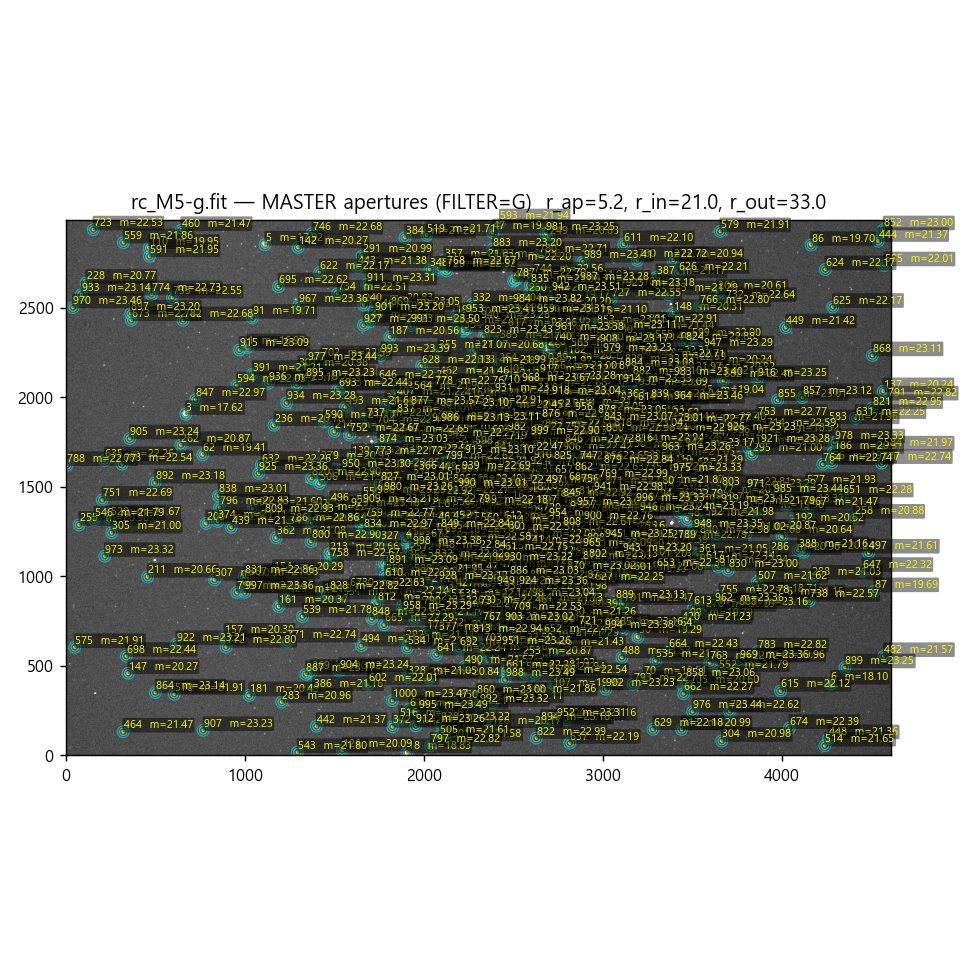

In [22]:
# === Cell 12 — Aperture/Annulus overlay (MASTER 좌표 + ID/등급 라벨) ===
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize

RESULT_DIR = Path(RESULT_DIR)

# 표시 옵션
LABEL_LIMIT          = int(getattr(P, "overlay_max_labels", 2000))
LABEL_FONT_SIZE      = float(getattr(P, "overlay_label_fontsize", 6.0))
LABEL_OFFSET         = float(getattr(P, "overlay_label_offset_px", 3.0))
SHOW_ID_WHEN_NO_MAG  = bool(getattr(P, "overlay_show_id_when_no_mag", False))  # ← False면 등급 없는 대상은 라벨 없음

# 대상 프레임
idx = int(getattr(P, "inspect_index", 0))
idx = max(0, min(idx, len(r_filenames)-1))
fname = r_filenames[idx]

# 데이터 로드
img = fits.getdata(RESULT_DIR/fname).astype(float)
master = pd.read_csv(RESULT_DIR/"master_catalog.tsv", sep="\t")
df_ap  = pd.read_csv(RESULT_DIR/"aperture_by_frame.csv")

row = df_ap[df_ap["file"]==fname]
if row.empty:
    raise RuntimeError(f"aperture_by_frame.csv에 {fname} 레코드 없음(8번 셀 실행 필요).")
r_ap  = float(row["r_ap"].values[0]); r_in  = float(row["r_in"].values[0]); r_out = float(row["r_out"].values[0])

# phot 결과
phot_path = RESULT_DIR / f"{fname}_photometry.tsv"
phot = None
if phot_path.exists():
    try:
        phot = pd.read_csv(phot_path, sep="\t")
        keep = ["ID","mag","mag_err","xcenter","ycenter"]
        phot = phot[[c for c in keep if c in phot.columns]].copy()
    except Exception:
        phot = None

lab = master[["ID","x_ref","y_ref"]].copy()
if phot is not None:
    lab = lab.merge(phot, on="ID", how="left")
else:
    lab["mag"] = np.nan; lab["mag_err"] = np.nan
    lab["xcenter"] = np.nan; lab["ycenter"] = np.nan

# 우선순위: 등급 있는 것 → 밝은 순 → ID
lab["_has_mag"] = np.isfinite(lab["mag"])
lab["_mag_for_sort"] = lab["mag"].fillna(99.0)
lab = lab.sort_values(by=["_has_mag","_mag_for_sort","ID"], ascending=[False, True, True])
lab_sel = lab.head(LABEL_LIMIT).copy()

# 디스플레이
vmin, vmax = ZScaleInterval().get_limits(img)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(7.5,7.5), dpi=130)
plt.imshow(img, origin="lower", cmap="gray", norm=norm)

try:
    filt = get_filter_from_fits(RESULT_DIR/fname).upper()
except Exception:
    filt = "UNKNOWN"
plt.title(f"{fname} — MASTER apertures (FILTER={filt})  r_ap={r_ap:.1f}, r_in={r_in:.1f}, r_out={r_out:.1f}")

ax = plt.gca()

# 원 (MASTER 좌표)
for (x,y) in master[["x_ref","y_ref"]].to_numpy(float):
    ax.add_patch(Circle((x,y), r_ap,  ec="gold",  fc="none", lw=0.8, alpha=0.9))
    ax.add_patch(Circle((x,y), r_in,  ec="cyan",  fc="none", lw=0.6, alpha=0.7))
    ax.add_patch(Circle((x,y), r_out, ec="cyan",  fc="none", lw=0.6, alpha=0.5))

# 라벨: 등급 있으면 "ID  m=xx.xx", 없으면 옵션에 따라 ID만
for _, r in lab_sel.iterrows():
    x = float(r["x_ref"]); y = float(r["y_ref"])
    ID = int(r["ID"])
    if np.isfinite(r["mag"]):
        txt = f"{ID}  m={r['mag']:.2f}"
    else:
        if not SHOW_ID_WHEN_NO_MAG:
            continue
        txt = f"{ID}"
    ax.text(x+LABEL_OFFSET, y+LABEL_OFFSET, txt,
            color='yellow', fontsize=LABEL_FONT_SIZE, ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.12', fc=(0,0,0,0.45), ec='none'))

plt.xlim(0, img.shape[1]); plt.ylim(0, img.shape[0])
plt.tight_layout(); plt.show()


In [23]:
# === Cell 13 — MASTER↔Catalog 매칭 + 표준화 (wide에 x,y 없을 때 master_catalog.tsv에서 보강) ===
import re, math
import numpy as np
import pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.table import Table

# 0) photometry index 찾기 (리팩토링/구버전 모두 대응)
idx_candidates = [
    RESULT_DIR/"photometry_index.csv",
    RESULT_DIR/"phot_index.csv",
    RESULT_DIR/"phot"/"phot_index.csv",
    RESULT_DIR/"phot"/"photometry_index.csv",
]
idx_candidates += sorted(RESULT_DIR.glob("*phot*index*.csv"))
if (RESULT_DIR/"phot").exists():
    idx_candidates += sorted((RESULT_DIR/"phot").glob("*phot*index*.csv"))

idx_path = next((p for p in idx_candidates if p.exists()), None)
if idx_path is None:
    raise FileNotFoundError(
        "photometry index(csv)를 찾지 못했습니다.\n"
        "→ Cell 11(Forced Photometry) 실행 후 index 생성 여부 확인!"
    )

idx = pd.read_csv(idx_path)
print(f"[Cell12] index = {idx_path} | rows={len(idx)}")

# 컬럼 표준화
if "path" not in idx.columns:
    for cand in ("phot_tsv","tsv","out","output"):
        if cand in idx.columns:
            idx = idx.rename(columns={cand:"path"})
            break
if "filter" in idx.columns:
    idx["filter"] = idx["filter"].astype(str).str.strip().str.lower()
elif "FILTER" in idx.columns:
    idx["filter"] = idx["FILTER"].astype(str).str.strip().str.lower()
else:
    idx["filter"] = "unknown"

# 1) QC 통과 프레임만 사용(있으면)
fq_path = RESULT_DIR/"frame_quality.csv"
if fq_path.exists() and ("file" in idx.columns):
    fq = pd.read_csv(fq_path)
    if ("file" in fq.columns) and ("passed" in fq.columns):
        idx = idx.merge(fq[["file","passed"]], on="file", how="left")
        idx = idx[idx["passed"] != False].copy()
        print(f"[Cell12] QC passed only | rows={len(idx)}")

# 2) 각 프레임 TSV 읽어서 합치기
def _resolve_path(p):
    p = str(p)
    if p.strip() == "":
        return None
    P0 = Path(p)
    if P0.is_absolute() and P0.exists():
        return P0
    # relative 후보 (RESULT_DIR 기준 + phot 하위 등)
    for base in (RESULT_DIR, RESULT_DIR/"phot", RESULT_DIR/"photometry", RESULT_DIR/"result"):
        P1 = base / p
        if P1.exists():
            return P1
    return None

rows = []
for _, r in idx.iterrows():
    p = _resolve_path(r.get("path",""))
    if p is None or (not p.exists()):
        continue

    # 대부분 TSV
    try:
        df = pd.read_csv(p, sep="\t")
    except Exception:
        df = pd.read_csv(p)

    if "ID" not in df.columns:
        raise RuntimeError(f"[Cell12] {p.name}: ID 컬럼 없음")

    # FILTER
    if "FILTER" in df.columns:
        df["FILTER"] = df["FILTER"].astype(str).str.strip().str.lower()
    else:
        df["FILTER"] = str(r.get("filter","unknown")).strip().lower()

    # mag / err / snr 컬럼 통일
    mag_col = "mag_inst" if "mag_inst" in df.columns else ("mag" if "mag" in df.columns else None)
    if mag_col is None:
        raise RuntimeError(f"[Cell12] {p.name}: mag_inst/mag 컬럼을 못 찾음")

    err_col = "emag" if "emag" in df.columns else ("mag_err" if "mag_err" in df.columns else None)
    if err_col is None:
        df["mag_err"] = np.nan
        err_col = "mag_err"

    if "snr" not in df.columns:
        df["snr"] = np.nan

    tmp = df[["ID","FILTER",mag_col,err_col,"snr"]].copy()
    tmp = tmp.rename(columns={mag_col:"mag_inst", err_col:"mag_err"})
    rows.append(tmp)

all_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["ID","FILTER","mag_inst","mag_err","snr"])
all_df["FILTER"] = all_df["FILTER"].astype(str).str.strip().str.lower()
print(f"[Cell12] merged rows={len(all_df)} | unique IDs={all_df['ID'].nunique()} | filters={sorted(all_df['FILTER'].unique())}")

def _robust_med_err(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return (np.nan, np.nan, 0)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)))
    err = float(1.4826 * mad / np.sqrt(max(len(x), 1)))
    return (med, err, int(len(x)))

grp = (all_df.groupby(["ID","FILTER"]).agg(
    mag_inst_med=("mag_inst", lambda s: _robust_med_err(s)[0]),
    mag_inst_med_err=("mag_inst", lambda s: _robust_med_err(s)[1]),
    n_frames=("mag_inst", lambda s: _robust_med_err(s)[2]),
    snr_med=("snr", lambda s: float(np.nanmedian(np.asarray(s, float))) if np.isfinite(np.asarray(s, float)).any() else np.nan),
).reset_index())

grp.to_csv(RESULT_DIR/"median_by_ID_filter.csv", index=False, na_rep="NaN")
print("[Cell12] Saved → median_by_ID_filter.csv | rows:", len(grp))

# wide: mag_inst_* / err / snr
wide_mag = grp.pivot_table(index="ID", columns="FILTER", values="mag_inst_med", aggfunc="median")
wide_err = grp.pivot_table(index="ID", columns="FILTER", values="mag_inst_med_err", aggfunc="median")
wide_snr = grp.pivot_table(index="ID", columns="FILTER", values="snr_med", aggfunc="median")

wide_mag.columns = [f"mag_inst_{c}" for c in wide_mag.columns]
wide_err.columns = [f"mag_inst_err_{c}" for c in wide_err.columns]
wide_snr.columns = [f"snr_{c}" for c in wide_snr.columns]

wide = pd.concat([wide_mag, wide_err, wide_snr], axis=1).reset_index()
wide.to_csv(RESULT_DIR/"median_by_ID_filter_wide.csv", index=False, na_rep="NaN")
print("[Cell12] Saved → median_by_ID_filter_wide.csv | rows:", len(wide))


# -----------------------------
# 0) WCS 로드 (ref frame의 WCS)
# -----------------------------
wcs_txt = RESULT_DIR / "ref_wcs_header.txt"
if not wcs_txt.exists():
    raise RuntimeError("ref_wcs_header.txt가 없습니다. Cell 7(PlateSolve)을 먼저 실행하세요.")

hdr = fits.Header.fromstring(wcs_txt.read_text(encoding="utf-8"), sep="\n")
w = WCS(hdr)

# -----------------------------
# 1) Gaia 로드 (Cell 7 cache)
# -----------------------------
gaia_path = RESULT_DIR / "gaia_fov.ecsv"
if not gaia_path.exists():
    raise RuntimeError("gaia_fov.ecsv가 없습니다. Cell 7에서 Gaia 저장이 되었는지 확인하세요.")

t_gaia = Table.read(gaia_path, format="ascii.ecsv")
need = ["ra", "dec", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag"]
for k in ["ra","dec"]:
    if k not in t_gaia.colnames:
        raise RuntimeError(f"gaia_fov.ecsv에 '{k}' 컬럼이 없습니다.")

gaia_sky = SkyCoord(t_gaia["ra"], t_gaia["dec"], unit="deg", frame="icrs")
print(f"[Cell13] Gaia FOV 소스 수: N={len(t_gaia)}")

# -----------------------------
# 2) wide 로드
# -----------------------------
wide_candidates = [RESULT_DIR/"median_by_ID_filter_wide.csv"]
if not wide_candidates[0].exists():
    wide_candidates = sorted(list(RESULT_DIR.glob("*median_by_ID_filter_wide*.csv")))
if not wide_candidates:
    raise RuntimeError("median_by_ID_filter_wide.csv를 찾지 못했습니다.")

wide_path = wide_candidates[0]
df_wide = pd.read_csv(wide_path)
if "ID" not in df_wide.columns:
    raise RuntimeError(f"wide 파일에 ID 컬럼이 없습니다: {wide_path.name}")

print(f"[Cell13] wide 로드: {wide_path.name} | rows={len(df_wide)}")

# -----------------------------
# 3) 픽셀좌표 확보: (1) wide에 있으면 사용, (2) 없으면 master_catalog.tsv에서 merge
# -----------------------------
def _pick_col(cols, cands):
    for c in cands:
        if c in cols:
            return c
    return None

# wide에 좌표가 있는 경우(드물지만 대비)
col_xw = _pick_col(df_wide.columns, ["x","x_ref","x_med","x_center","x_pix","x0","xpos"])
col_yw = _pick_col(df_wide.columns, ["y","y_ref","y_med","y_center","y_pix","y0","ypos"])

df = df_wide.copy()

if (col_xw is not None) and (col_yw is not None):
    df["x_pix"] = df[col_xw].astype(float)
    df["y_pix"] = df[col_yw].astype(float)
    print(f"[Cell13] 좌표: wide에서 사용 ({col_xw},{col_yw})")
else:
    master_path = RESULT_DIR / "master_catalog.tsv"
    if not master_path.exists():
        raise RuntimeError(
            "wide에 x,y가 없고, master_catalog.tsv도 없습니다.\n"
            "→ Cell 9(마스터 편집)에서 master_catalog.tsv가 생성/저장되는지 확인하세요."
        )
    master = pd.read_csv(master_path, sep="\t")
    if "ID" not in master.columns:
        raise RuntimeError("master_catalog.tsv에 ID 컬럼이 없습니다.")

    col_xm = _pick_col(master.columns, ["x_ref","x","x_pix","x_center","x_med"])
    col_ym = _pick_col(master.columns, ["y_ref","y","y_pix","y_center","y_med"])
    if (col_xm is None) or (col_ym is None):
        raise RuntimeError(
            f"master_catalog.tsv에서 x/y 컬럼을 못 찾았습니다. cols={list(master.columns)[:30]} ..."
        )

    master_xy = master[["ID", col_xm, col_ym]].copy()
    master_xy = master_xy.rename(columns={col_xm:"x_pix", col_ym:"y_pix"})
    df = df.merge(master_xy, on="ID", how="left")

    n_ok = int(np.isfinite(df["x_pix"]).sum() if "x_pix" in df.columns else 0)
    print(f"[Cell13] 좌표: master_catalog.tsv에서 merge ({col_xm},{col_ym}) | 좌표유효={n_ok}/{len(df)}")

    if n_ok < 3:
        raise RuntimeError(
            "ID merge 후에도 x_pix/y_pix 유효값이 너무 적습니다.\n"
            "→ wide의 ID와 master_catalog.tsv의 ID가 같은지(중간에 재생성/덮어쓰기 여부) 확인하세요."
        )

# -----------------------------
# 4) MASTER 픽셀 -> 하늘좌표
# -----------------------------
x = df["x_pix"].to_numpy(float)
y = df["y_pix"].to_numpy(float)

m_xy = np.isfinite(x) & np.isfinite(y)
ra_m, dec_m = np.full(len(df), np.nan), np.full(len(df), np.nan)
ra_tmp, dec_tmp = w.all_pix2world(x[m_xy], y[m_xy], 0)
ra_m[m_xy] = np.asarray(ra_tmp, float)
dec_m[m_xy] = np.asarray(dec_tmp, float)

sky_m = SkyCoord(ra_m*u.deg, dec_m*u.deg, frame="icrs")

# -----------------------------
# 5) 매칭 (px -> arcsec)
# -----------------------------
match_tol_px = float(getattr(P, "match_tol_px", 1.0))
pix_scale_arcsec = float(getattr(P, "pixel_scale_arcsec", np.nan))
if not np.isfinite(pix_scale_arcsec) or pix_scale_arcsec <= 0:
    raise RuntimeError("P.pixel_scale_arcsec가 유효하지 않습니다.")
match_tol_arcsec = match_tol_px * pix_scale_arcsec

idx, sep2d, _ = sky_m.match_to_catalog_sky(gaia_sky)
m = np.isfinite(sep2d.arcsec) & (sep2d.arcsec <= match_tol_arcsec)

dfm = df.loc[m].copy()
dfm["gaia_idx"] = idx[m].astype(int)
dfm["sep_arcsec"] = sep2d.arcsec[m].astype(float)
dfm["dist_px"] = dfm["sep_arcsec"] / pix_scale_arcsec

print(f"[Cell13] match_tol_px={match_tol_px:.2f} → 매칭된 MASTER 수: N={len(dfm)}")
if len(dfm):
    print(f"[Cell13] dist_px min/med/max = {dfm['dist_px'].min():.2f} / {dfm['dist_px'].median():.2f} / {dfm['dist_px'].max():.2f}")

MIN_MATCH = int(getattr(P, "min_master_gaia_matches", 10))
if len(dfm) < MIN_MATCH:
    print(f"[Cell13] 매칭이 너무 적음 (N={len(dfm)} < {MIN_MATCH}) → 표준화 스킵.")
    # 그래도 디버깅용으로 저장
    dfm.to_csv(RESULT_DIR/"gaia_sdss_calibrator_by_ID.csv", index=False)
    print("[Cell13] Saved → gaia_sdss_calibrator_by_ID.csv (matched subset only)")
else:
    # -----------------------------
    # 6) 캘리브레이터 저장
    # -----------------------------
    gG  = np.asarray(t_gaia["phot_g_mean_mag"])[dfm["gaia_idx"].to_numpy(int)]
    bp = np.asarray(t_gaia["phot_bp_mean_mag"])[dfm["gaia_idx"].to_numpy(int)] if "phot_bp_mean_mag" in t_gaia.colnames else np.full(len(dfm), np.nan)
    rp = np.asarray(t_gaia["phot_rp_mean_mag"])[dfm["gaia_idx"].to_numpy(int)] if "phot_rp_mean_mag" in t_gaia.colnames else np.full(len(dfm), np.nan)
    bprp = bp - rp

    out_cal = dfm.copy()
    out_cal["gaia_G"] = gG
    out_cal["gaia_BP"] = bp
    out_cal["gaia_RP"] = rp
    out_cal["gaia_BP_RP"] = bprp

    out_path = RESULT_DIR / "gaia_sdss_calibrator_by_ID.csv"  # 네가 쓰던 이름 유지
    out_cal.to_csv(out_path, index=False)
    print(f"[Cell13] Saved → {out_path.name} (rows={len(out_cal)})")

    # -----------------------------
    # 7) (안전모드) Gaia G 기준:  Δ = G - g_inst = a + b*(BP-RP)
    # -----------------------------
    def robust_fit(color, delta, b_abs_max=2.0, clip_sigma=3.0, iters=5):
        color = np.asarray(color, float)
        delta = np.asarray(delta, float)
        m0 = np.isfinite(color) & np.isfinite(delta)
        x = color[m0]; y = delta[m0]
        if len(x) < 8:
            return (float(np.nanmedian(y)) if len(y) else np.nan, 0.0, len(x))

        a, b = np.polyfit(x, y, 1)
        for _ in range(iters):
            yhat = a + b*x
            r = y - yhat
            med = np.median(r)
            mad = np.median(np.abs(r - med)) + 1e-9
            sig = 1.4826 * mad
            keep = np.abs(r - med) <= clip_sigma*sig
            if keep.sum() < 8:
                break
            x2, y2 = x[keep], y[keep]
            a, b = np.polyfit(x2, y2, 1)
            x, y = x2, y2

        if abs(b) > b_abs_max:
            return (float(np.median(y)), 0.0, len(x))
        return (float(a), float(b), len(x))

    # mag_inst_g 컬럼 찾기 (네 wide는 mag_inst_g 고정이라 우선 그걸 먼저)
    def find_mag_inst_col(filt):
        cand = [
            f"mag_inst_{filt}",
            f"mag_{filt}_inst",
            f"maginst_{filt}",
        ]
        for c in cand:
            if c in df.columns:
                return c
        # fallback: mag & inst & _{filt}
        hit = [c for c in df.columns if ("mag" in c.lower() and "inst" in c.lower() and f"_{filt}" in c.lower())]
        return hit[0] if hit else None

    col_g = find_mag_inst_col("g")
    if col_g is None:
        raise RuntimeError(f"instrumental g 컬럼을 못 찾았습니다. cols={list(df.columns)[:30]} ...")

    g_inst_m = dfm[col_g].to_numpy(float)
    deltaG = gG - g_inst_m

    aG, bG, nG = robust_fit(
        out_cal["gaia_BP_RP"].to_numpy(float),
        deltaG,
        b_abs_max=float(getattr(P, "color_slope_absmax", 2.0)),
        clip_sigma=float(getattr(P, "color_clip_sigma", 3.0)),
        iters=int(getattr(P, "color_fit_iters", 5)),
    )
    print(f"[Cell13] Gaia-G calib: Δ = {aG:+.3f} + {bG:+.3f}·(BP-RP)  (N={nG})")

    # -----------------------------
    # 8) wide 전체에 적용: 색항은 전체에 BP-RP가 없으므로 '영점만' 안전 적용
    # -----------------------------
    df_out = df_wide.copy()
    df_out["g_calib_like_G"] = df_out[col_g].to_numpy(float) + aG

    df_out_path = RESULT_DIR / "median_by_ID_filter_wide_calib.csv"
    df_out.to_csv(df_out_path, index=False)
    print(f"[Cell13] Saved → {df_out_path.name} | rows={len(df_out)}")



def poly_eval(x, coeffs):
    """a0 + a1*x + a2*x^2 + ..."""
    x = np.asarray(x, float)
    y = np.zeros_like(x, dtype=float)
    p = np.ones_like(x, dtype=float)
    for a in coeffs:
        y += a * p
        p *= x
    return y

def robust_linfit(x, y, clip_sigma=3.0, iters=5, slope_absmax=1.0, min_n=10):
    """y = a + b*x (sigma-clip)"""
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if len(x) < min_n:
        return (float(np.nanmedian(y)) if len(y) else np.nan, 0.0, len(x))

    a, b = np.polyfit(x, y, 1)  # y ~ a*x + b  (주의)
    # polyfit은 (slope, intercept) 반환 → 아래에서 정리
    slope, intercept = a, b

    for _ in range(iters):
        yhat = intercept + slope * x
        r = y - yhat
        med = np.nanmedian(r)
        mad = np.nanmedian(np.abs(r - med)) + 1e-12
        sig = 1.4826 * mad
        keep = np.abs(r - med) <= clip_sigma * sig
        if keep.sum() < min_n:
            break
        slope, intercept = np.polyfit(x[keep], y[keep], 1)

        x = x[keep]; y = y[keep]

    if abs(slope) > slope_absmax:
        # 색항이 비정상적으로 튀면 영점만
        return (float(np.nanmedian(y)), 0.0, len(x))

    return float(intercept), float(slope), len(x)  # a0(영점), a1(색항), N

# -----------------------------
# 1) calibrator(out_cal)에서 Gaia → SDSS(g,r,i) "표준값" 만들기
#    (Riello+ 2021, Gaia EDR3 Table C.2, x = (BP-RP))  :contentReference[oaicite:1]{index=1}
# -----------------------------
x = out_cal["gaia_BP_RP"].to_numpy(float)
G = out_cal["gaia_G"].to_numpy(float)

# 유효범위(필요시 마스크): Table C.1 :contentReference[oaicite:2]{index=2}
m_g = np.isfinite(x) & (x >= 0.3) & (x <= 3.0)
m_r = np.isfinite(x) & (x >= 0.0) & (x <= 3.0)
m_i = np.isfinite(x) & (x >= 0.5) & (x <= 2.0)

# Table C.2 (SDSS12, argument=BP-RP):  G - band = poly(x)  :contentReference[oaicite:3]{index=3}
G_minus_g = np.full_like(G, np.nan)
G_minus_r = np.full_like(G, np.nan)
G_minus_i = np.full_like(G, np.nan)

G_minus_g[m_g] = poly_eval(x[m_g], [0.2199, -0.6365, -0.1548, 0.0064])              # up to x^3
G_minus_r[m_r] = poly_eval(x[m_r], [-0.09837, 0.08592, 0.1907, -0.1701, 0.02263])   # up to x^4
G_minus_i[m_i] = poly_eval(x[m_i], [-0.293, 0.6404, -0.09609, -0.002104])           # up to x^3

sdss_g_ref = G - G_minus_g
sdss_r_ref = G - G_minus_r
sdss_i_ref = G - G_minus_i

out_cal["sdss_g_ref"] = sdss_g_ref
out_cal["sdss_r_ref"] = sdss_r_ref
out_cal["sdss_i_ref"] = sdss_i_ref

# -----------------------------
# 2) inst → std 피팅 (영점 + 간단 색항)
#    g: color = (g_inst - r_inst)
#    r: color = (g_inst - r_inst)
#    i: color = (r_inst - i_inst)
# -----------------------------
def getcol(df, name):
    if name not in df.columns:
        raise RuntimeError(f"필수 컬럼 없음: {name}")
    return df[name].to_numpy(float)

g_inst = getcol(out_cal, "mag_inst_g")
r_inst = getcol(out_cal, "mag_inst_r")
i_inst = getcol(out_cal, "mag_inst_i")

# (선택) SNR 컷: 있으면 calibrator에서만 적용
snr_cut = float(getattr(P, "cmd_snr_calib_min", 20.0)) if "P" in globals() else 20.0
m_snr = np.ones(len(out_cal), dtype=bool)
for b in ["g","r","i"]:
    c = f"snr_{b}"
    if c in out_cal.columns:
        m_snr &= np.isfinite(out_cal[c].to_numpy(float)) & (out_cal[c].to_numpy(float) >= snr_cut)

# g band
color_gr = g_inst - r_inst
delta_g = out_cal["sdss_g_ref"].to_numpy(float) - g_inst
mg = np.isfinite(delta_g) & np.isfinite(color_gr) & m_snr
zp_g, ct_g, Ng = robust_linfit(color_gr[mg], delta_g[mg],
                              clip_sigma=float(getattr(P,"zp_clip_sigma",3.0)) if "P" in globals() else 3.0,
                              iters=int(getattr(P,"zp_fit_iters",5)) if "P" in globals() else 5,
                              slope_absmax=float(getattr(P,"zp_slope_absmax",1.0)) if "P" in globals() else 1.0,
                              min_n=int(getattr(P,"min_master_gaia_matches",10)) if "P" in globals() else 10)

# r band
delta_r = out_cal["sdss_r_ref"].to_numpy(float) - r_inst
mr = np.isfinite(delta_r) & np.isfinite(color_gr) & m_snr
zp_r, ct_r, Nr = robust_linfit(color_gr[mr], delta_r[mr],
                              clip_sigma=float(getattr(P,"zp_clip_sigma",3.0)) if "P" in globals() else 3.0,
                              iters=int(getattr(P,"zp_fit_iters",5)) if "P" in globals() else 5,
                              slope_absmax=float(getattr(P,"zp_slope_absmax",1.0)) if "P" in globals() else 1.0,
                              min_n=int(getattr(P,"min_master_gaia_matches",10)) if "P" in globals() else 10)

# i band
color_ri = r_inst - i_inst
delta_i = out_cal["sdss_i_ref"].to_numpy(float) - i_inst
mi = np.isfinite(delta_i) & np.isfinite(color_ri) & m_snr
zp_i, ct_i, Ni = robust_linfit(color_ri[mi], delta_i[mi],
                              clip_sigma=float(getattr(P,"zp_clip_sigma",3.0)) if "P" in globals() else 3.0,
                              iters=int(getattr(P,"zp_fit_iters",5)) if "P" in globals() else 5,
                              slope_absmax=float(getattr(P,"zp_slope_absmax",1.0)) if "P" in globals() else 1.0,
                              min_n=int(getattr(P,"min_master_gaia_matches",10)) if "P" in globals() else 10)

print(f"[Cell13-FIX] g: mag_std = inst + {zp_g:+.4f} + {ct_g:+.4f}*(g-r)_inst   (N={Ng})")
print(f"[Cell13-FIX] r: mag_std = inst + {zp_r:+.4f} + {ct_r:+.4f}*(g-r)_inst   (N={Nr})")
print(f"[Cell13-FIX] i: mag_std = inst + {zp_i:+.4f} + {ct_i:+.4f}*(r-i)_inst   (N={Ni})")

# -----------------------------
# 3) wide 전체에 mag_std_* 적용 + synthetic Gaia 생성
# -----------------------------
df_out = df_wide.copy()
gI = df_out["mag_inst_g"].to_numpy(float)
rI = df_out["mag_inst_r"].to_numpy(float)
iI = df_out["mag_inst_i"].to_numpy(float)

col_gr_inst = gI - rI
col_ri_inst = rI - iI

df_out["mag_std_g"] = gI + zp_g + ct_g * col_gr_inst
df_out["mag_std_r"] = rI + zp_r + ct_r * col_gr_inst
df_out["mag_std_i"] = iI + zp_i + ct_i * col_ri_inst

# --- SDSS(std) → synthetic Gaia (G, BP-RP)
#     (Riello+ 2021 Table C.2, argument = (g-i))  :contentReference[oaicite:4]{index=4}
gi = df_out["mag_std_g"].to_numpy(float) - df_out["mag_std_i"].to_numpy(float)

# 유효범위: Table C.1 SDSS12  :contentReference[oaicite:5]{index=5}
m_gi = np.isfinite(gi) & (gi >= 1.0) & (gi <= 9.0)

G_minus_g_from_gi = np.full(len(df_out), np.nan)
BPmRP_from_gi     = np.full(len(df_out), np.nan)

# G - g = -0.1064 -0.4964*(g-i) -0.09339*(g-i)^2 +0.004444*(g-i)^3
G_minus_g_from_gi[m_gi] = poly_eval(gi[m_gi], [-0.1064, -0.4964, -0.09339, 0.004444])
# BP-RP = 0.3971 +0.777*(g-i) -0.04164*(g-i)^2 +0.008237*(g-i)^3
BPmRP_from_gi[m_gi]     = poly_eval(gi[m_gi], [0.3971, 0.777, -0.04164, 0.008237])

df_out["gaia_G_syn"]      = df_out["mag_std_g"].to_numpy(float) + G_minus_g_from_gi
df_out["gaia_BP_RP_syn"]  = BPmRP_from_gi

# -----------------------------
# 4) 저장 (Cell14가 읽도록 “새 파일” + (원하면) 덮어쓰기)
# -----------------------------
out_wide_cmd = RESULT_DIR / "median_by_ID_filter_wide_cmd.csv"
df_out.to_csv(out_wide_cmd, index=False)
print(f"[Cell13-FIX] Saved → {out_wide_cmd.name}")

# (옵션) Cell14를 안 고치고 싶으면 아래 한 줄로 wide.csv에 덮어쓰기:
# df_out.to_csv(RESULT_DIR / "median_by_ID_filter_wide.csv", index=False)


[Cell12] index = C:\Users\bmffr\Desktop\Result\Aperture_Photometry_KNUEMAO\data\M5\result\photometry_index.csv | rows=3
[Cell12] QC passed only | rows=3
[Cell12] merged rows=3000 | unique IDs=1000 | filters=['g', 'i', 'r']
[Cell12] Saved → median_by_ID_filter.csv | rows: 3000
[Cell12] Saved → median_by_ID_filter_wide.csv | rows: 1000
[Cell13] Gaia FOV 소스 수: N=39830
[Cell13] wide 로드: median_by_ID_filter_wide.csv | rows=1000
[Cell13] 좌표: master_catalog.tsv에서 merge (x_ref,y_ref) | 좌표유효=1000/1000
[Cell13] match_tol_px=1.00 → 매칭된 MASTER 수: N=899
[Cell13] dist_px min/med/max = 0.01 / 0.27 / 0.98
[Cell13] Saved → gaia_sdss_calibrator_by_ID.csv (rows=899)
[Cell13] Gaia-G calib: Δ = -6.249 + +0.000·(BP-RP)  (N=672)
[Cell13] Saved → median_by_ID_filter_wide_calib.csv | rows=1000
[Cell13-FIX] g: mag_std = inst + -5.7006 + +0.1556*(g-r)_inst   (N=363)
[Cell13-FIX] r: mag_std = inst + -6.2335 + +0.0081*(g-r)_inst   (N=367)
[Cell13-FIX] i: mag_std = inst + -7.1963 + +0.0000*(r-i)_inst   (N=378)
[Cel

In [24]:
# === Cell 14: CMD 플로터 (Instrumental / SDSS / 내 SDSS→synthetic Gaia) ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import (
    HBox, VBox, HTML,
    ToggleButtons, Dropdown, FloatSlider,
    Checkbox, Button, Layout, Output
)
from IPython.display import display

# ---- 결과 디렉터리 ----
try:
    RESULT = RESULT_DIR
except NameError:
    RESULT = Path("./result")
RESULT = Path(RESULT)

wide_path = RESULT / "median_by_ID_filter_wide_cmd.csv"
if not wide_path.exists():
    wide_path = RESULT / "median_by_ID_filter_wide.csv"

wide = pd.read_csv(wide_path)

# --- Gaia/SDSS 표준계 유무 체크 (mag_std_*에 유효 값이 있는지) -------------
std_cols_full = [c for c in wide.columns if c.startswith("mag_std_")]
has_std_cols  = len(std_cols_full) > 0
has_std_valid = False
if has_std_cols:
    std_vals = wide[std_cols_full].to_numpy(dtype="float64")
    has_std_valid = np.isfinite(std_vals).any()

HAS_STD = has_std_cols and has_std_valid

# --- Instrumental / SDSS 밴드 목록 ----------------------------------------
inst_bands = sorted({c.replace("mag_inst_","") for c in wide.columns
                     if c.startswith("mag_inst_")})

if HAS_STD:
    std_bands  = sorted({c.replace("mag_std_","") for c in wide.columns
                         if c.startswith("mag_std_")})
else:
    std_bands = []

all_bands = sorted(set(inst_bands) | set(std_bands))

# 실제로 CMD에 쓸 후보 밴드 (g,r,i 중에서만)
present = [b for b in ("g","r","i") if b in all_bands]

# 허용 축 조합
X_ALLOWED = [("g","r"), ("r","i")]          # g-r, r-i
Y_ALLOWED_SCALARS = ["g","r","i"]
Y_ALLOWED_COLORS  = [("g","r"), ("r","i")]  # g-r, r-i

# instrument에서 존재하는 조합만 허용
x_pairs = [(a,b) for (a,b) in X_ALLOWED
           if (a in inst_bands and b in inst_bands)]
y_scalar_opts = [b for b in Y_ALLOWED_SCALARS if b in inst_bands]
y_color_pairs = [(a,b) for (a,b) in Y_ALLOWED_COLORS
                 if (a in inst_bands and b in inst_bands)]

# --- SNR 컬럼 존재 여부 (wide에서 바로 사용) -------------------------------
df = wide.copy()
snr_cols = [c for c in df.columns if c.startswith("snr_")]
HAS_SNR = len(snr_cols) > 0
if HAS_SNR:
    snr_bands_available = sorted(c.replace("snr_","") for c in snr_cols)
    print("[Cell14] SNR 사용 가능 밴드:", snr_bands_available)
else:
    print("[Cell14] snr_* 컬럼을 찾지 못함 → SNR 슬라이더는 형식상만 존재 (필터링 없음).")

# --- synthetic Gaia (Cell 13에서 만든 것) 존재 여부 ------------------------
HAS_GAIA_SYNTH = (
    {"gaia_G_syn","gaia_BP_RP_syn"}.issubset(df.columns)
    and np.isfinite(df["gaia_G_syn"].to_numpy(float)).any()
)

if HAS_GAIA_SYNTH:
    print("[Cell14] synthetic Gaia CMD: gaia_G_syn / gaia_BP_RP_syn 사용.")
else:
    print("[Cell14] synthetic Gaia CMD용 gaia_G_syn / gaia_BP_RP_syn 컬럼 없음 → 우측 패널 비활성.")

# --- 유틸 ---------------------------------------------------------------------
def _col_mag(band: str, system: str) -> str:
    """system='inst' 또는 'std'."""
    if system == "inst":
        return f"mag_inst_{band}"
    elif system == "std":
        return f"mag_std_{band}"
    else:
        raise ValueError(f"Unknown system: {system}")

def _col_snr(band: str) -> str:
    return f"snr_{band}"

def _label_color(a,b):
    return f"{a}-{b}"

def _get_y_mode(yval):
    """('scalar', band) or ('color', (a,b))"""
    if yval in y_scalar_opts:
        return ("scalar", yval)
    if isinstance(yval, str) and "-" in yval:
        a,b = yval.split("-",1)
        if (a,b) in y_color_pairs:
            return ("color", (a,b))
    return (None, None)

def _compute_arrays(system: str, x_pair, y_choice, snr_cut: float):
    """
    system: 'inst' or 'std'
    x_pair: (a,b) → X = mag(a) - mag(b)
    y_choice: 'g','r','i','g-r','r-i'
    """
    a, b = x_pair
    colAx = _col_mag(a, system)
    colBx = _col_mag(b, system)
    if (colAx not in df.columns) or (colBx not in df.columns):
        return np.array([]), np.array([])

    x = df[colAx].to_numpy(float) - df[colBx].to_numpy(float)

    y_mode, y_param = _get_y_mode(y_choice)
    involved_bands = set([a,b])

    if y_mode == "scalar":
        band_y = y_param
        colY = _col_mag(band_y, system)
        if colY not in df.columns:
            return np.array([]), np.array([])
        y = df[colY].to_numpy(float)
        involved_bands.add(band_y)
    elif y_mode == "color":
        ya, yb = y_param
        colYa = _col_mag(ya, system)
        colYb = _col_mag(yb, system)
        if (colYa not in df.columns) or (colYb not in df.columns):
            return np.array([]), np.array([])
        y = df[colYa].to_numpy(float) - df[colYb].to_numpy(float)
        involved_bands.update([ya,yb])
    else:
        return np.array([]), np.array([])

    mask = np.isfinite(x) & np.isfinite(y)

    # SNR 컷: 관련된 모든 밴드에 대해 instrument SNR 기준으로 적용
    snr_cut = float(snr_cut)
    if snr_cut > 0 and HAS_SNR:
        any_snr = False
        for band in involved_bands:
            sc = _col_snr(band)
            if sc in df.columns:
                any_snr = True
                svals = df[sc].to_numpy(float)
                mask &= np.isfinite(svals) & (svals >= snr_cut)
        # any_snr=False이면 SNR컷 효과 없음

    return x[mask], y[mask]

def _compute_gaia_from_sdss_arrays(snr_cut: float):
    """
    Cell 13에서 저장한 synthetic Gaia CMD용
    X = (BP-RP)_synth, Y = G_synth
    """
    if not HAS_GAIA_SYNTH:
        return np.array([]), np.array([])

    G_arr     = df["gaia_G_syn"].to_numpy(float)
    BPmRP_arr = df["gaia_BP_RP_syn"].to_numpy(float)

    mask = np.isfinite(G_arr) & np.isfinite(BPmRP_arr)

    # SNR 컷은 instrument SNR(g,r,i 중 하나라도 있는 경우)에 기반
    snr_cut = float(snr_cut)
    if snr_cut > 0 and HAS_SNR:
        any_snr = False
        for band in ("g","r","i"):
            sc = _col_snr(band)
            if sc in df.columns:
                any_snr = True
                svals = df[sc].to_numpy(float)
                mask &= np.isfinite(svals) & (svals >= snr_cut)
        # any_snr=False이면 SNR컷 효과 없음

    return BPmRP_arr[mask], G_arr[mask]

# --- 위젯 ---------------------------------------------------------------------
if HAS_STD and HAS_GAIA_SYNTH:
    help_text = (
        "<b>CMD:</b> 왼쪽은 기기등급(instrumental), "
        "가운데는 Gaia→SDSS 표준화(mag_std) CMD, "
        "오른쪽은 <i>내 SDSS 표준등급에서 다시 변환한 synthetic Gaia CMD</i>입니다. "
        "<br>X축은 g−r / r−i, Y축은 g/r/i 또는 색지수 선택(SNR 컷/축 반전 모두 세 패널에 공통 적용)."
    )
elif HAS_STD and (not HAS_GAIA_SYNTH):
    help_text = (
        "<b>CMD:</b> 왼쪽은 기기등급(instrumental), 가운데는 Gaia→SDSS 표준화(mag_std) CMD입니다. "
        "synthetic Gaia CMD용 컬럼(gaia_G_syn, gaia_BP_RP_syn)을 찾지 못해 우측 패널은 비활성입니다."
    )
else:
    help_text = (
        "<b>CMD:</b> 현재 Gaia/SDSS 표준계 캘리브레이션을 찾지 못해 "
        "<b>기기등급 CMD만</b> 표시합니다. "
        "(Gaia→SDSS / SDSS→Gaia 패널은 비활성)"
    )

help_html = HTML(help_text, layout=Layout(margin="0 0 6px 0"))

x_options = [_label_color(a,b) for (a,b) in x_pairs] if x_pairs else ["(없음)"]
x_map = { _label_color(a,b):(a,b) for (a,b) in x_pairs }
x_toggle = ToggleButtons(options=x_options, description="X(color):",
                         layout=Layout(width="260px"), disabled=(len(x_options)==0))

y_labels_scalar = y_scalar_opts
y_labels_color  = [_label_color(a,b) for (a,b) in y_color_pairs]
y_options = y_labels_scalar + y_labels_color if (y_labels_scalar or y_labels_color) else ["(없음)"]
y_default = (y_labels_scalar[0] if y_labels_scalar else
             (y_labels_color[0] if y_labels_color else None))
y_band = Dropdown(options=y_options, value=y_default, description="Y:",
                  layout=Layout(width="160px"), disabled=(len(y_options)==0))

snr_min = FloatSlider(value=20.0, min=0.0, max=100.0, step=1.0,
                      description="SNR≥", readout_format=".0f",
                      layout=Layout(width="210px"))
invert_y = Checkbox(value=True, description="Y축 반전 (밝을수록 위)")
save_btn = Button(description="PNG로 저장", tooltip="현재 설정으로 PNG 저장", icon="save",
                  layout=Layout(width="130px"))

# --- Figure (좌: inst, 중간: std, 우: SDSS→Gaia synthetic) -------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 9
mpl.rcParams['axes.titlesize'] = 11

plt.ioff()
if HAS_STD and HAS_GAIA_SYNTH:
    fig, (ax_inst, ax_std, ax_gaia) = plt.subplots(1, 3, figsize=(15.0, 5.0), dpi=130)
elif HAS_STD and (not HAS_GAIA_SYNTH):
    fig, (ax_inst, ax_std) = plt.subplots(1, 2, figsize=(12.0, 5.0), dpi=130)
    ax_gaia = None
elif (not HAS_STD) and HAS_GAIA_SYNTH:
    # 이 경우는 거의 없겠지만, synthetic Gaia만 있는 상황
    fig, (ax_inst, ax_gaia) = plt.subplots(1, 2, figsize=(12.0, 5.0), dpi=130)
    ax_std = None
else:
    fig, ax_inst = plt.subplots(1, 1, figsize=(5.0, 5.0), dpi=130)
    ax_std  = None
    ax_gaia = None

info_out = Output(layout=Layout(height="90px", overflow="auto",
                                border="1px solid #444", padding="4px"))
_initializing = True

def _log_info(text):
    with info_out:
        from IPython.display import clear_output
        clear_output(wait=True)
        print(text)

def _apply_y_orientation():
    """invert_y 체크박스를 보고 각 축 y방향 통일."""
    axes = [ax_inst]
    if ax_std is not None:
        axes.append(ax_std)
    if ax_gaia is not None:
        axes.append(ax_gaia)

    for ax in axes:
        ymin, ymax = ax.get_ylim()
        if invert_y.value:
            if ymin < ymax:
                ax.set_ylim(ymax, ymin)
        else:
            if ymin > ymax:
                ax.set_ylim(ymax, ymin)

def _y_label_for_choice(yval: str) -> str:
    if yval is None:
        return ""
    if "-" in yval:
        return f"{yval} (mag)"
    else:
        return f"{yval} (mag)"

def _redraw(*_):
    global _initializing
    if _initializing:
        return

    ax_inst.clear()
    if ax_std is not None:
        ax_std.clear()
    if ax_gaia is not None:
        ax_gaia.clear()

    if (not x_pairs) or (x_toggle.value not in x_map):
        ax_inst.set_title("사용 가능한 X축(g−r / r−i)이 없습니다.", fontsize=10)
        if ax_std is not None:
            ax_std.set_visible(False)
        if ax_gaia is not None:
            ax_gaia.set_visible(False)
        fig.canvas.draw_idle()
        return

    x_pair = x_map[x_toggle.value]
    yval = y_band.value

    # instrument CMD
    x_i, y_i = _compute_arrays("inst", x_pair, yval, snr_min.value)

    # standard CMD (Gaia→SDSS 표준계)
    if HAS_STD and (ax_std is not None):
        x_s, y_s = _compute_arrays("std", x_pair, yval, snr_min.value)
    else:
        x_s, y_s = np.array([]), np.array([])

    # SDSS → synthetic Gaia CMD (G vs BP-RP)
    if HAS_GAIA_SYNTH and (ax_gaia is not None):
        x_g, y_g = _compute_gaia_from_sdss_arrays(snr_min.value)
    else:
        x_g, y_g = np.array([]), np.array([])

    # --- instrument plot -----------------------------------------------------
    if len(x_i):
        ax_inst.scatter(x_i, y_i, s=7, alpha=0.65, linewidths=0, rasterized=True)
        x_med_i = float(np.nanmedian(x_i))
        y_med_i = float(np.nanmedian(y_i))
        title_inst = f"Instrumental CMD  (N={len(x_i)})"
    else:
        ax_inst.set_title("Instrumental CMD: 유효 데이터 없음", fontsize=10)
        x_med_i = y_med_i = np.nan
        title_inst = "Instrumental CMD  (N=0)"

    ax_inst.set_title(title_inst, fontsize=11)

    # --- standard plot -------------------------------------------------------
    if HAS_STD and (ax_std is not None):
        if len(x_s):
            ax_std.scatter(x_s, y_s, s=7, alpha=0.65, linewidths=0, rasterized=True)
            x_med_s = float(np.nanmedian(x_s))
            y_med_s = float(np.nanmedian(y_s))
            ax_std.set_title(f"SDSS-calibrated CMD  (N={len(x_s)})", fontsize=11)
        else:
            ax_std.set_title("SDSS-calibrated CMD: 유효 데이터 없음", fontsize=10)
            x_med_s = y_med_s = np.nan
    else:
        x_med_s = y_med_s = np.nan

    # --- SDSS→Gaia synthetic plot -------------------------------------------
    if HAS_GAIA_SYNTH and (ax_gaia is not None):
        if len(x_g):
            ax_gaia.scatter(x_g, y_g, s=7, alpha=0.65, linewidths=0, rasterized=True)
            x_med_g = float(np.nanmedian(x_g))
            y_med_g = float(np.nanmedian(y_g))
            ax_gaia.set_title("SDSS→Gaia synthetic CMD  (N={})".format(len(x_g)), fontsize=11)
        else:
            ax_gaia.set_title("SDSS→Gaia synthetic CMD: 유효 데이터 없음", fontsize=10)
            x_med_g = y_med_g = np.nan
    else:
        x_med_g = y_med_g = np.nan

    # --- 축 라벨 -------------------------------------------------------------
    a,b = x_pair
    x_label = f"{a}-{b} (mag)"

    y_label_cmd = _y_label_for_choice(yval)

    ax_inst.set_xlabel(x_label)
    ax_inst.set_ylabel(y_label_cmd)   # ← Instrument CMD 왼쪽에 항상 필터+등급 라벨

    if ax_std is not None:
        ax_std.set_xlabel(x_label)
        ax_std.set_ylabel(y_label_cmd)  # ← SDSS CMD 도 왼쪽에 동일한 라벨

    if HAS_GAIA_SYNTH and (ax_gaia is not None):
        ax_gaia.set_xlabel("BP-RP (synth, mag)")
        ax_gaia.set_ylabel("G (synth, mag)")

    # Y축 방향은 항상 마지막에 강제 적용
    _apply_y_orientation()

    # --- 정보 로그 -----------------------------------------------------------
    lines = [
        f"X = {a}-{b}, Y = {yval}, SNR≥{snr_min.value:.0f}",
        f"[Instrumental]   N={len(x_i):4d}  X_med={x_med_i:7.3f}  Y_med={y_med_i:7.3f}",
    ]
    if HAS_STD:
        lines.append(
            f"[SDSS standard] N={len(x_s):4d}  X_med={x_med_s:7.3f}  Y_med={y_med_s:7.3f}"
        )
    if HAS_GAIA_SYNTH:
        lines.append(
            f"[SDSS→Gaia]     N={len(x_g):4d}  X_med={x_med_g:7.3f}  Y_med={y_med_g:7.3f}"
        )
    if not HAS_STD:
        lines.append("(Gaia/SDSS 표준계 없음 → inst-only)")
    if not HAS_SNR:
        lines.append("(snr_* 컬럼 없음 → SNR 슬라이더는 시각적만, 실제 컷 없음)")

    _log_info("\n".join(lines))

    fig.canvas.draw_idle()

def _save_png(_btn):
    if (not x_pairs) or (x_toggle.value not in x_map) or (y_band.value is None):
        _log_info("저장 실패: 축 설정을 먼저 선택하세요.")
        return
    a,b = x_map[x_toggle.value]
    yv = y_band.value.replace(" ", "")
    mode = "inst_only"
    if HAS_GAIA_SYNTH and HAS_STD:
        mode = "inst_std_gaia"
    elif HAS_GAIA_SYNTH and (not HAS_STD):
        mode = "inst_gaia"
    elif HAS_STD and (not HAS_GAIA_SYNTH):
        mode = "inst_std"

    out = RESULT / f"cmd_{mode}_{a}-{b}_vs_{yv}_snr{int(snr_min.value)}.png"
    fig.savefig(out, dpi=160, bbox_inches="tight")
    _log_info(f"저장됨: {out}")

# 이벤트 연결
for w in (x_toggle, y_band, invert_y, snr_min):
    w.observe(_redraw, names="value")
save_btn.on_click(_save_png)

# UI 표시
controls = HBox([
    x_toggle,
    y_band,
    snr_min,
    VBox([invert_y, save_btn],
         layout=Layout(justify_content="space-between"))
], layout=Layout(align_items="center", gap="10px"))

ui = VBox([help_html, controls, info_out])

try:
    display(VBox([ui, fig.canvas]))
except Exception:
    display(ui)
    display(fig)
    plt.close(fig)

# 최초 1회 기본값 세팅 후 그리기
if len(x_options):
    default = "g-r" if "g-r" in x_options else (x_options[0] if x_options else None)
    try:
        x_toggle.value = default
    except Exception:
        pass

if (y_default is not None) and (y_band.value != y_default):
    y_band.value = y_default

_initializing = False
_redraw()


[Cell14] SNR 사용 가능 밴드: ['g', 'i', 'r']
[Cell14] synthetic Gaia CMD: gaia_G_syn / gaia_BP_RP_syn 사용.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


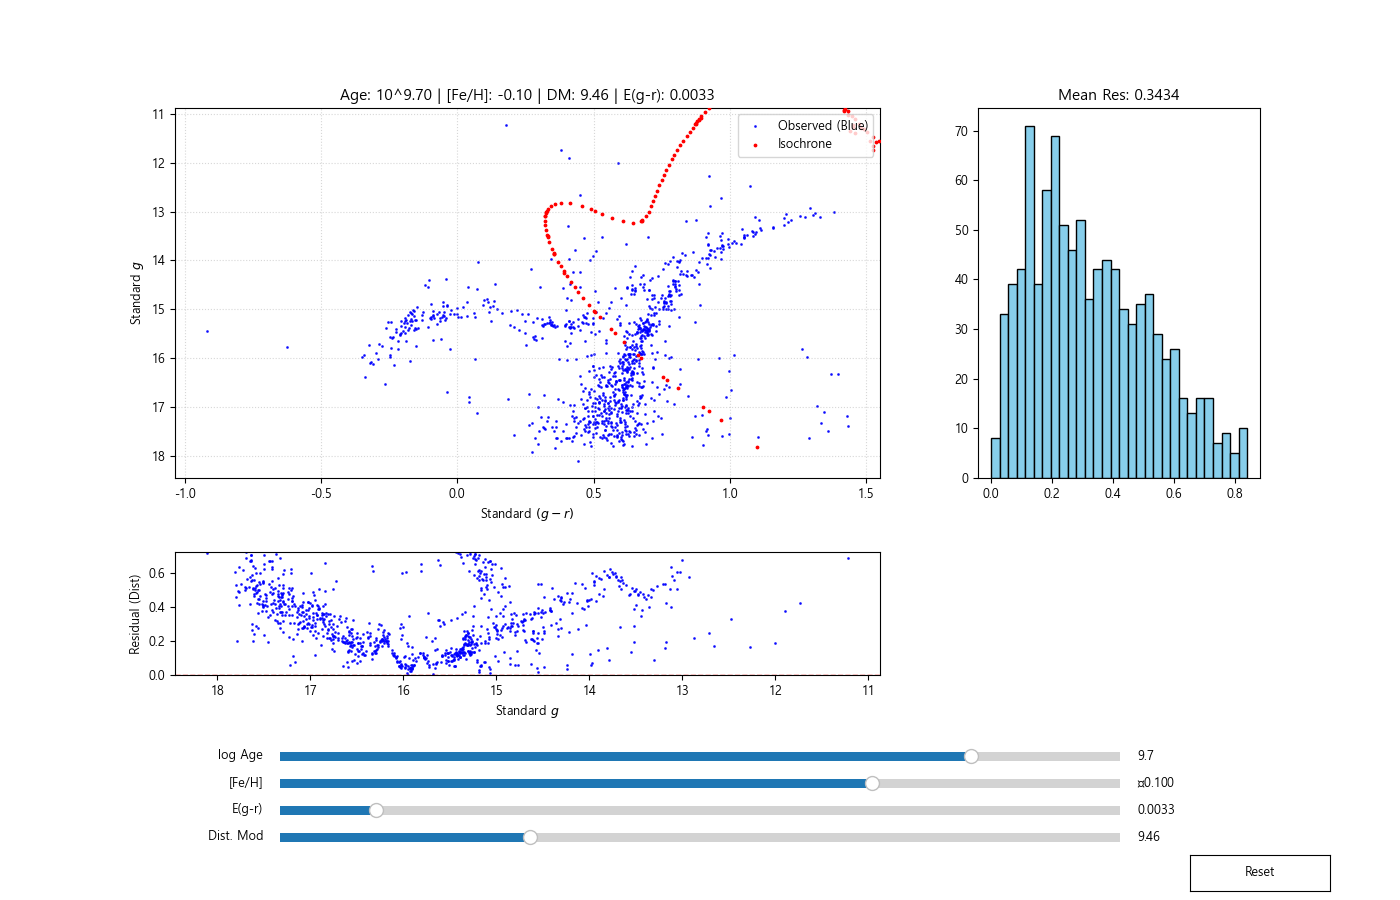

In [25]:
# Cell 15 Isochrone fitting #

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from scipy.spatial import cKDTree

# 폰트 마이너스 깨짐 해결
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 데이터 로드 및 전처리 ---
iso_file_path = r'C:\Users\bmffr\Desktop\Result\CMD\iso_data.dat'
iso_raw = np.genfromtxt(iso_file_path, comments='#')
iso_raw = iso_raw[~np.isnan(iso_raw).any(axis=1)]

available_ages = np.unique(iso_raw[:, 2])
available_mhs = np.unique(iso_raw[:, 1])

obs_g = df_out["mag_std_g"].to_numpy(float)
obs_r = df_out["mag_std_r"].to_numpy(float)
obs_gr = obs_g - obs_r

mask = np.isfinite(obs_g) & np.isfinite(obs_gr)
obs_g, obs_gr = obs_g[mask], obs_gr[mask]
obs_pts = np.c_[obs_gr, obs_g]

# --- 2. 그래프 레이아웃 설정 ---
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[2.5, 1], height_ratios=[3, 1], hspace=0.3, wspace=0.2)

ax_cmd = fig.add_subplot(gs[0, 0])
ax_hist = fig.add_subplot(gs[0, 1])
ax_res_g = fig.add_subplot(gs[1, 0])

plt.subplots_adjust(bottom=0.25)

# (A) 메인 CMD 영역 - 관측 데이터 파란색(blue), 투명도 0.1
ax_cmd.scatter(obs_gr, obs_g, s=1, color='blue', alpha=0.8, label='Observed (Blue)')
sc_iso = ax_cmd.scatter([], [], s=3, color='red', label='Isochrone', zorder=5)
ax_cmd.invert_yaxis()
ax_cmd.set_xlabel('Standard $(g - r)$')
ax_cmd.set_ylabel('Standard $g$')
ax_cmd.legend(loc='upper right')
ax_cmd.grid(True, linestyle=':', alpha=0.5)

# (B) 잔차 산점도
res_scat = ax_res_g.scatter([], [], s=1, color='blue', alpha=0.8)
ax_res_g.axhline(0, color='red', lw=1, ls='--')
ax_res_g.set_xlabel('Standard $g$')
ax_res_g.set_ylabel('Residual (Dist)')

# --- 3. 핵심 함수 ---
def get_iso_points(age, mh, h_shift, v_shift):
    mask = (iso_raw[:, 2] == age) & (iso_raw[:, 1] == mh)
    filtered = iso_raw[mask]
    if len(filtered) == 0: return np.array([]), np.array([])
    g_model = filtered[:, 29] + v_shift
    gr_model = (filtered[:, 29] - filtered[:, 30]) + h_shift
    return gr_model, g_model

def update(val):
    age, mh = s_age.val, s_mh.val
    h_s, v_s = s_hshift.val, s_vshift.val
    
    new_gr, new_g = get_iso_points(age, mh, h_s, v_s)
    sc_iso.set_offsets(np.c_[new_gr, new_g])
    
    if len(new_gr) > 0:
        iso_pts = np.c_[new_gr, new_g]
        tree = cKDTree(iso_pts)
        dist, _ = tree.query(obs_pts)
        
        res_scat.set_offsets(np.c_[obs_g, dist])
        ax_res_g.set_xlim(ax_cmd.get_ylim()) 
        ax_res_g.set_ylim(0, np.percentile(dist, 95)) 
        
        ax_hist.clear()
        ax_hist.hist(dist, bins=30, range=(0, np.percentile(dist, 98)), color='skyblue', edgecolor='black')
        ax_hist.set_title(f"Mean Res: {np.mean(dist):.4f}")
    
    # 제목에 상세 파라미터 표시 (E(g-r) 포함)
    ax_cmd.set_title(f"Age: 10^{age:.2f} | [Fe/H]: {mh:.2f} | DM: {v_s:.2f} | E(g-r): {h_s:.4f}")
    fig.canvas.draw_idle()

# --- 4. 슬라이더 인터페이스 (미세조정 valstep 추가) ---
ax_color = 'whitesmoke'
s_age = Slider(plt.axes([0.2, 0.15, 0.6, 0.02], facecolor=ax_color), 'log Age', 
               available_ages.min(), available_ages.max(), valinit=9.7, valstep=available_ages)
s_mh = Slider(plt.axes([0.2, 0.12, 0.6, 0.02], facecolor=ax_color), '[Fe/H]', 
              available_mhs.min(), available_mhs.max(), valinit=-0.1, valstep=available_mhs)

# E(g-r)과 DM은 미세 조정을 위해 단위를 매우 작게 설정 (방향키 조절 최적화)
s_hshift = Slider(plt.axes([0.2, 0.09, 0.6, 0.02], facecolor=ax_color), 'E(g-r)', 
                  -0.1, 0.8, valinit=0.0033, valstep=0.0001)
s_vshift = Slider(plt.axes([0.2, 0.06, 0.6, 0.02], facecolor=ax_color), 'Dist. Mod', 
                  5.0,20.0, valinit=9.46, valstep=0.01)

s_age.on_changed(update); s_mh.on_changed(update)
s_hshift.on_changed(update); s_vshift.on_changed(update)

# 리셋 버튼
resetax = plt.axes([0.85, 0.01, 0.1, 0.04])
button = Button(resetax, 'Reset', color='white', hovercolor='0.95')
def reset(event):
    s_age.reset(); s_mh.reset(); s_hshift.reset(); s_vshift.reset()
button.on_clicked(reset)

update(None)
plt.show()